In [1]:
"""
Implementation of DDPG - Deep Deterministic Policy Gradient
Algorithm and hyperparameter details can be found here:
    http://arxiv.org/pdf/1509.02971v2.pdf
The algorithm is tested on the Pendulum-v0 OpenAI gym task
and developed with tflearn + Tensorflow
Author: Patrick Emami
"""
import tensorflow as tf
import numpy as np
import gym
from gym import wrappers
import gym_sat_inspection
import tflearn
import argparse
import pprint as pp
import util
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import math
from replay_buffer import ReplayBuffer


W0815 10:55:24.089337 139709828855552 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/lib/python3.6/site-packages/tflearn/helpers/summarizer.py:9: The name tf.summary.merge is deprecated. Please use tf.compat.v1.summary.merge instead.

W0815 10:55:24.090527 139709828855552 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/lib/python3.6/site-packages/tflearn/helpers/trainer.py:25: The name tf.summary.FileWriter is deprecated. Please use tf.compat.v1.summary.FileWriter instead.

W0815 10:55:24.095990 139709828855552 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/lib/python3.6/site-packages/tflearn/collections.py:13: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W0815 10:55:24.099300 139709828855552 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/lib/python3.6/site-packages/tflearn/config.py:123: The name tf.get_collection is deprecated. Please use tf.compat.v1.get_collection instead.

W0815 10:55:24.104690 139709828855552 

In [2]:
class ActorNetwork(object):
    """
    Input to the network is the state, output is the action
    under a deterministic policy.
    The output layer activation is a tanh to keep the action
    between -action_bound and action_bound
    """

    def __init__(self, sess, state_dim, action_dim, action_bound, learning_rate, tau, batch_size):
        self.sess = sess
        self.s_dim = state_dim
        self.a_dim = action_dim
        self.learning_rate = learning_rate
        self.tau = tau
        self.batch_size = batch_size
        self.action_bound = action_bound
        # Actor Network
        self.inputs, self.out, self.scaled_out = self.create_actor_network()

        self.network_params = tf.trainable_variables()

        # Target Network
        self.target_inputs, self.target_out, self.target_scaled_out= self.create_actor_network()

        self.target_network_params = tf.trainable_variables()[
                                     len(self.network_params):]
        self.saver = tf.train.Saver()

        # Op for periodically updating target network with online network
        # weights
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) +
                                                  tf.multiply(self.target_network_params[i], 1. - self.tau))
             for i in range(len(self.target_network_params))]
        
        # This gradient will be provided by the critic network
        self.action_gradient = tf.placeholder(tf.float32, [None, self.a_dim])

        # Combine the gradients here
        self.unnormalized_actor_gradients = tf.gradients(
            self.scaled_out, self.network_params, -self.action_gradient)
        self.actor_gradients = list(map(lambda x: tf.div(x, self.batch_size), self.unnormalized_actor_gradients))

        # Optimization Op
        self.optimize = tf.train.AdamOptimizer(self.learning_rate). \
            apply_gradients(zip(self.actor_gradients, self.network_params))

        self.num_trainable_vars = len(
            self.network_params) + len(self.target_network_params)

    def create_actor_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        net = tflearn.fully_connected(inputs, 400)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        net = tflearn.fully_connected(net, 300)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)
        # Final layer weights are init to Uniform[-3e-3, 3e-3]
        w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
        out = tflearn.fully_connected(
            net, self.a_dim, activation='tanh', weights_init=w_init)
        scaled_out = tf.multiply(out,self.action_bound)
        return inputs, out, scaled_out

    def train(self, inputs, a_gradient):
        self.sess.run(self.optimize, feed_dict={
            self.inputs: inputs,
            self.action_gradient: a_gradient
        })

    def predict(self, inputs):
        return self.sess.run(self.scaled_out, feed_dict={
            self.inputs: inputs
        })

    def predict_target(self, inputs):
        return self.sess.run(self.target_scaled_out, feed_dict={
            self.target_inputs: inputs
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)

    def get_num_trainable_vars(self):
        return self.num_trainable_vars



In [3]:

class CriticNetwork(object):
    """
    Input to the network is the state and action, output is Q(s,a).
    The action must be obtained from the output of the Actor network.
    """

    def __init__(self, sess, state_dim, action_dim, learning_rate, tau, gamma, num_actor_vars):
        self.sess = sess
        self.s_dim = state_dim
        self.a_dim = action_dim
        self.learning_rate = learning_rate
        self.tau = tau
        self.gamma = gamma

        # Create the critic network
        self.inputs, self.action, self.out = self.create_critic_network()

        self.network_params = tf.trainable_variables()[num_actor_vars:]

        # Target Network
        self.target_inputs, self.target_action, self.target_out = self.create_critic_network()

        self.target_network_params = tf.trainable_variables()[(len(self.network_params) + num_actor_vars):]

        # Op for periodically updating target network with online network
        # weights with regularization
        self.update_target_network_params = \
            [self.target_network_params[i].assign(tf.multiply(self.network_params[i], self.tau) \
                                                  + tf.multiply(self.target_network_params[i], 1. - self.tau))
             for i in range(len(self.target_network_params))]

        # Network target (y_i)
        self.predicted_q_value = tf.placeholder(tf.float32, [None, 1])

        # Define loss and optimization Op
        self.loss = tflearn.mean_square(self.predicted_q_value, self.out)
        self.optimize = tf.train.AdamOptimizer(
            self.learning_rate).minimize(self.loss)

        # Get the gradient of the net w.r.t. the action.
        # For each action in the minibatch (i.e., for each x in xs),
        # this will sum up the gradients of each critic output in the minibatch
        # w.r.t. that action. Each output is independent of all
        # actions except for one.
        self.action_grads = tf.gradients(self.out, self.action)

    def create_critic_network(self):
        inputs = tflearn.input_data(shape=[None, self.s_dim])
        action = tflearn.input_data(shape=[None, self.a_dim])
        net = tflearn.fully_connected(inputs, 400)
        net = tflearn.layers.normalization.batch_normalization(net)
        net = tflearn.activations.relu(net)

        # Add the action tensor in the 2nd hidden layer
        # Use two temp layers to get the corresponding weights and biases
        t1 = tflearn.fully_connected(net, 300)
        t2 = tflearn.fully_connected(action, 300)

        net = tflearn.activation(
            tf.matmul(net, t1.W) + tf.matmul(action, t2.W) + t2.b, activation='relu')

        # linear layer connected to 1 output representing Q(s,a)
        # Weights are init to Uniform[-3e-3, 3e-3]
        w_init = tflearn.initializations.uniform(minval=-0.003, maxval=0.003)
        out = tflearn.fully_connected(net, 1, weights_init=w_init)
        return inputs, action, out

    def train(self, inputs, action, predicted_q_value):
        return self.sess.run([self.out, self.optimize], feed_dict={
            self.inputs: inputs,
            self.action: action,
            self.predicted_q_value: predicted_q_value
        })

    def predict(self, inputs, action):
        return self.sess.run(self.out, feed_dict={
            self.inputs: inputs,
            self.action: action
        })

    def predict_target(self, inputs, action):
        return self.sess.run(self.target_out, feed_dict={
            self.target_inputs: inputs,
            self.target_action: action
        })

    def action_gradients(self, inputs, actions):
        return self.sess.run(self.action_grads, feed_dict={
            self.inputs: inputs,
            self.action: actions
        })

    def update_target_network(self):
        self.sess.run(self.update_target_network_params)



In [4]:

# Taken from https://github.com/openai/baselines/blob/master/baselines/ddpg/noise.py, which is
# based on http://math.stackexchange.com/questions/1287634/implementing-ornstein-uhlenbeck-in-matlab
class OrnsteinUhlenbeckActionNoise:
    def __init__(self, mu, sigma=0.5, theta=.15, dt=1, x0=None):
        self.theta = theta
        self.mu = mu
        self.sigma = sigma
        self.dt = dt
        self.x0 = x0
        self.reset()

    def __call__(self):
        x = self.x_prev + self.theta * (self.mu - self.x_prev) * self.dt + \
            self.sigma * np.sqrt(self.dt) * np.random.normal(size=self.mu.shape)
        self.x_prev = x
        return x

    def reset(self):
        self.x_prev = self.x0 if self.x0 is not None else np.zeros_like(self.mu)

    def __repr__(self):
        return 'OrnsteinUhlenbeckActionNoise(mu={}, sigma={})'.format(self.mu, self.sigma)


In [5]:

# ===========================
#   Tensorflow Summary Ops
# ===========================

def build_summaries():
    episode_reward = tf.Variable(0.)
    tf.summary.scalar("Reward", episode_reward)
    episode_ave_max_q = tf.Variable(0.)
    tf.summary.scalar("Qmax Value", episode_ave_max_q)

    summary_vars = [episode_reward, episode_ave_max_q]
    summary_ops = tf.summary.merge_all()

    return summary_ops, summary_vars


In [6]:


# ===========================
#   Agent Training
# ===========================

def train(sess, env, args, actor, critic, actor_noise):
    # Set up summary Ops
    summary_ops, summary_vars = build_summaries()
    start_steps = int(float(args['max_episodes'])/5)
    zero_steps = 0
    sess.run(tf.global_variables_initializer())
    writer = tf.summary.FileWriter(args['summary_dir'], sess.graph)

    # Initialize target network weights
    actor.update_target_network()
    critic.update_target_network()

    # Initialize replay memory
    replay_buffer = ReplayBuffer(int(args['buffer_size']), int(args['random_seed']))

    # Needed to enable BatchNorm.
    # This hurts the performance on Pendulum but could be useful
    # in other environments.
    # tflearn.is_training(True)

    for i in range(int(args['max_episodes'])):

        s = env.reset()

        ep_reward = 0
        ep_ave_max_q = 0

        for j in range(int(args['max_episode_len'])):

            if args['render_env']:
                env.render()

            # Added exploration noise
            # a = actor.predict(np.reshape(s, (1, 3))) + (1. / (1. + i))
            if i > start_steps:
                a = actor.predict(np.reshape(s, (1, actor.s_dim))) + actor_noise()
                s2, r, terminal, info = env.step(a[0])
            elif i >zero_steps:
                mean = np.array([0,0,0,0])
                cov = np.array([[0.25, 0,0,0], [0, 0.25,0,0],[0,0,0.25,0],[0, 0, 0, 0.25]])
                a = np.random.multivariate_normal(mean, cov, 1)
                a = a[0]
                for k in range(len(a)):
                    val = a[k]
                    if val >=0.5:
                        a[k] = 0.5
                    elif val <=-0.5:
                        a[k] = -0.5
                s2, r, terminal, info = env.step(a)
            else:
                a = np.array([0,0,0,0])
                s2, r, terminal, info = env.step(a)

            replay_buffer.add(np.reshape(s, (actor.s_dim,)), np.reshape(a, (actor.a_dim,)), r,
                              terminal, np.reshape(s2, (actor.s_dim,)))

            # Keep adding experience to the memory until
            # there are at least minibatch size samples
            if replay_buffer.size() > int(args['minibatch_size']):
                s_batch, a_batch, r_batch, t_batch, s2_batch = \
                    replay_buffer.sample_batch(int(args['minibatch_size']))

                # Calculate targets
                target_q = critic.predict_target(
                    s2_batch, actor.predict_target(s2_batch))

                y_i = []
                for k in range(int(args['minibatch_size'])):
                    if t_batch[k]:
                        y_i.append(r_batch[k])
                    else:
                        y_i.append(r_batch[k] + critic.gamma * target_q[k])

                # Update the critic given the targets
                predicted_q_value, _ = critic.train(
                    s_batch, a_batch, np.reshape(y_i, (int(args['minibatch_size']), 1)))

                ep_ave_max_q += np.amax(predicted_q_value)

                # Update the actor policy using the sampled gradient
                a_outs = actor.predict(s_batch)
                grads = critic.action_gradients(s_batch, a_outs)
                actor.train(s_batch, grads[0])

                # Update target networks
                actor.update_target_network()
                critic.update_target_network()

            s = s2
            ep_reward += r

            if terminal:
                summary_str = sess.run(summary_ops, feed_dict={
                    summary_vars[0]: ep_reward,
                    summary_vars[1]: ep_ave_max_q / float(j+1)
                })

                writer.add_summary(summary_str, i)
                writer.flush()
                break
        print('| Reward: {:d} | Episode: {:d} | Qmax: {:.4f}'.format(int(ep_reward), i, (ep_ave_max_q / float(j+1))))
        
    best_RTN,best_reward = env.getBestRun()
    R = [RTN[0] for RTN in best_RTN]
    T = [RTN[1] for RTN in best_RTN]
    N = [RTN[2] for RTN in best_RTN]
    fig = plt.figure(1)
    ax = fig.gca(projection='3d')
    ax.plot(R,T,N,label='RTN for Best Run, Reward ={}'.format(best_reward))

In [7]:
def test(sess, env, args, actor):
    # Set up summary Ops
    reward_list = []
    action_list = []
    pct_list = []
    for i in range(int(args['test_episodes'])):

        s = env.reset()
        ep_reward = 0

        for j in range(int(args['max_episode_len'])):
            # a = actor.predict(np.reshape(s, (1, 3))) + (1. / (1. + i))
            a = actor.predict(np.reshape(s, (1, actor.s_dim)))
            s2, r, terminal, info = env.step(a[0])
            s = s2
            ep_reward += r
            action_list.append(a)
            if terminal:
                print('| Reward: {:d} | Episode: {:d}'.format(int(ep_reward),                                                                              i))
                reward_list.append(int(ep_reward))
                pct_list.append(env.percent_coverage)
                break
    best_RTN,best_reward = env.getBestRun()
    R = [RTN[0] for RTN in best_RTN]
    T = [RTN[1] for RTN in best_RTN]
    N = [RTN[2] for RTN in best_RTN]
    fig = plt.figure(2)
    ax = fig.gca(projection='3d')
    ax.plot(R,T,N,label='RTN for Best Test Run, Reward ={}'.format(best_reward))
    return reward_list,action_list,pct_list

In [8]:
def test_rand_policy(env, args):
    # Set up summary Ops
    reward_list = []
    action_list = []
    pct_list = []
    for i in range(int(args['test_episodes'])):

        s = env.reset()
        ep_reward = 0

        for j in range(int(args['max_episode_len'])):
            # a = actor.predict(np.reshape(s, (1, 3))) + (1. / (1. + i))
            mean = np.array([0,0,0,0])
            cov = np.array([[0.25, 0,0,0], [0, 0.25,0,0],[0,0,0.25,0],[0, 0, 0, 0.25]])
            a = np.random.multivariate_normal(mean, cov, 1)
            a = a[0]
            for k in range(len(a)):
                val = a[k]
                if val >=0.5:
                    a[k] = 0.5
                elif val <=-0.5:
                    a[k] = -0.5
            s2, r, terminal, info = env.step(a)
            s = s2
            ep_reward += r
            action_list.append(a)
            if terminal:
                print('| Reward: {:d} | Episode: {:d}'.format(int(ep_reward),                                                                              i))
                reward_list.append(int(ep_reward))
                pct_list.append(env.percent_coverage)
                break
    best_RTN,best_reward = env.getBestRun()
    R = [RTN[0] for RTN in best_RTN]
    T = [RTN[1] for RTN in best_RTN]
    N = [RTN[2] for RTN in best_RTN]
    fig = plt.figure(3)
    ax = fig.gca(projection='3d')
    ax.plot(R,T,N,label='RTN for Best Random Policy Run, Reward ={}'.format(best_reward))
    return reward_list,action_list,pct_list

In [9]:
def test_zero_policy(env, args):
    # Set up summary Ops
    reward_list = []
    action_list = []
    pct_list = []
    for i in range(int(args['test_episodes'])):

        s = env.reset()
        ep_reward = 0

        for j in range(int(args['max_episode_len'])):
            # a = actor.predict(np.reshape(s, (1, 3))) + (1. / (1. + i))
            a = np.array([0,0,0,0])
            s2, r, terminal, info = env.step(a)
            s = s2
            ep_reward += r
            action_list.append(a)
            if terminal:
                print('| Reward: {:d} | Episode: {:d}'.format(int(ep_reward),                                                                              i))
                reward_list.append(int(ep_reward))
                pct_list.append(env.percent_coverage)
                break
    best_RTN,best_reward = env.getBestRun()
    R = [RTN[0] for RTN in best_RTN]
    T = [RTN[1] for RTN in best_RTN]
    N = [RTN[2] for RTN in best_RTN]
    fig = plt.figure(4)
    ax = fig.gca(projection='3d')
    ax.plot(R,T,N,label='RTN for Best Zero Policy Run, Reward ={}'.format(best_reward))
    return reward_list,action_list,pct_list

In [10]:
def main(args):
    oe_insp_0 = np.array([6771., 0.0, 0.0, 0.000001, math.radians(5.0), 0.0])
    oe_targ_0 = np.array([6771., 0.0, 0.0, 0.0, math.radians(5.0), 0.0])
    roe_0 = util.ROEfromOEs(oe_insp_0, oe_targ_0)
    dt = 500
    RTN_0 = util.ROE2HILL(roe_0, oe_targ_0[0], oe_targ_0[1])
    w= math.sqrt(398600/math.pow(oe_targ_0[0],3))
    print("W = ",w)
    w_0 = np.array([0, 0, -w])
    Pg_0 = np.array([np.linalg.norm(RTN_0), 0, 0])
    # Array to store "feature points" by theta, phi pair in Geometric frame.
    map_0 = np.zeros((360, 360))
    num_photos = args['max_episode_len']
    tau = 50
    fuel_0 = np.array((0.1,))
    state_0 = np.concatenate((roe_0, Pg_0, w_0, fuel_0),axis = 0)
    kwargs = {'init_state':state_0, 'map': map_0, 'inspOE_0':oe_insp_0, 'targOE_0': oe_targ_0, 'RTN_0': RTN_0, 'dt':dt,'num_photos':num_photos, 'tau': tau}
    with tf.Session() as sess:

            env = gym.make(args['env'],**kwargs)
            np.random.seed(int(args['random_seed']))
            tf.set_random_seed(int(args['random_seed']))
            env.seed(int(args['random_seed']))

            state_dim = len(state_0)
            action_dim = env.action_space.shape[0]
            action_bound = env.action_space.high[0]
            assert(env.action_space.high[0] == -env.action_space.low[0])
            actor = ActorNetwork(sess, state_dim, action_dim, action_bound,
                                 float(args['actor_lr']), float(args['tau']),
                                 int(args['minibatch_size']))

            critic = CriticNetwork(sess, state_dim, action_dim,
                                   float(args['critic_lr']), float(args['tau']),
                                   float(args['gamma']),
                                   actor.get_num_trainable_vars())

            actor_noise = OrnsteinUhlenbeckActionNoise(mu=np.zeros(action_dim))

            if args['use_gym_monitor']:
                if not args['render_env']:
                    env = wrappers.Monitor(
                        env, args['monitor_dir'], video_callable=False, force=True)
                else:
                    env = wrappers.Monitor(env, args['monitor_dir'], force=True)
            print('Beginning Training')
            train(sess, env, args, actor, critic, actor_noise)
            save_path = actor.saver.save(sess, "./results/model.ckpt")
            if args['use_gym_monitor']:
                env.monitor.close()
            print('Beginning Testing')
            """
                new_saver = tf.train.import_meta_graph('./results/model.ckpt.meta')
                new_saver.restore(sess, tf.train.latest_checkpoint('./results/'))
            """
            reward_list,action_list,pct_list = test(sess, env, args, actor)
            print('Reward List',reward_list)
            print('Actions List', action_list)
            print('Average Reward',np.average(reward_list))
            print('Average Pct Coverage',np.average(pct_list))
            
            print('Testing a Random Policy')
            rand_list, rand_actions,pct_list_rand = test_rand_policy(env, args)
            print('Reward List for Random Policy',rand_list)
            print('Actions List for Random Policy ',rand_actions)
            print('Average Reward for Random Policy ',np.average(rand_list))
            print('Average Pct Coverage for Random Policy ',np.average(pct_list_rand))
            
            print('Testing a Zero Policy')
            zero_list, zero_actions,pct_list_zero = test_zero_policy(env, args)
            print('Reward List for Zero Policy',zero_list)
            print('Actions List for Zero Policy ',zero_actions)
            print('Average Reward for Zero Policy ',np.average(zero_list))
            print('Average Pct Coverage for Zero Policy ',np.average(pct_list_zero))
            
            plt.figure(5)
            plt.plot(reward_list, color = "blue")
            plt.plot(rand_list, color = "red")
            plt.plot(zero_list,color = "green")
            plt.legend()
            plt.title('Reward Comparison')
            plt.xlabel('Episode Number')
            plt.ylabel('Reward')


W0815 10:55:24.356871 139709828855552 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/lib/python3.6/site-packages/tflearn/layers/core.py:81: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 10:55:24.358799 139709828855552 deprecation.py:506] From /home/ubuntu/anaconda3/lib/python3.6/site-packages/tflearn/initializations.py:174: calling TruncatedNormal.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0815 10:55:24.478046 139709828855552 deprecation.py:506] From /home/ubuntu/anaconda3/lib/python3.6/site-packages/tflearn/initializations.py:75: calling RandomUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead 

W =  0.0011331552793256065


W0815 10:55:24.954260 139709828855552 deprecation.py:323] From <ipython-input-2-e6f016854479>:42: div (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


Beginning Training


W0815 10:55:25.918768 139709828855552 meta_graph.py:449] Issue encountered when serializing data_preprocessing.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
W0815 10:55:25.919438 139709828855552 meta_graph.py:449] Issue encountered when serializing data_augmentation.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4932
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4150
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2580
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2132
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1768
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1161
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 989
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 919
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 770
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 717
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 99 RTN:  [-0.12511136 -0.00316551 -0.0965591 ] Fuel Consumed 0.00033559072184585976 New Features 2490
Actions Left 98 RTN:  [-0.26873294  0.14761703 -0.16844347] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [-0.39416368  0.43897249 -0.19728379] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.54625771  1.6775396  -0.10137771] Fuel Consumed 0.00028967919369777694 New Features 0
Actions Left 95 RTN:  [-0.71065185  2.16878967  0.02045349] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.81077833  2.46835969  0.11940783] Fuel Consumed 8.486477266553383e-05 New Features 0
Actions Left 93 RTN:  [-0.83188599  3.18699106  0.18784798] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.60436047  1.55273632  0.10040908] Fuel Consumed 0.00043301270189221935 New Features 0
Actions Left 91 RTN:  [-0.23777536  1.9759413  -0.01272208] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.14263416  3.07563688 -0.08949167] Fuel Consumed 0.000121897

Actions Left 96 RTN:  [ 5.12277765e-01 -8.23137338e-01 -1.07057622e-05] Fuel Consumed 0.0001505602278259527 New Features 0
Actions Left 95 RTN:  [ 0.56934613 -1.29332467  0.13401463] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.60336373 -2.14743298  0.21908845] Fuel Consumed 8.312453381529413e-05 New Features 0
Actions Left 93 RTN:  [ 0.60978351 -2.61261396  0.23150941] Fuel Consumed 5.4959114671081645e-05 New Features 0
Actions Left 92 RTN:  [ 0.56888849 -3.11021295  0.18479219] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.49234008 -3.52519534  0.09250786] Fuel Consumed 5.792323775501583e-06 New Features 0
Actions Left 90 RTN:  [ 0.39757953 -3.87293965 -0.02341844] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.023881172839506172
Actions Left 89 RTN:  [ 0.21502151 -4.89754338 -0.24142619] Fuel Consumed 0.0003591305542996355 New Features 0
| Reward: -738 | Episode: 11 | Qmax: 183.2971
Actions Left 

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4906
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4146
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2545
Actions Left 96 RTN:  [ 0.04990941 -0.91497162  0.01651445] Fuel Consumed 0.0002529129805174628 New Features 0
Actions Left 95 RTN:  [ 0.20344921 -0.9266587   0.02985319] Fuel Consumed 7.88912115680753e-06 New Features 0
Actions Left 94 RTN:  [ 0.41795272 -1.12828205  0.03556301] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.63860501 -1.55726313  0.03218506] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.78336895 -2.38819514 -0.00500699] Fuel Consumed 9.593542400249092e-05 New Features 0
Actions Left 91 RTN:  [ 0.85506136 -2.07124699 -0.07358904] Fuel Consumed 0.000139710849875298 New Features 0
Actions Left 90 RTN:  [ 0.78645529 -2.8436875  -0.12334403] Fuel Consumed 0.0 New Fe

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4931
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4072
Actions Left 97 RTN:  [-0.02952882 -0.10551072  0.00938456] Fuel Consumed 9.853412007571047e-05 New Features 0
Actions Left 96 RTN:  [-0.02010867 -0.17041666  0.03386752] Fuel Consumed 5.3669876942439635e-05 New Features 0
Actions Left 95 RTN:  [-0.00844179 -1.32500935  0.02765583] Fuel Consumed 0.00033724006690601636 New Features 0
Actions Left 94 RTN:  [ 0.1042419  -0.9396696   0.01738517] Fuel Consumed 0.00010464673026061537 New Features 0
Actions Left 93 RTN:  [ 0.32032969 -1.01984065  0.00267172] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.71008579 -3.61218035 -0.11094636] Fuel Consumed 0.0003715925164737419 New Features 0
Actions Left 91 RTN:  [ 1.08612667 -5.89973256 -0.13469955] Fuel Consumed 0.00032687291787670755 New Features 0
Actions Left 90 RTN:  [ 1.49295079 -6.8655152

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4165
Actions Left 97 RTN:  [ 0.03372178 -0.39124425 -0.07783697] Fuel Consumed 0.0002457900337946466 New Features 0
Actions Left 96 RTN:  [ 0.13986911 -0.39995135 -0.13578348] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.25092911 -1.60131276 -0.12856374] Fuel Consumed 0.00030165640831134613 New Features 0
Actions Left 94 RTN:  [ 0.49050835 -2.91491884 -0.11965884] Fuel Consumed 0.0001984029702403721 New Features 0
Actions Left 93 RTN:  [ 0.81156831 -3.17209871 -0.0252858 ] Fuel Consumed 0.00016303803893251754 New Features 0
Actions Left 92 RTN:  [ 1.22436219 -4.92113126  0.08347837] Fuel Consumed 0.00012746028176661422 New Features 0
Actions Left 91 RTN:  [ 1.61772234 -4.19849706  0.08137051] Fuel Consumed 0.0002922671320287555 New Features 0
Actions Left 90 RTN:  [ 1.8088941  -5.75872212  0.05851173] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [ 1.75095144 -9.31697515  0

Actions Left 97 RTN:  [ 0.03087238 -0.21574472 -0.05480824] Fuel Consumed 0.00019645287308475473 New Features 0
Actions Left 96 RTN:  [ 0.06771329 -0.255833   -0.02770728] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.09773437 -0.33085495  0.00647399] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.11326403 -0.42967599  0.0390009 ] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.19870952 -0.52715303  0.08823007] Fuel Consumed 0.00021749571956467922 New Features 0
Actions Left 92 RTN:  [ 0.23471001 -0.84748356  0.11626104] Fuel Consumed 2.291019501738345e-05 New Features 0
Actions Left 91 RTN:  [0.2746571  1.48288332 0.22252226] Fuel Consumed 0.00043301270189221935 New Features 0
Actions Left 90 RTN:  [0.16098904 1.10748343 0.26357735] Fuel Consumed 4.236611601010949e-05 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.03740740740740741
Actions Left 89 RTN:  [-0.02103357  0.72903773  0.30551459] Fuel Consumed 0.

Actions Left 95 RTN:  [ 0.50656537 -1.15180561 -0.07909032] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.4579442 -1.5994391 -0.0114042] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.25189085 -0.8381186  -0.04874724] Fuel Consumed 0.00031918010776158803 New Features 0
Actions Left 92 RTN:  [-0.01963285 -0.92060322 -0.06248425] Fuel Consumed 3.852591205190996e-05 New Features 0
Actions Left 91 RTN:  [-0.36722539  0.3888468  -0.10718596] Fuel Consumed 0.0001819331584524043 New Features 0
Actions Left 90 RTN:  [-0.67975816  0.47934389 -0.11884151] Fuel Consumed 3.6166116073457336e-05 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.025787037037037035
Actions Left 89 RTN:  [-0.86722147  1.2346189  -0.10013046] Fuel Consumed 0.0 New Features 0
| Reward: -749 | Episode: 42 | Qmax: 282.7622
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4897
Actions Left 98 RTN:  [ 0.10021494 -0.0551

Actions Left 99 RTN:  [0.07938503 0.06781052 0.10790578] Fuel Consumed 0.0003587730315536448 New Features 2567
Actions Left 98 RTN:  [0.25123999 0.01789661 0.1882373 ] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [ 0.47164905 -0.23696516  0.22046665] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.67567263 -0.86270833  0.19438235] Fuel Consumed 5.930073000134975e-05 New Features 0
Actions Left 95 RTN:  [ 0.8386528  -1.51053483  0.11862623] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.96704955 -3.28424128  0.12051303] Fuel Consumed 0.0002958195874693562 New Features 0
Actions Left 93 RTN:  [ 1.04993793 -4.11843493  0.09154556] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 1.07547093 -4.01244039  0.11956303] Fuel Consumed 0.00023081825415999935 New Features 0
Actions Left 91 RTN:  [ 0.97766811 -4.92007881  0.11691948] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.78156818 -5.67416061  0.08439833] Fuel Consumed 0.0 New Features 0


Done because did not see target for a long time
Final Percent Coverage:  0.10090277777777777
Actions Left 86 RTN:  [-0.54632841  4.72900217  0.06617161] Fuel Consumed 0.00010524513803589879 New Features 0
| Reward: 518 | Episode: 54 | Qmax: 168.6854
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4962
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4027
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2559
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2151
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1792
Actions Left 94 RTN:  [ 0.11768848 -0.3345696  -0.09343902] Fuel Consumed 0.0003338377785063305 New Features 0
Actions Left 93 RTN:  [ 0.18034612  0.4205345  -0.21448472] Fuel Consumed 0.00017506743709427944 New Features 0
Actions Left 92 RTN:  [ 0.16496169  0.20531414 

Actions Left 85 RTN:  [-0.12181727  3.50087648  0.03025413] Fuel Consumed 0.00026248912503665873 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.1376003086419753
Actions Left 84 RTN:  [-0.27897316  3.61861729  0.04755072] Fuel Consumed 0.0 New Features 0
| Reward: 883 | Episode: 60 | Qmax: 169.2180
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 5000
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4032
Actions Left 97 RTN:  [ 0.07210852 -0.54295148 -0.09768587] Fuel Consumed 0.00032650066959051007 New Features 0
Actions Left 96 RTN:  [ 0.2336442  -0.59150357 -0.17040908] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.4581726  -0.85069848 -0.13675438] Fuel Consumed 0.0001529771356760289 New Features 0
Actions Left 94 RTN:  [ 0.6131516  -2.70954343  0.00346313] Fuel Consumed 0.0003722014623571812 New Features 0
Actions Left 93 RTN:  [ 0.81581421 -3.2

| Reward: -1024 | Episode: 66 | Qmax: 234.9359
Actions Left 99 RTN:  [ 0.02414787  0.04487896 -0.01723153] Fuel Consumed 0.000150469751466356 New Features 4194
Actions Left 98 RTN:  [ 0.18799497 -0.01028955 -0.11339195] Fuel Consumed 0.000262891361503723 New Features 2169
Actions Left 97 RTN:  [ 0.48882492 -0.32215354 -0.21547446] Fuel Consumed 0.00026331517531342016 New Features 0
Actions Left 96 RTN:  [ 0.70631651 -0.61877961 -0.23454584] Fuel Consumed 0.00010895648682936971 New Features 0
Actions Left 95 RTN:  [ 0.71650993 -0.49380531 -0.19812443] Fuel Consumed 0.00019001750481581055 New Features 0
Actions Left 94 RTN:  [ 0.51979739 -1.16568598 -0.11107368] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.21483297 -2.09469551  0.01970538] Fuel Consumed 0.00010843311048611715 New Features 0
Actions Left 92 RTN:  [-0.13813794 -2.12725852  0.14544869] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.44891664 -1.81302942  0.23402404] Fuel Consumed 0.0 New Features 0


Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4971
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4111
Actions Left 97 RTN:  [-0.00429538 -0.02607955  0.00427926] Fuel Consumed 1.4780952881105491e-05 New Features 3773
Actions Left 96 RTN:  [ 0.00238347 -0.91160133 -0.04046882] Fuel Consumed 0.0003039901387494087 New Features 0
Actions Left 95 RTN:  [ 0.09350397 -0.21292964 -0.11607555] Fuel Consumed 0.00015847255345335847 New Features 0
Actions Left 94 RTN:  [ 0.2215558  -0.31127977 -0.16203153] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.35381774 -0.54563716 -0.16658196] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.48165532 -3.16097675 -0.14469162] Fuel Consumed 0.0002629016030681316 New Features 0
Actions Left 91 RTN:  [ 0.65998156 -3.568363   -0.08583275] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.84028016 -5.84354751 -0.02365801] Fuel Consumed 0.0001

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4886
Actions Left 98 RTN:  [ 0.07179446  0.06831518 -0.04497918] Fuel Consumed 0.00030241243855412845 New Features 0
Actions Left 97 RTN:  [ 0.06788575 -0.0707525  -0.07846438] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.01403897 -0.16497442 -0.09189879] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.06537718 -0.53185887 -0.02230272] Fuel Consumed 0.00022738205095547835 New Features 0
Actions Left 94 RTN:  [-0.13321342 -0.45594729  0.04922807] Fuel Consumed 1.2385195919543261e-05 New Features 0
Actions Left 93 RTN:  [-0.21663277 -0.0107806   0.11212249] Fuel Consumed 4.757698952632405e-05 New Features 0
Actions Left 92 RTN:  [-0.32429341 -0.33455083  0.13032815] Fuel Consumed 0.0001297095488090434 New Features 0
Actions Left 91 RTN:  [-0.36820299  0.00642628  0.11523212] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.39227974 -1.13587636  0.03108666] Fuel Co

Actions Left 88 RTN:  [-0.25868983 -2.02948598  0.12314636] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.04938271604938271
Actions Left 87 RTN:  [-0.45925514  0.02594922  0.11268808] Fuel Consumed 0.0002160618965341773 New Features 0
| Reward: -979 | Episode: 86 | Qmax: 213.6195
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4981
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4076
Actions Left 97 RTN:  [ 0.02077765 -0.27829164  0.02562864] Fuel Consumed 0.000132938717291392 New Features 0
Actions Left 96 RTN:  [ 0.11151799 -0.21262273  0.06294208] Fuel Consumed 6.736374040547137e-05 New Features 0
Actions Left 95 RTN:  [0.28656583 0.48012462 0.07127481] Fuel Consumed 0.00030567817410367303 New Features 0
Actions Left 94 RTN:  [0.35414593 0.10811849 0.06139909] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.29703174 -0.2693558

Actions Left 98 RTN:  [-0.02747562 -0.06631783  0.03480941] Fuel Consumed 0.00032579875895541227 New Features 3631
Actions Left 97 RTN:  [-0.24089534 -0.28499286  0.16411269] Fuel Consumed 0.00016700235849310952 New Features 0
Actions Left 96 RTN:  [-0.53425065 -0.02055328  0.25327967] Fuel Consumed 6.583502408079074e-06 New Features 0
Actions Left 95 RTN:  [-0.95537965  0.8758767   0.24118064] Fuel Consumed 0.00026977751188410435 New Features 0
Actions Left 94 RTN:  [-1.2777975   1.63461921  0.1719341 ] Fuel Consumed 5.1546018479609286e-05 New Features 0
Actions Left 93 RTN:  [-1.46395474  2.48826767  0.09369884] Fuel Consumed 0.00015068726003641153 New Features 0
Actions Left 92 RTN:  [-1.39682708  4.97259974 -0.04660048] Fuel Consumed 0.00017488318931347982 New Features 0
Actions Left 91 RTN:  [-1.10844918  5.33808766 -0.1627649 ] Fuel Consumed 0.00010913095217946632 New Features 0
Actions Left 90 RTN:  [-0.59180717  5.0474271  -0.17930088] Fuel Consumed 0.00024191170746737451 New F

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4972
Actions Left 98 RTN:  [-0.01126881 -0.07019195 -0.00876349] Fuel Consumed 9.518499151475007e-05 New Features 2871
Actions Left 97 RTN:  [-0.11823121  0.31526833 -0.01080487] Fuel Consumed 0.000280376389053657 New Features 0
Actions Left 96 RTN:  [-0.14442956  0.46542984  0.0473834 ] Fuel Consumed 0.0002199825877207941 New Features 0
Actions Left 95 RTN:  [-0.16095317  0.59530616  0.09347213] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.18960502  0.67493195  0.09343494] Fuel Consumed 8.486572171964617e-05 New Features 0
Actions Left 93 RTN:  [-0.11350835 -1.09719924  0.08026222] Fuel Consumed 0.0002562718380882041 New Features 0
Actions Left 92 RTN:  [ 0.08241269 -0.98201712  0.04657764] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.3172634  -1.47856239 -0.0134069 ] Fuel Consumed 0.00010386710195757545 New Features 0
Actions Left 90 RTN:  [ 0.67707388 -2.8836452  -0

Actions Left 99 RTN:  [-0.00691692 -0.05811052 -0.03623528] Fuel Consumed 0.00013603044215094678 New Features 4884
Actions Left 98 RTN:  [-0.10123704  0.06905887 -0.10975079] Fuel Consumed 0.00017797625030902429 New Features 0
Actions Left 97 RTN:  [-0.27612185  0.15027615 -0.15522137] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.5004913   0.42465358 -0.12704283] Fuel Consumed 8.58180290964715e-05 New Features 0
Actions Left 95 RTN:  [-0.70145423  0.93882166 -0.06638657] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.89533868  2.01781529  0.03101257] Fuel Consumed 0.00014663464662222222 New Features 0
Actions Left 93 RTN:  [-0.99070438  2.86133095  0.12049377] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.98051656  5.99453355  0.28703504] Fuel Consumed 0.0003649065153351613 New Features 0
Actions Left 91 RTN:  [-1.01628199  4.28051946  0.30463943] Fuel Consumed 0.00038916087174426867 New Features 0
Actions Left 90 RTN:  [-0.92669645  5.14945006  0

Actions Left 99 RTN:  [-0.0889293  -0.00751264  0.06705865] Fuel Consumed 0.0002346245848323673 New Features 4343
Actions Left 98 RTN:  [-0.19225154  0.0989632   0.11698113] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [-0.23203425  0.83395172  0.02911858] Fuel Consumed 0.00043301270189221935 New Features 0
Actions Left 96 RTN:  [-0.49560744  1.59500122 -0.01708574] Fuel Consumed 0.0002979675203181516 New Features 0
Actions Left 95 RTN:  [-0.88530769  2.87652379 -0.10031182] Fuel Consumed 0.00018856401859853122 New Features 0
Actions Left 94 RTN:  [-1.26752685  4.65302352 -0.18021578] Fuel Consumed 0.0002983842693571949 New Features 0
Actions Left 93 RTN:  [-1.71689954  6.00744197 -0.22310131] Fuel Consumed 6.476763499330631e-05 New Features 0
Actions Left 92 RTN:  [-2.14670349  7.46672009 -0.19635299] Fuel Consumed 0.0001216629736508585 New Features 0
Actions Left 91 RTN:  [-2.30409346  7.99277206 -0.12485829] Fuel Consumed 0.00019221984137852668 New Features 0
Actions Left 

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4926
Actions Left 98 RTN:  [0.06865118 0.07527022 0.03069096] Fuel Consumed 0.00029211705229496084 New Features 0
Actions Left 97 RTN:  [ 0.05962161 -0.06086661  0.05353916] Fuel Consumed 0.0 New Features 3786
Actions Left 96 RTN:  [-0.02809297 -0.14645712  0.06270595] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.17207796 -0.11099055  0.05584886] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.29405113 -0.25435958 -0.00053443] Fuel Consumed 0.00011869755184497107 New Features 0
Actions Left 93 RTN:  [-0.38148542  0.05436086 -0.0567809 ] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.41203764  0.42472622 -0.09851757] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.37790048  0.79321854 -0.11507905] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.28779734  1.0967985  -0.10223323] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0.123

Actions Left 93 RTN:  [-1.02070363  2.96468955 -0.04911572] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.93024412  3.82983571 -0.15562402] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.74360009  4.55020239 -0.22236415] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.56009769  7.99897381 -0.34010559] Fuel Consumed 0.00035371812830741427 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.01992283950617284
Actions Left 89 RTN:  [-0.48774993  8.26944421 -0.37102986] Fuel Consumed 0.0 New Features 0
| Reward: -699 | Episode: 123 | Qmax: 227.7822
Actions Left 99 RTN:  [0.01584031 0.06339795 0.00761481] Fuel Consumed 0.00018036933894880768 New Features 4325
Actions Left 98 RTN:  [0.10100397 0.09393311 0.01009399] Fuel Consumed 1.2799557308914245e-05 New Features 2094
Actions Left 97 RTN:  [ 0.17449738  0.15990019 -0.05083097] Fuel Consumed 0.00018819188988294976 New Features 0
Actions Left 96 RTN:  [ 0.21380713 -0.61

Actions Left 99 RTN:  [-0.01615564  0.06411501  0.02567641] Fuel Consumed 0.0001845794095415921 New Features 4389
Actions Left 98 RTN:  [0.02984576 0.12418937 0.0394068 ] Fuel Consumed 1.8874405446359364e-05 New Features 2187
Actions Left 97 RTN:  [0.12088033 0.20282702 0.05108893] Fuel Consumed 4.40472349351259e-05 New Features 0
Actions Left 96 RTN:  [0.22788014 0.07164938 0.04971551] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [0.2005517  0.4686714  0.13602739] Fuel Consumed 0.000343223601589312 New Features 0
Actions Left 94 RTN:  [0.11661327 0.29710361 0.18756233] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.02938717  0.81264275  0.20582084] Fuel Consumed 8.500573467854947e-05 New Features 0
Actions Left 92 RTN:  [-0.20678227  0.89364806  0.17147413] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.2938115   0.90244539  0.02146945] Fuel Consumed 0.00023614018009689443 New Features 0
Actions Left 90 RTN:  [-0.36541206  1.26578672 -0.11789736] Fuel

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4958
Actions Left 98 RTN:  [-0.00152325 -0.01418219 -0.00253944] Fuel Consumed 1.069250040277473e-05 New Features 4293
Actions Left 97 RTN:  [ 0.00321739 -0.0122754  -0.00442996] Fuel Consumed 0.0 New Features 4111
Actions Left 96 RTN:  [-0.03612713  0.17842156 -0.01963662] Fuel Consumed 9.999423416008185e-05 New Features 0
Actions Left 95 RTN:  [-0.08525787  0.22112498 -0.02982535] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.19774913 -0.36833391 -0.07287712] Fuel Consumed 0.00025917588174304967 New Features 0
Actions Left 93 RTN:  [-0.35049813  1.38503694 -0.16892445] Fuel Consumed 0.0003130456915443711 New Features 0
Actions Left 92 RTN:  [-0.46586854  1.75475482 -0.22183506] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.5135283   2.38490411 -0.21074222] Fuel Consumed 2.628123078593724e-05 New Features 0
Actions Left 90 RTN:  [-0.4897604   2.84395172 -0.1457915 ] Fue

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4916
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4079
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2617
Actions Left 96 RTN:  [ 0.0383918  -0.17315431 -0.03846762] Fuel Consumed 0.00012753524213542607 New Features 0
Actions Left 95 RTN:  [ 0.00780856 -0.5660382  -0.01590007] Fuel Consumed 0.00027917215210276306 New Features 0
Actions Left 94 RTN:  [ 0.01776054 -0.03412644 -0.00686759] Fuel Consumed 8.799861478943938e-05 New Features 4975
Actions Left 93 RTN:  [ 0.04382229 -0.04380878  0.00392041] Fuel Consumed 0.0 New Features 5179
Actions Left 92 RTN:  [0.17801869 0.2299809  0.12161308] Fuel Consumed 0.00035591040320129855 New Features 0
Actions Left 91 RTN:  [ 0.26892822 -0.00113555  0.20822792] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.29332066 -0.2924943   0.24163218] Fuel Consumed 0.

Actions Left 99 RTN:  [ 0.01865136 -0.05152033  0.10790578] Fuel Consumed 0.00026897663707575 New Features 3701
Actions Left 98 RTN:  [ 0.00661849 -0.09295665  0.1882373 ] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [-0.03302371 -0.10739407  0.22046665] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.0901451  -0.071275    0.19635793] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.15014885  0.02603893  0.12207189] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.1977016   0.17954838  0.01659159] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.28036432  0.94834203 -0.10809181] Fuel Consumed 0.0001285512746846116 New Features 0
Actions Left 92 RTN:  [-0.31209826  2.05717573 -0.12591491] Fuel Consumed 0.0002485617921557874 New Features 0
Actions Left 91 RTN:  [-0.36100123  2.53267055 -0.11142873] Fuel Consumed 3.209500454595911e-05 New Features 0
Actions Left 90 RTN:  [-0.45185889  0.64644296 -0.15543801] Fuel Consumed 0.00031324028631

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4938
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4131
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2616
Actions Left 96 RTN:  [ 0.13601997 -0.87886743 -0.09255526] Fuel Consumed 0.00037667413322808456 New Features 0
Actions Left 95 RTN:  [ 0.34655163 -1.01933733 -0.16145895] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.57102952 -1.38708853 -0.1891034 ] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.75209051 -1.96672336 -0.16842435] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.8487576  -3.13784581 -0.13437574] Fuel Consumed 8.593792690088027e-05 New Features 0
Actions Left 91 RTN:  [ 0.85345587 -3.8911246  -0.06599377] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.77845104 -4.87939078  0.06349891] Fuel Consumed 0.00010681546563558806 New Features 0
Actio

Actions Left 97 RTN:  [-0.09746178  0.11283952 -0.05456184] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.09100734  0.14603299 -0.07677498] Fuel Consumed 0.00024081996311523836 New Features 0
Actions Left 95 RTN:  [-0.1675377   0.76623657 -0.06543795] Fuel Consumed 0.00013419902067188244 New Features 0
Actions Left 94 RTN:  [-0.4228937   2.53330427  0.06561673] Fuel Consumed 0.00037643860497102113 New Features 0
Actions Left 93 RTN:  [-0.78795803  2.76358895  0.16164724] Fuel Consumed 5.2277366662177075e-05 New Features 0
Actions Left 92 RTN:  [-1.16006585  3.62551999  0.21442338] Fuel Consumed 1.1210268892839228e-05 New Features 0
Actions Left 91 RTN:  [-1.4426938   4.75994333  0.21240512] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-1.56361811  6.10521234  0.15610884] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.03830246913580247
Actions Left 89 RTN:  [-1.46387755  7.01709598  0.04206589] Fuel Con

Done because did not see target for a long time
Final Percent Coverage:  0.018726851851851852
Actions Left 89 RTN:  [-0.28792129  5.40711485 -0.13285443] Fuel Consumed 5.3997419190451385e-05 New Features 0
| Reward: -683 | Episode: 166 | Qmax: 201.2256
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4955
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4068
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2524
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2131
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1811
Actions Left 94 RTN:  [-0.00751543  0.30618949  0.03161781] Fuel Consumed 8.689000276122897e-05 New Features 0
Actions Left 93 RTN:  [-0.03014236  0.30323002  0.05515601] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.0562134   0.42361344  0.07253134] Fue

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4910
Actions Left 98 RTN:  [ 0.04626531 -0.13230989 -0.05779725] Fuel Consumed 0.00018605364175422167 New Features 0
Actions Left 97 RTN:  [ 0.1353443  -0.17128646 -0.10082499] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.24116204 -0.31209155 -0.1180879 ] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.32909917 -0.71984794 -0.09954385] Fuel Consumed 5.04004933382671e-05 New Features 0
Actions Left 94 RTN:  [ 0.38619205 -0.979339   -0.05145159] Fuel Consumed 2.9615535454490433e-05 New Features 0
Actions Left 93 RTN:  [ 0.40810886 -1.32515608  0.00978841] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [0.38103908 0.57656419 0.04342021] Fuel Consumed 0.0002798970483126675 New Features 0
Actions Left 91 RTN:  [0.20734547 0.21550396 0.06596056] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.0685783   0.08935724  0.07164535] Fuel Consumed 0.0 New Features 0


Actions Left 99 RTN:  [-0.04314969  0.10396634 -0.07920454] Fuel Consumed 0.0003292282537023546 New Features 2743
Actions Left 98 RTN:  [ 0.01190289  0.21525572 -0.13816915] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [ 0.14250728  0.28589579 -0.12043675] Fuel Consumed 9.942480494674193e-05 New Features 0
Actions Left 96 RTN:  [ 0.3123947   0.13068308 -0.0719302 ] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.47815197 -0.19989536 -0.0050426 ] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.59742145 -0.67939294  0.06313358] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.62577013 -1.41294934  0.11649537] Fuel Consumed 5.02299000230893e-05 New Features 0
Actions Left 92 RTN:  [ 0.58038474 -1.94927242  0.14008717] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.47285204 -2.40569972  0.12788108] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.32410496 -2.84204451  0.08341327] Fuel Consumed 2.2491214802310333e-05 New Featur

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4933
Actions Left 98 RTN:  [-0.00124482 -0.01186856 -0.00684137] Fuel Consumed 1.8456478996085743e-05 New Features 4433
Actions Left 97 RTN:  [-0.1571378   0.57952994 -0.00239077] Fuel Consumed 0.00033977699886572485 New Features 0
Actions Left 96 RTN:  [-0.37490454  0.74636684  0.00267094] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.62984025  1.73121343  0.03912389] Fuel Consumed 0.00013824759544473405 New Features 0
Actions Left 94 RTN:  [-0.8185619   1.82702031  0.08953301] Fuel Consumed 0.00013669558803187587 New Features 0
Actions Left 93 RTN:  [-0.89463753  3.38696987  0.07586308] Fuel Consumed 0.00017682452154054126 New Features 0
Actions Left 92 RTN:  [-0.90800251  4.14806729  0.04279948] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.94648121  4.92366111  0.02021896] Fuel Consumed 0.00021782263255411345 New Features 0
Actions Left 90 RTN:  [-0.90850224  5.71270

Actions Left 99 RTN:  [ 0.10592771 -0.06598102 -0.03109497] Fuel Consumed 0.00026024030025492597 New Features 3599
Actions Left 98 RTN:  [ 0.23310545 -0.33193036 -0.07577571] Fuel Consumed 0.0001278106133292183 New Features 0
Actions Left 97 RTN:  [ 0.35139951 -0.58210396 -0.10108979] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.43058394 -0.93545499 -0.10057138] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.4669229  -0.95528455 -0.06557469] Fuel Consumed 0.00011502339490739276 New Features 0
Actions Left 94 RTN:  [ 0.39851783 -1.39157117 -0.01382302] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.19880621 -0.91396038  0.07952172] Fuel Consumed 0.00014306407181015853 New Features 0
Actions Left 92 RTN:  [-0.08288457 -1.00849587  0.15253216] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.53129034  1.51211881  0.29449737] Fuel Consumed 0.00041441105126703467 New Features 0
Actions Left 90 RTN:  [-0.97258788  2.15767115  0.36117565] Fuel C

Actions Left 92 RTN:  [ 0.91006888 -2.5804318  -0.03491416] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 1.18079128 -4.07427532 -0.03015625] Fuel Consumed 0.00019150153316160464 New Features 0
Actions Left 90 RTN:  [ 1.33626872e+00 -5.21657209e+00 -5.15297475e-03] Fuel Consumed 2.9961897734734617e-05 New Features 0
Actions Left 89 RTN:  [ 1.33430635 -6.4114054   0.02115741] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0698070987654321
Actions Left 88 RTN:  [ 1.20881451 -7.06455868  0.08292774] Fuel Consumed 0.00013779404163520988 New Features 0
| Reward: -1175 | Episode: 197 | Qmax: 238.3557
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4898
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4123
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2559
Actions Left 96 RTN:  [ 0.14319099 -0.

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4971
Actions Left 98 RTN:  [ 0.01087563 -0.02693545  0.10790578] Fuel Consumed 0.0002523486101582705 New Features 4069
Actions Left 97 RTN:  [ 0.0281313  -0.04094564  0.1882373 ] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.04404583 -0.07228641  0.22046665] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.05455242 -0.11743153  0.19635793] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.07251003  1.27099452  0.19842987] Fuel Consumed 0.0003369931882004045 New Features 0
Actions Left 93 RTN:  [-0.27385622  1.35082167  0.14976368] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.498067    1.65299139  0.06282686] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.68784753  2.17146092 -0.04016473] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.75220862 -0.09858789 -0.12031757] Fuel Consumed 0.00025374619379030775 New Features 0
Actions L

Actions Left 99 RTN:  [-0.02865297  0.00735062 -0.00695675] Fuel Consumed 6.80535892114035e-05 New Features 4791
Actions Left 98 RTN:  [-0.04454746  0.05151814 -0.01213577] Fuel Consumed 0.0 New Features 4706
Actions Left 97 RTN:  [-0.04362179  0.10350649 -0.01421362] Fuel Consumed 0.0 New Features 2068
Actions Left 96 RTN:  [-0.0290428   0.06211232 -0.05711123] Fuel Consumed 0.00010747036847287276 New Features 3257
Actions Left 95 RTN:  [-0.03735638  0.86153321 -0.01991228] Fuel Consumed 0.0002165730234442487 New Features 0
Actions Left 94 RTN:  [-0.14601275  1.62852666  0.09955144] Fuel Consumed 0.00022524366175462858 New Features 0
Actions Left 93 RTN:  [-0.32195064  1.75908718  0.19357423] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.52021153  2.08515694  0.23813104] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.7270968   0.91232026  0.14753723] Fuel Consumed 0.0002943976875043012 New Features 0
Actions Left 90 RTN:  [-0.829631   -1.2282019  -0.00837153] 

Actions Left 99 RTN:  [-0.13646793  0.00274645  0.09590273] Fuel Consumed 0.00035271233476622834 New Features 2485
Actions Left 98 RTN:  [-0.28509703  0.22392153  0.18132151] Fuel Consumed 8.380705069914998e-05 New Features 0
Actions Left 97 RTN:  [-0.44063416  0.51620654  0.22040788] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.56333659  0.95386457  0.20317121] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.62184892  1.48620264  0.13401615] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.60632426  2.32311479  0.07115048] Fuel Consumed 0.00010480231247396091 New Features 0
Actions Left 93 RTN:  [-0.53590173  2.81091666 -0.00988088] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.4285791   3.20585125 -0.08838728] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.29969663  3.35947406 -0.14243139] Fuel Consumed 2.520751595500794e-05 New Features 0
Actions Left 90 RTN:  [-0.18912307  3.51149374 -0.16007762] Fuel Consumed 0.0 New Feat

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4958
Actions Left 98 RTN:  [ 0.1585067  -0.30831799  0.10790578] Fuel Consumed 0.00043301270189221935 New Features 0
Actions Left 97 RTN:  [ 0.39257623 -0.47341549  0.1882373 ] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.6390828  -0.88960164  0.22046665] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.83503407 -1.53696064  0.19635793] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 1.03475623 -3.25177274  0.05852938] Fuel Consumed 0.0002633299864140385 New Features 0
Actions Left 93 RTN:  [ 1.12307785 -4.38817207 -0.11916756] Fuel Consumed 8.981096708298557e-05 New Features 0
Actions Left 92 RTN:  [ 1.11086643 -5.35226202 -0.26638959] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 1.04765862 -5.98800244 -0.31133876] Fuel Consumed 0.00014818889562252926 New Features 0
Actions Left 90 RTN:  [ 0.86357157 -7.08369664 -0.30526897] Fuel Consumed 0.0001029269

Actions Left 99 RTN:  [-0.00994702 -0.01593263  0.04611489] Fuel Consumed 0.00010819787015149954 New Features 4806
Actions Left 98 RTN:  [-0.02431761 -0.00561793  0.08044558] Fuel Consumed 0.0 New Features 4520
Actions Left 97 RTN:  [-0.0394395   0.02010583  0.0942192 ] Fuel Consumed 0.0 New Features 2270
Actions Left 96 RTN:  [-0.17638117  0.88676786  0.11591801] Fuel Consumed 0.0002876046176805473 New Features 0
Actions Left 95 RTN:  [-0.36273609  0.9248543   0.1183147 ] Fuel Consumed 3.6358887720263834e-05 New Features 0
Actions Left 94 RTN:  [-0.54760909  1.30112611  0.09047709] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.62205348 -0.0938216  -0.06837906] Fuel Consumed 0.0003537694069685119 New Features 0
Actions Left 92 RTN:  [-0.53606461 -0.3397079  -0.16774424] Fuel Consumed 0.000168663067868567 New Features 0
Actions Left 91 RTN:  [-0.25644162  0.16114261 -0.23266861] Fuel Consumed 2.773728586154707e-05 New Features 0
Actions Left 90 RTN:  [ 0.15349905  0.2855039

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4990
Actions Left 98 RTN:  [-0.04365101 -0.14561353  0.07931288] Fuel Consumed 0.00031827290744901744 New Features 0
Actions Left 97 RTN:  [-0.00300066 -0.27282383  0.18568856] Fuel Consumed 0.00017768594910380398 New Features 0
Actions Left 96 RTN:  [ 0.17057096 -0.21642467  0.24460151] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.38732017 -0.06372507  0.26697479] Fuel Consumed 0.0001126566014262641 New Features 0
Actions Left 94 RTN:  [ 0.60621348 -0.78484483  0.24287036] Fuel Consumed 7.916569016356298e-05 New Features 0
Actions Left 93 RTN:  [ 0.8072651  -1.55110265  0.10425356] Fuel Consumed 0.00012379263404552735 New Features 0
Actions Left 92 RTN:  [ 0.96624159 -2.76303293 -0.08512516] Fuel Consumed 8.28380236156061e-05 New Features 0
Actions Left 91 RTN:  [ 1.12727804 -4.07672869 -0.17136466] Fuel Consumed 0.0002689298302976294 New Features 0
Actions Left 90 RTN:  [ 1.176324

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4153
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2546
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2222
Actions Left 95 RTN:  [-0.02187162 -0.02508281  0.04152128] Fuel Consumed 0.00010740872599154361 New Features 4756
Actions Left 94 RTN:  [-0.02792688  0.00551192  0.07243221] Fuel Consumed 0.0 New Features 4376
Actions Left 93 RTN:  [-0.01212542  0.32349004  0.08691915] Fuel Consumed 5.8875324288467425e-05 New Features 0
Actions Left 92 RTN:  [-0.00632651  0.3188643   0.07919426] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.02018248 -1.94348291  0.15916084] Fuel Consumed 0.000358059633675609 New Features 0
Actions Left 90 RTN:  [ 0.07222089 -2.44586759  0.21027475] Fuel Consumed 5.681599773048993e-05 New Features 0
Actions Left 89 RTN:  [0.09919915 0.84156588 0.28244199] Fuel Consumed 0.00

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4934
Actions Left 98 RTN:  [-0.00603752 -0.05111172  0.00277603] Fuel Consumed 5.8490760208400025e-05 New Features 4391
Actions Left 97 RTN:  [ 0.01590669 -0.03107478  0.00484267] Fuel Consumed 0.0 New Features 4035
Actions Left 96 RTN:  [ 0.00491966 -0.01142517 -0.04598451] Fuel Consumed 0.0001692531909127226 New Features 4983
Actions Left 95 RTN:  [-0.10275412  0.28279716 -0.19292978] Fuel Consumed 0.00035633451311998425 New Features 0
Actions Left 94 RTN:  [-0.18719257  0.41737124 -0.30244925] Fuel Consumed 3.103200597888078e-05 New Features 0
Actions Left 93 RTN:  [-0.21998648  0.63426932 -0.33469479] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.19274847  0.85407022 -0.2814124 ] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.08488179  1.34126969 -0.17964247] Fuel Consumed 0.00010285208941824859 New Features 0
Actions Left 90 RTN:  [ 0.03378565  1.35605674 -0.03199536

Actions Left 99 RTN:  [-0.02895784 -0.03104984  0.02867219] Fuel Consumed 9.714000108603173e-05 New Features 4950
Actions Left 98 RTN:  [-0.08047676 -0.00651064  0.05001749] Fuel Consumed 0.0 New Features 4272
Actions Left 97 RTN:  [-0.1413916   0.07677231  0.05858132] Fuel Consumed 0.0 New Features 321
Actions Left 96 RTN:  [-0.1961362   0.22048435  0.05217527] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.2307211   0.41086875  0.03243634] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.24093428 -0.41367964 -0.05092849] Fuel Consumed 0.000230812633183315 New Features 0
Actions Left 93 RTN:  [-0.06822407 -1.21622237 -0.17857922] Fuel Consumed 0.00021680147947054698 New Features 0
Actions Left 92 RTN:  [ 0.22650788 -1.18500955 -0.26061738] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.58828397 -1.41192614 -0.28621634] Fuel Consumed 5.718044117342913e-05 New Features 0
Actions Left 90 RTN:  [ 0.90059881 -2.07995285 -0.23867718] Fuel Consumed 0.0 New F

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4942
Actions Left 98 RTN:  [ 0.11036396 -0.11521297  0.06264785] Fuel Consumed 0.00028608486555222184 New Features 1934
Actions Left 97 RTN:  [ 0.22068357 -0.26111071  0.10928667] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.32361724 -0.58768859  0.14777781] Fuel Consumed 6.763227923265382e-05 New Features 0
Actions Left 95 RTN:  [ 0.3577134  -0.83066726  0.14077549] Fuel Consumed 4.442411606455607e-05 New Features 0
Actions Left 94 RTN:  [ 0.32700923 -1.15944055  0.0978039 ] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.2393414  -1.42636751  0.02983949] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.13222311 -2.67806262 -0.09884531] Fuel Consumed 0.00017481525757924866 New Features 0
Actions Left 91 RTN:  [ 0.23694834 -5.3653818  -0.19007086] Fuel Consumed 0.0003546741946138154 New Features 0
Actions Left 90 RTN:  [ 0.47497342 -5.52608069 -0.23273546] Fuel 

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4955
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4188
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2545
Actions Left 96 RTN:  [-0.07512532  0.80070772  0.09175601] Fuel Consumed 0.0003046091221170129 New Features 0
Actions Left 95 RTN:  [-0.22016722  0.85054461  0.16006467] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.54810281  2.57053681  0.29541828] Fuel Consumed 0.00039928923145352826 New Features 0
Actions Left 93 RTN:  [-0.80137815  2.22222216  0.46319238] Fuel Consumed 0.000370216604831113 New Features 0
Actions Left 92 RTN:  [-0.88969331  0.77039464  0.46014281] Fuel Consumed 0.00029848953438994655 New Features 0
Actions Left 91 RTN:  [-0.79017743  1.60506931  0.3395414 ] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.52822652  2.25088687  0.13217355] Fuel Consumed 0.0 New

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 5004
Actions Left 98 RTN:  [-0.04333468  0.08437302  0.07894346] Fuel Consumed 0.00020563924545288602 New Features 1511
Actions Left 97 RTN:  [-0.10987256  0.12347322  0.13771371] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.29973366  0.38966562  0.26921542] Fuel Consumed 0.00035451570016834525 New Features 0
Actions Left 95 RTN:  [-0.40603691  0.56649474  0.37028526] Fuel Consumed 0.00014855529498184874 New Features 0
Actions Left 94 RTN:  [-0.42826189  0.6730787   0.35332844] Fuel Consumed 7.274168737621615e-05 New Features 0
Actions Left 93 RTN:  [-0.27973438  2.06458871  0.30407376] Fuel Consumed 0.00031475903713667385 New Features 0
Actions Left 92 RTN:  [-0.12948991  0.7124783   0.22343909] Fuel Consumed 0.00020846760450315662 New Features 0
Actions Left 91 RTN:  [0.04978137 0.23445827 0.09955417] Fuel Consumed 6.609350799149928e-05 New Features 0
Actions Left 90 RTN:  [ 0.235

Done because did not see target for a long time
Final Percent Coverage:  0.09600308641975308
Actions Left 87 RTN:  [ 0.14803344 -0.08252828  0.0520977 ] Fuel Consumed 0.0002446013584971599 New Features 0
| Reward: -1442 | Episode: 278 | Qmax: 201.4444
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4947
Actions Left 98 RTN:  [-0.00148508 -0.01466317  0.00193659] Fuel Consumed 1.0179236653693636e-05 New Features 4308
Actions Left 97 RTN:  [ 0.0035253  -0.01267432  0.0033783 ] Fuel Consumed 0.0 New Features 4060
Actions Left 96 RTN:  [ 0.01043912 -0.01691556  0.00395672] Fuel Consumed 0.0 New Features 4493
Actions Left 95 RTN:  [ 0.01748961 -0.02845278  0.00352404] Fuel Consumed 0.0 New Features 4059
Actions Left 94 RTN:  [ 0.0228751  -0.04648749  0.00219083] Fuel Consumed 0.0 New Features 3570
Actions Left 93 RTN:  [ 0.02521937 -0.0685608   0.00029777] Fuel Consumed 0.0 New Features 3106
Actions Left 92 RTN:  [ 0.09446408 -2.37294754 -0.1044236

Actions Left 97 RTN:  [ 0.02586234  0.0340441  -0.09095384] Fuel Consumed 0.00024833489813242527 New Features 4368
Actions Left 96 RTN:  [ 0.00611059  0.00810731 -0.16404813] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.02367733  0.00805374 -0.19522154] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.05588941  0.04039356 -0.17650803] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.15615294  1.03359411 -0.09543815] Fuel Consumed 0.00016553482696128263 New Features 0
Actions Left 92 RTN:  [-0.27774014  1.19362678  0.0100305 ] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.2623103   0.51852372  0.196228  ] Fuel Consumed 0.0003274399287829305 New Features 0
Actions Left 90 RTN:  [-0.20209307  0.73684169  0.33234542] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0.00873742 -0.86968103  0.30762452] Fuel Consumed 0.00027889648151732904 New Features 0
Actions Left 88 RTN:  [ 0.22314404 -0.94226144  0.2042056 ] Fuel Consumed 0.0 New Fea

Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2145
Actions Left 95 RTN:  [ 0.04704723 -0.28491486  0.00618161] Fuel Consumed 0.00010553619862975377 New Features 0
Actions Left 94 RTN:  [ 0.16091677 -1.39931351 -0.09713243] Fuel Consumed 0.00030040304104691937 New Features 0
Actions Left 93 RTN:  [ 0.33262292 -1.54937625 -0.17561351] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.51828907 -1.88615684 -0.20921831] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.67047008 -2.39945387 -0.18935944] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.7620063  -2.67514607 -0.13349782] Fuel Consumed 6.074628478432651e-05 New Features 0
Actions Left 89 RTN:  [ 0.74369125 -3.36937912 -0.04352142] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [ 0.60825688 -3.72169459  0.06350392] Fuel Consumed 2.914255702914673e-05 New Features 0
Actions Left 87 RTN:  [ 0.3940658  -4.16185783  0.15429955] Fuel Consumed 0.0 New Feat

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4935
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4123
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2521
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2210
Actions Left 95 RTN:  [-0.00337173 -0.10845472 -0.01048551] Fuel Consumed 3.633368412893372e-05 New Features 0
Actions Left 94 RTN:  [ 0.01110126 -0.10055755 -0.01829154] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.03369426 -0.1120264  -0.02142336] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.05863383 -0.1483298  -0.01908065] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.00750714  0.96093915 -0.03634554] Fuel Consumed 0.00016506595048352695 New Features 0
Actions Left 90 RTN:  [-0.11976847  1.37946829 -0.02600977] Fuel Consumed 8.484155604553437e-05 New Features 0
Act

Actions Left 99 RTN:  [ 0.11818335 -0.00599124 -0.01160861] Fuel Consumed 0.000252575766869226 New Features 3433
Actions Left 98 RTN:  [ 0.26978148 -0.13939436 -0.02025076] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [ 0.47028317 -0.98498993  0.01763056] Fuel Consumed 0.00025706553356721266 New Features 0
Actions Left 96 RTN:  [ 0.72181765 -1.42132772  0.05099723] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.96010788 -2.11358632  0.07133206] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 1.13338391 -3.80874528  0.02445461] Fuel Consumed 0.0001749999212064738 New Features 0
Actions Left 93 RTN:  [ 1.17270926 -3.50443332 -0.10006081] Fuel Consumed 0.0002473917504635264 New Features 0
Actions Left 92 RTN:  [ 1.09322865 -2.6017467  -0.29130832] Fuel Consumed 0.0003496784919005364 New Features 0
Actions Left 91 RTN:  [ 0.85367625 -5.00506028 -0.4685991 ] Fuel Consumed 0.00021067828448231943 New Features 0
Actions Left 90 RTN:  [ 0.51599597 -5.58988867 -0.5

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4919
Actions Left 98 RTN:  [-0.10057644  0.00186919  0.10790578] Fuel Consumed 0.00035267300906883196 New Features 2861
Actions Left 97 RTN:  [-0.15089006  0.1564022   0.1882373 ] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.11954155  0.29739922  0.23762335] Fuel Consumed 6.20389420093739e-05 New Features 0
Actions Left 95 RTN:  [0.07102196 0.42514841 0.17775596] Fuel Consumed 0.00027453413768364833 New Features 0
Actions Left 94 RTN:  [0.26699659 0.46109829 0.07100074] Fuel Consumed 4.3819706648389355e-05 New Features 0
Actions Left 93 RTN:  [ 0.37776683  0.46016584 -0.05322823] Fuel Consumed 4.9872237638828e-05 New Features 0
Actions Left 92 RTN:  [ 0.30856939 -0.29354894 -0.19990685] Fuel Consumed 0.0002004926113316795 New Features 0
Actions Left 91 RTN:  [ 0.16315028 -0.53716849 -0.29549119] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.08578437 -1.28325095 -0.23745

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4918
Actions Left 98 RTN:  [-0.01437852  0.10998233  0.01694645] Fuel Consumed 0.00014469646425732875 New Features 0
Actions Left 97 RTN:  [-0.0789404  -0.0310563  -0.00424712] Fuel Consumed 0.00010004155213686109 New Features 4070
Actions Left 96 RTN:  [-0.27719373  0.31893357  0.0367802 ] Fuel Consumed 0.00029277716970893487 New Features 0
Actions Left 95 RTN:  [-0.45248721  0.78814794  0.08617037] Fuel Consumed 6.583270259837029e-05 New Features 0
Actions Left 94 RTN:  [-0.58471094  1.25101686  0.11354005] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.63210999  1.84763259  0.11080459] Fuel Consumed 2.1970923362487055e-05 New Features 0
Actions Left 92 RTN:  [-0.61290295  2.42767417  0.12671032] Fuel Consumed 0.00011800766972193692 New Features 0
Actions Left 91 RTN:  [-0.58945762  3.85454197  0.10114099] Fuel Consumed 0.00015994821763105473 New Features 0
Actions Left 90 RTN:  [-0

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4933
Actions Left 98 RTN:  [ 0.0050774  -0.06865036  0.02800874] Fuel Consumed 9.218745836346625e-05 New Features 4579
Actions Left 97 RTN:  [-0.01241175  0.52068356 -0.0333372 ] Fuel Consumed 0.00031431467560874197 New Features 0
Actions Left 96 RTN:  [-0.1102178   0.49380754 -0.08615441] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.26446598  0.58534178 -0.11807699] Fuel Consumed 5.482577821937863e-06 New Features 0
Actions Left 94 RTN:  [-0.45651583  1.39027351 -0.0747142 ] Fuel Consumed 0.00013362957845852068 New Features 0
Actions Left 93 RTN:  [-0.65140494  1.83896382 -0.01223149] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.92620861  3.51250377 -0.05446739] Fuel Consumed 0.0003614557870983946 New Features 0
Actions Left 91 RTN:  [-1.22154697  4.55752899  0.02499301] Fuel Consumed 0.00032012377337295943 New Features 0
Actions Left 90 RTN:  [-1.37812411  5.72696443

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4925
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4115
Actions Left 97 RTN:  [-0.01165481 -0.04775415  0.00169888] Fuel Consumed 3.245802583853734e-05 New Features 3763
Actions Left 96 RTN:  [0.03318807 0.28229752 0.01500985] Fuel Consumed 0.00016644078692565565 New Features 0
Actions Left 95 RTN:  [0.03794052 0.2107017  0.02448512] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.00633479  0.26213624  0.02334644] Fuel Consumed 2.1351843964089176e-05 New Features 0
Actions Left 93 RTN:  [-0.04049543  0.92481463  0.06579203] Fuel Consumed 0.00021369455611701372 New Features 0
Actions Left 92 RTN:  [-0.14353412  0.93466498  0.09142266] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.28911698  1.07441369  0.09369113] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.42079462  1.1782114   0.06649488] Fuel Consumed 4.166774402

Actions Left 99 RTN:  [-0.0367004  -0.04155768 -0.00911576] Fuel Consumed 0.00010202892807955603 New Features 4923
Actions Left 98 RTN:  [-0.1086359  -0.00091641 -0.00208426] Fuel Consumed 3.511908899510031e-05 New Features 3850
Actions Left 97 RTN:  [-0.20235778  0.10759612  0.0054806 ] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.30423662  0.13966218  0.03325453] Fuel Consumed 8.672368044784941e-05 New Features 0
Actions Left 95 RTN:  [-0.3553374   0.45489918  0.05253261] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.34259979  0.79017994  0.0583865 ] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.26927876  1.08049727  0.04932031] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.14905338  2.56880536  0.08204421] Fuel Consumed 0.0002107932646913459 New Features 0
Actions Left 91 RTN:  [-0.0829509   2.5895691   0.09380609] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.08786559  2.57836378  0.08159675] Fuel Consumed 0.0 New Fe

Actions Left 99 RTN:  [-0.03032167  0.06668528  0.04393752] Fuel Consumed 0.0002114437089966292 New Features 4464
Actions Left 98 RTN:  [0.00620986 0.14366807 0.07664724] Fuel Consumed 0.0 New Features 1089
Actions Left 97 RTN:  [0.10025933 0.15242565 0.08977052] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [0.15862766 0.48101237 0.03162051] Fuel Consumed 0.0001882107309765626 New Features 0
Actions Left 95 RTN:  [ 0.20289538 -0.07966789 -0.02623884] Fuel Consumed 7.984839888878554e-05 New Features 0
Actions Left 94 RTN:  [0.29034114 1.27733422 0.03041059] Fuel Consumed 0.00043267016494916415 New Features 0
Actions Left 93 RTN:  [0.2344848  0.92782003 0.07931089] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [0.04957789 0.70409845 0.10794409] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.21712847  0.71633319  0.10899324] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.37886023 -1.41878554  0.17056514] Fuel Consumed 0.00033402684814044857 New F

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4958
Actions Left 98 RTN:  [ 0.02724599 -0.07408908  0.02645421] Fuel Consumed 9.61215647363305e-05 New Features 4779
Actions Left 97 RTN:  [ 0.07689311 -0.10011981  0.0461483 ] Fuel Consumed 0.0 New Features 2341
Actions Left 96 RTN:  [ 0.13294285 -0.18137443  0.05404966] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.18107226 -0.31705997  0.04813916] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.20898235 -0.49247421  0.02992718] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.20886552 -0.57351823 -0.00158721] Fuel Consumed 2.025405674076891e-05 New Features 0
Actions Left 92 RTN:  [ 0.10201044 -1.04791026 -0.07151329] Fuel Consumed 0.00021206571456875827 New Features 0
Actions Left 91 RTN:  [ 0.00807498 -1.00388815 -0.11943657] Fuel Consumed 1.3943192504348728e-05 New Features 0
Actions Left 90 RTN:  [-0.05427323 -0.94309249 -0.13684013] Fuel Consumed 0.0 New

Actions Left 92 RTN:  [ 0.65093176 -2.71851025 -0.08107321] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.4974151  -4.46501367 -0.0893796 ] Fuel Consumed 0.0002480043350420256 New Features 0
Actions Left 90 RTN:  [ 0.34284619 -4.76671029 -0.07484514] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [ 0.29335784 -6.67922758 -0.01017128] Fuel Consumed 0.00017264428619266582 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0710570987654321
Actions Left 88 RTN:  [ 0.31952612 -6.71056163  0.0540116 ] Fuel Consumed 7.803751819767903e-05 New Features 0
| Reward: -1198 | Episode: 353 | Qmax: 77.9048
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4918
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4105
Actions Left 97 RTN:  [ 0.00689338 -0.55072487 -0.10584142] Fuel Consumed 0.0003599582727139687 New Features 0
Actions Left 96 RTN:  [ 0.12840115 -0.

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4894
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4072
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2558
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2177
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1794
Actions Left 94 RTN:  [-0.02842775 -0.82170437 -0.02252886] Fuel Consumed 0.00019854444216808108 New Features 0
Actions Left 93 RTN:  [ 0.0152483  -0.7482677  -0.03930069] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.11612074 -0.7503539  -0.04602962] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.24841263 -0.87426246 -0.04099614] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.37840968 -1.13852678 -0.02553039] Fuel Consumed 3.081866799871864e-07 New Features 0
Actions Left 89 RT

Actions Left 89 RTN:  [ 0.24563744  2.07058195 -0.38104101] Fuel Consumed 1.7686549266117205e-05 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.06385802469135803
Actions Left 88 RTN:  [ 0.51279528  1.66423995 -0.22100066] Fuel Consumed 0.0 New Features 0
| Reward: -1118 | Episode: 365 | Qmax: 31.5030
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4934
Actions Left 98 RTN:  [ 0.07626428 -0.26534844  0.06249193] Fuel Consumed 0.0002949534015243654 New Features 0
Actions Left 97 RTN:  [ 0.24910764 -0.31251774  0.10901467] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.42994226 -0.40906742  0.14814605] Fuel Consumed 9.678193545607562e-05 New Features 0
Actions Left 95 RTN:  [ 0.74889301 -2.06037531  0.24944564] Fuel Consumed 0.0004012022885488108 New Features 0
Actions Left 94 RTN:  [ 1.11993152 -3.43634695  0.22727559] Fuel Consumed 0.00017647847945980263 New Features 0
Actions Left 93 RTN: 

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4938
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4071
Actions Left 97 RTN:  [ 0.00810062 -0.52849988  0.10790578] Fuel Consumed 0.0003542184079779305 New Features 0
Actions Left 96 RTN:  [ 0.12585251 -0.48307807  0.1882373 ] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [0.26884066 0.57744042 0.12802906] Fuel Consumed 0.00031729751199895915 New Features 0
Actions Left 94 RTN:  [ 0.46820773 -0.60808339  0.04764441] Fuel Consumed 0.00025782480874649667 New Features 0
Actions Left 93 RTN:  [ 0.60587056 -1.10612081 -0.04491804] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.64667189 -1.69740116 -0.12600214] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.57978541 -2.33152194 -0.18034199] Fuel Consumed 1.4273241990096354e-05 New Features 0
Actions Left 90 RTN:  [ 0.42516926 -2.79075868 -0.18859427] Fuel Consumed 0.0 New Fea

Actions Left 95 RTN:  [-0.36041276  0.1758137  -0.09275409] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.45704603  0.53793269 -0.01260682] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.4909722   0.94791711  0.05705324] Fuel Consumed 3.3892449163637646e-05 New Features 0
Actions Left 92 RTN:  [-0.49899396  3.24116476  0.02373129] Fuel Consumed 0.0002899535584203137 New Features 0
Actions Left 91 RTN:  [-0.53034783  3.61464675 -0.01568152] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.57702315  4.02889699 -0.05108708] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.024243827160493826
Actions Left 89 RTN:  [-0.62709252  4.49369384 -0.07343784] Fuel Consumed 0.0 New Features 0
| Reward: -742 | Episode: 377 | Qmax: 69.6263
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4942
Actions Left 98 RTN:  [-0.05813359 -0.1511307  -0.09721967] Fuel Consumed 0.

Actions Left 99 RTN:  [-0.09816311 -0.03892028  0.01305128] Fuel Consumed 0.00021064234887490524 New Features 4391
Actions Left 98 RTN:  [-0.24162025  0.0619418   0.02276744] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [-0.39371237  0.31722078  0.0266656 ] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.51557383  0.71563345  0.02374964] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.57606415  1.20932023  0.01476468] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.61054575  2.18073431 -0.05886115] Fuel Consumed 0.00017693005575535357 New Features 0
Actions Left 93 RTN:  [-0.5901754   2.69789057 -0.11746949] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.60166674  3.9355056  -0.15523558] Fuel Consumed 0.0001689415964968297 New Features 0
Actions Left 91 RTN:  [-0.57456141  3.65653242 -0.16829627] Fuel Consumed 8.119472702871881e-05 New Features 0
Actions Left 90 RTN:  [-0.51609225  4.2962417  -0.14058084] Fuel Consumed 2.2893690741

Actions Left 99 RTN:  [-0.03297395 -0.08150683 -0.07484218] Fuel Consumed 0.00024619405340520927 New Features 3765
Actions Left 98 RTN:  [-0.13572797 -0.07855728 -0.13055919] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [-0.2429422  -0.51963279 -0.07535043] Fuel Consumed 0.00031049425317880927 New Features 0
Actions Left 96 RTN:  [-0.25352747 -0.22260387 -0.00087654] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.19752399 -0.01041232 -0.01024816] Fuel Consumed 0.00021176921831408735 New Features 0
Actions Left 94 RTN:  [ 0.00039969  0.27014479 -0.01191502] Fuel Consumed 0.00013222272527896003 New Features 0
Actions Left 93 RTN:  [ 0.22876208  0.18367329 -0.01053632] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.44508226  1.03343375 -0.04725152] Fuel Consumed 0.00019195220037892394 New Features 0
Actions Left 91 RTN:  [ 0.51950505  0.49878422 -0.07189259] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.41706946 -0.49384058 -0.09240542] Fuel 

Actions Left 98 RTN:  [-0.01707919 -0.22439585 -0.14079278] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [-0.15027694 -0.22715981 -0.16489884] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.32787861 -0.06753906 -0.14686663] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.39451817 -0.53973816 -0.01611167] Fuel Consumed 0.00029074811272865385 New Features 0
Actions Left 94 RTN:  [-0.37352904 -0.15283402  0.11877538] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.33800724  0.33900595  0.26936634] Fuel Consumed 0.00018298640348592837 New Features 0
Actions Left 92 RTN:  [-0.17247489 -0.01222437  0.263783  ] Fuel Consumed 0.00024211225473198358 New Features 0
Actions Left 91 RTN:  [0.04571852 0.03695231 0.19132421] Fuel Consumed 3.2685403530795447e-06 New Features 0
Actions Left 90 RTN:  [ 0.3265424  -0.69247936  0.17793676] Fuel Consumed 0.000283281380012528 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  

Actions Left 99 RTN:  [ 0.01939385 -0.03005255  0.02563288] Fuel Consumed 8.498341871712573e-05 New Features 4790
Actions Left 98 RTN:  [ 0.02797707 -0.0611804   0.04471554] Fuel Consumed 0.0 New Features 4759
Actions Left 97 RTN:  [ 0.0235563  -0.09448303  0.05237158] Fuel Consumed 0.0 New Features 1987
Actions Left 96 RTN:  [ 0.00726123 -0.11696216  0.04664458] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.0167441  -0.11838537  0.02899803] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.04232537 -0.09390085  0.00394131] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.06294553 -0.04527728 -0.02212257] Fuel Consumed 0.0 New Features 4102
Actions Left 92 RTN:  [-0.16378622  1.98430587 -0.01737245] Fuel Consumed 0.00024207255406110746 New Features 0
Actions Left 91 RTN:  [-0.32500966  2.15733671 -0.00824139] Fuel Consumed 3.089715798632782e-06 New Features 0
Actions Left 90 RTN:  [-0.50660833  2.4791675   0.00299567] Fuel Consumed 0.0 New Features 0
Act

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 5023
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4090
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2562
Actions Left 96 RTN:  [ 0.0436849  -0.1955486  -0.03860211] Fuel Consumed 0.00013573452092924154 New Features 0
Actions Left 95 RTN:  [ 0.10519094 -0.24912934 -0.06733983] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.16203467 -0.36454478 -0.07886952] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.19969023 -0.52933367 -0.07024489] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.20258194 -0.52628774 -0.04246072] Fuel Consumed 2.1418357986552935e-05 New Features 0
Actions Left 91 RTN:  [ 0.16643019 -0.70522581 -0.00382596] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.08510585 -0.21446072  0.05605748] Fuel Consumed 7.061729293116341e-05 New Features 0
Actio

Actions Left 88 RTN:  [-0.83583496  6.39386771  0.05023094] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.08816358024691358
Actions Left 87 RTN:  [-0.83091942  7.08567527  0.03917394] Fuel Consumed 0.0 New Features 0
| Reward: -1368 | Episode: 414 | Qmax: 13.6970
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4955
Actions Left 98 RTN:  [-0.01702734  0.04456269 -0.00739329] Fuel Consumed 5.581113794074356e-05 New Features 5046
Actions Left 97 RTN:  [-0.05033726  0.05367436 -0.01289729] Fuel Consumed 0.0 New Features 5149
Actions Left 96 RTN:  [-0.0947294   0.10338336 -0.01510553] Fuel Consumed 0.0 New Features 1702
Actions Left 95 RTN:  [-0.1247608  -0.06636693 -0.00915531] Fuel Consumed 5.369259348409147e-05 New Features 0
Actions Left 94 RTN:  [-0.1186894  -0.38328393 -0.01318243] Fuel Consumed 8.077376088221077e-05 New Features 0
Actions Left 93 RTN:  [-0.04388678 -0.33829579 -0.

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4964
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4080
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2634
Actions Left 96 RTN:  [-0.01861559  0.38693064 -0.01610913] Fuel Consumed 0.00011423512187959655 New Features 0
Actions Left 95 RTN:  [-0.07301137  0.38327405 -0.02810174] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.19470371  1.41678857 -0.05200001] Fuel Consumed 0.00015738234403827738 New Features 0
Actions Left 93 RTN:  [-0.32884276  3.3913688  -0.13364743] Fuel Consumed 0.00038205342036998544 New Features 0
Actions Left 92 RTN:  [-0.60216893  3.63459411 -0.18116888] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.94487606  4.19968099 -0.18239442] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-1.26938873  5.11337305 -0.13701087] Fuel Consumed 0.0 New Features 0
Acti

Actions Left 92 RTN:  [-0.47149647  1.78585829 -0.23424735] Fuel Consumed 0.00015163419347710626 New Features 0
Actions Left 91 RTN:  [-0.2318693   2.09676505 -0.19112304] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.00598154  2.32300202 -0.09731979] Fuel Consumed 2.0119883871217226e-05 New Features 0
Actions Left 89 RTN:  [0.18399537 2.16023207 0.02135418] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.07042438271604938
Actions Left 88 RTN:  [0.25668769 1.86647462 0.1345713 ] Fuel Consumed 0.0 New Features 0
| Reward: -1183 | Episode: 426 | Qmax: 30.5082
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4901
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4033
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2610
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4951
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4090
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2539
Actions Left 96 RTN:  [-0.06982312 -0.24664494 -0.0279125 ] Fuel Consumed 0.00021588419664215079 New Features 0
Actions Left 95 RTN:  [-0.10110409  0.59770143 -0.019124  ] Fuel Consumed 0.00016259834740667235 New Features 0
Actions Left 94 RTN:  [-0.21535332  1.05081038 -0.07334142] Fuel Consumed 0.00022825956782551797 New Features 0
Actions Left 93 RTN:  [-0.32698153  1.27708076 -0.10882348] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.40745692  1.60372032 -0.11649678] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.43621479  1.98743146 -0.09440048] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.34635617  4.83954103  0.05955844] Fuel Consumed 0.00041294498763268597 

Actions Left 99 RTN:  [-0.13276414 -0.00166395 -0.09684185] Fuel Consumed 0.0003479228078599508 New Features 2507
Actions Left 98 RTN:  [-0.3445411   0.28148227 -0.1083972 ] Fuel Consumed 0.00019483847980378302 New Features 0
Actions Left 97 RTN:  [-0.56880308  0.64917807 -0.09224212] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.76305896  0.91178802 -0.03195114] Fuel Consumed 0.00013109631415428956 New Features 0
Actions Left 95 RTN:  [-8.37831760e-01  2.08674338e+00  1.12548789e-03] Fuel Consumed 0.00011610157014237806 New Features 0
Actions Left 94 RTN:  [-0.83798006  3.13048468  0.04262899] Fuel Consumed 9.047503665378643e-05 New Features 0
Actions Left 93 RTN:  [-0.74023433  3.82844922  0.07324302] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.5284912   4.73589082  0.14427363] Fuel Consumed 0.00018476060161141331 New Features 0
Actions Left 91 RTN:  [-0.31653204  5.03047674  0.17847614] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.15855465  

Actions Left 99 RTN:  [-0.0149364  -0.00218073 -0.01001543] Fuel Consumed 3.917016771415484e-05 New Features 4872
Actions Left 98 RTN:  [-0.0227903   0.02108788 -0.01747151] Fuel Consumed 0.0 New Features 4760
Actions Left 97 RTN:  [ 0.08409644 -0.5610607  -0.12836772] Fuel Consumed 0.00037152770868191564 New Features 0
Actions Left 96 RTN:  [ 0.28551531 -0.62778679 -0.20646195] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.52999522 -0.92748352 -0.23179689] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.7673376  -1.58447327 -0.21713065] Fuel Consumed 5.153616096697276e-05 New Features 0
Actions Left 93 RTN:  [ 0.93220638 -2.33778901 -0.1469843 ] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.97534978 -2.57066036  0.02881041] Fuel Consumed 0.0001737888571879493 New Features 0
Actions Left 91 RTN:  [ 0.95134142 -4.04659055  0.11959841] Fuel Consumed 0.00026038230343008203 New Features 0
Actions Left 90 RTN:  [ 0.80111534 -4.83489344  0.17980606] Fuel 

Actions Left 85 RTN:  [ 0.96449524 -9.41268011  0.35427695] Fuel Consumed 0.0 New Features 0
Actions Left 84 RTN:  [  0.89624541 -10.1631353    0.43852533] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.12043981481481482
Actions Left 83 RTN:  [  0.80251859 -10.82896186   0.41071291] Fuel Consumed 0.0 New Features 0
| Reward: 747 | Episode: 451 | Qmax: 24.8453
Actions Left 99 RTN:  [-0.05874306  0.01099101 -0.04989373] Fuel Consumed 0.00016844367380983803 New Features 4811
Actions Left 98 RTN:  [-0.10812858  0.09201841 -0.08703762] Fuel Consumed 0.0 New Features 1568
Actions Left 97 RTN:  [-0.22296394  0.81254908  0.0059588 ] Fuel Consumed 0.0003608021082917539 New Features 0
Actions Left 96 RTN:  [-0.39923507  1.00864417  0.09744062] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.53564655  1.32591721  0.10142006] Fuel Consumed 0.00019215674557761256 New Features 0
Actions Left 94 RTN:  [-0.60801599  2.1249971   0.

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4025
Actions Left 97 RTN:  [-0.02519064  0.07401808 -0.01243738] Fuel Consumed 4.9381334215204855e-05 New Features 5005
Actions Left 96 RTN:  [-0.07091692 -0.07708062 -0.00389562] Fuel Consumed 9.859155410070208e-05 New Features 0
Actions Left 95 RTN:  [-0.08811332  0.01734961  0.00564344] Fuel Consumed 0.0 New Features 2923
Actions Left 94 RTN:  [-0.07242776  0.36528956  0.02758066] Fuel Consumed 5.5582693958794635e-05 New Features 0
Actions Left 93 RTN:  [-0.04599154  0.41871007  0.04246986] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.01556014  0.44241872  0.04650631] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [0.01109    0.43630372 0.03865853] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [0.00490267 1.47009026 0.12884162] Fuel Consumed 0.0002657135725752513 New Features 0
Actions Left 89 RTN:  [-0.05084414  1.44147124  0.18609604] Fuel Consumed 0.0 New Feat

Actions Left 93 RTN:  [-0.04670392  0.86630339  0.10884509] Fuel Consumed 5.065426693278841e-05 New Features 0
Actions Left 92 RTN:  [-0.0071566   0.87739115  0.02893285] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.01856504  0.85437755 -0.0583729 ] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.0238881   0.8151439  -0.13076203] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [ 0.06191668 -0.31187021 -0.21692471] Fuel Consumed 0.0001599443521690631 New Features 0
Actions Left 88 RTN:  [ 0.12618206  0.38367905 -0.35561215] Fuel Consumed 0.0002668298700014849 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.08001543209876544
Actions Left 87 RTN:  [ 0.0849098   1.08358384 -0.38786468] Fuel Consumed 0.0001495376317301166 New Features 0
| Reward: -1275 | Episode: 463 | Qmax: 13.5233
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 5019
Actions Left 98 RTN:  [ 0.12425818 -0.159

Actions Left 92 RTN:  [ 1.07167165 -2.89517711 -0.06433557] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 1.18917837 -3.89320924 -0.01468362] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 1.126449   -3.468346    0.08340181] Fuel Consumed 0.00016612646329392425 New Features 0
Actions Left 89 RTN:  [ 0.88802694 -4.39868592  0.16015442] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.07016203703703704
Actions Left 88 RTN:  [ 0.53483109 -5.0199207   0.19598115] Fuel Consumed 0.0 New Features 0
| Reward: -1166 | Episode: 469 | Qmax: 5.8450
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4951
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4152
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2563
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Feature

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4897
Actions Left 98 RTN:  [ 0.05255138 -0.16330353 -0.01639357] Fuel Consumed 0.0001619006092038215 New Features 0
Actions Left 97 RTN:  [ 0.16081377 -0.20307218 -0.02859792] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.29381011 -0.36889231 -0.03349436] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.41755451 -0.66885287 -0.02983164] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.41242201 -1.5847594   0.00735729] Fuel Consumed 0.0002718429735039036 New Features 0
Actions Left 93 RTN:  [ 0.40757968 -1.89809266  0.04266061] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.30037072 -1.43919657  0.08768113] Fuel Consumed 0.00021957115890581638 New Features 0
Actions Left 91 RTN:  [ 0.18624639 -1.6173956   0.11028793] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.09433805 -1.68794787  0.10471174] Fuel Consumed 0.0 New Features 0
Done because

Actions Left 98 RTN:  [ 0.11411383 -0.12460531  0.02627929] Fuel Consumed 0.0003811976776064729 New Features 0
Actions Left 97 RTN:  [ 0.31918521 -0.16907868 -0.03107299] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.6096875  -0.47247655 -0.08048487] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.91082927 -0.94786227 -0.10861599] Fuel Consumed 3.0912181881910586e-05 New Features 0
Actions Left 94 RTN:  [ 1.13364334 -1.84782483 -0.10899141] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 1.22119211 -2.90994398 -0.08151515] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 1.15110334 -3.98118553 -0.03320851] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.95543604 -5.39801297 -0.00921147] Fuel Consumed 8.963034483635853e-05 New Features 0
Actions Left 90 RTN:  [ 0.69118823 -6.0670728   0.01715998] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.027916666666666666
Actions Left 8

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4947
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4056
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2648
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2157
Actions Left 95 RTN:  [ 0.00343952  0.13902209 -0.00450229] Fuel Consumed 4.195188886311436e-05 New Features 0
Actions Left 94 RTN:  [-0.0494083   0.05682538  0.10004955] Fuel Consumed 0.0002786470097988952 New Features 2230
Actions Left 93 RTN:  [-0.09499242  0.12643122  0.1790372 ] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.0868895   0.83374401  0.1989227 ] Fuel Consumed 0.00013882558869565863 New Features 0
Actions Left 91 RTN:  [-0.09300897  0.88807375  0.16797979] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.13145972  0.33731749  0.10602633] Fuel Consumed 9.532260461059323e-

Actions Left 99 RTN:  [ 0.00402831 -0.02445578  0.00697631] Fuel Consumed 3.575276421228824e-05 New Features 4896
Actions Left 98 RTN:  [-0.00105943 -0.03481603  0.0121699 ] Fuel Consumed 0.0 New Features 4335
Actions Left 97 RTN:  [-0.01396311 -0.03577623  0.01425359] Fuel Consumed 0.0 New Features 3087
Actions Left 96 RTN:  [-0.03138532 -0.02089194  0.01269492] Fuel Consumed 0.0 New Features 2136
Actions Left 95 RTN:  [-0.0654271  -0.07222895  0.01378467] Fuel Consumed 5.3584324987249636e-05 New Features 312
Actions Left 94 RTN:  [-0.08230233  0.00544349  0.01135198] Fuel Consumed 0.0 New Features 2395
Actions Left 93 RTN:  [-0.07341357 -0.14802592 -0.01852097] Fuel Consumed 6.49822356506835e-05 New Features 0
Actions Left 92 RTN:  [ 0.02390393 -1.36398958 -0.11096552] Fuel Consumed 0.00021667264100218322 New Features 0
Actions Left 91 RTN:  [ 0.20418618 -1.79304847 -0.17822179] Fuel Consumed 3.9455995702191624e-05 New Features 0
Actions Left 90 RTN:  [ 0.42702653 -2.01964076 -0.1999

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4130
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2565
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2194
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1774
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1133
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 951
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 963
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 752
Actions Left 90 RTN:  [-0.01252716  0.34682786 -0.00955295] Fuel Consumed 4.6280541668674985e-05 New Features 0
Actions Left 89 RTN:  [-0.05245759 -0.24117803 -0.02221892] Fuel Consumed 6.887374425703319e-05 New Features 0
Actions Left 88 RTN: 

Actions Left 99 RTN:  [ 0.01836794 -0.00178958 -0.01875533] Fuel Consumed 6.733466928653092e-05 New Features 4451
Actions Left 98 RTN:  [ 0.0516405  -0.017018   -0.03271792] Fuel Consumed 0.0 New Features 5311
Actions Left 97 RTN:  [ 0.14497608 -0.65204504 -0.09695306] Fuel Consumed 0.0002845903695683026 New Features 0
Actions Left 96 RTN:  [ 0.33361894 -0.75792027 -0.13640986] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.56936313 -1.08552683 -0.14100848] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.67671766 -0.12372295 -0.09104254] Fuel Consumed 0.00027853206242621346 New Features 0
Actions Left 93 RTN:  [0.65168641 0.04112898 0.02914995] Fuel Consumed 0.00017762518945629011 New Features 0
Actions Left 92 RTN:  [0.44799461 0.28132369 0.18222554] Fuel Consumed 0.0001506790246545588 New Features 0
Actions Left 91 RTN:  [0.02000813 0.83665741 0.30108585] Fuel Consumed 0.00010790773299277335 New Features 0
Actions Left 90 RTN:  [-0.63675955  2.26249202  0.27040

Actions Left 88 RTN:  [ 0.10510496 -1.44191506 -0.08036954] Fuel Consumed 0.00032599578263695317 New Features 0
Actions Left 87 RTN:  [-0.10223319 -1.45651903 -0.28756046] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-0.37311757 -0.55261582 -0.35245934] Fuel Consumed 0.00022865951052609233 New Features 0
Actions Left 85 RTN:  [-0.56623033  0.17046659 -0.43533637] Fuel Consumed 0.0002528961610938967 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.19907407407407407
Actions Left 84 RTN:  [-0.65079928  0.76696766 -0.40687214] Fuel Consumed 0.0 New Features 0
| Reward: 1568 | Episode: 511 | Qmax: -11.7196
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4951
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4075
Actions Left 97 RTN:  [ 0.03352195  0.21597527 -0.04708735] Fuel Consumed 0.00021381981155399203 New Features 0
Actions Left 96 RTN:  [-0.1355326  

Actions Left 98 RTN:  [-0.06020064  0.03384607  0.0191851 ] Fuel Consumed 0.00012741219479622866 New Features 5257
Actions Left 97 RTN:  [-0.10823523  0.11473687  0.03346764] Fuel Consumed 0.0 New Features 1750
Actions Left 96 RTN:  [-0.13514068  0.23478192  0.03919785] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.13404157  0.36831012  0.03491144] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.10521877  0.4862049   0.02170376] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.05603766  0.56334464  0.0029499 ] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.0494696   1.00101911 -0.00179611] Fuel Consumed 0.00010912941240616182 New Features 0
Actions Left 91 RTN:  [0.00452992 1.49690332 0.00158107] Fuel Consumed 0.0001742379272639191 New Features 0
Actions Left 90 RTN:  [ 0.05948505 -1.00068942  0.10620738] Fuel Consumed 0.00031328113788123974 New Features 0
Actions Left 89 RTN:  [ 0.14436654 -1.05803854  0.18370856] Fuel Consumed 0.0 New Fea

Actions Left 99 RTN:  [ 0.11102988 -0.01780549 -0.00636681] Fuel Consumed 0.00023525902685124026 New Features 4101
Actions Left 98 RTN:  [ 0.2430262  -0.14904392 -0.01110665] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [ 0.36225859 -0.41154289 -0.0130083 ] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.4382584  -0.77604567 -0.0115858 ] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.45194562 -1.1899597  -0.00697873] Fuel Consumed 8.984024786525374e-07 New Features 0
Actions Left 94 RTN:  [ 3.99715499e-01 -1.58092913e+00 -5.88378240e-04] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.21254561 -0.35483746 -0.0199593 ] Fuel Consumed 0.00022296312921949417 New Features 0
Actions Left 92 RTN:  [-0.09186798 -0.8779919  -0.06862977] Fuel Consumed 0.00012251413052281077 New Features 0
Actions Left 91 RTN:  [-0.39015883 -0.57323561 -0.09824374] Fuel Consumed 8.94587024749401e-06 New Features 0
Actions Left 90 RTN:  [-0.65341616 -1.84709055 -0.075131

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 5003
Actions Left 98 RTN:  [-0.03655247 -0.02844166  0.09241976] Fuel Consumed 0.00023785768812700005 New Features 4170
Actions Left 97 RTN:  [-0.0629477  -0.50863292  0.19399995] Fuel Consumed 0.00031832816576738684 New Features 0
Actions Left 96 RTN:  [ 0.08723792 -0.06331201  0.20084006] Fuel Consumed 0.00017612255284555725 New Features 0
Actions Left 95 RTN:  [ 0.33902235 -0.59744186  0.14120047] Fuel Consumed 9.526784725952839e-05 New Features 0
Actions Left 94 RTN:  [ 0.6262087  -1.01995735  0.04191047] Fuel Consumed 2.7658001469412172e-05 New Features 0
Actions Left 93 RTN:  [ 0.88819588 -1.66433234 -0.06808801] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 1.03494549 -1.86734805 -0.15944273] Fuel Consumed 7.458958397864769e-05 New Features 0
Actions Left 91 RTN:  [ 0.91662065 -1.06157307 -0.10453265] Fuel Consumed 0.00033155500769021276 New Features 0
Actions Left 90 RTN:  [ 0.

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4926
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4131
Actions Left 97 RTN:  [-0.01040793 -0.0319339  -0.00837282] Fuel Consumed 2.9469053606425534e-05 New Features 3747
Actions Left 96 RTN:  [-0.00559203 -0.0161809  -0.01460605] Fuel Consumed 0.0 New Features 3498
Actions Left 95 RTN:  [ 0.00743997 -0.00975296 -0.01710684] Fuel Consumed 0.0 New Features 4482
Actions Left 94 RTN:  [ 0.07885854 -1.02375977 -0.08554151] Fuel Consumed 0.00022928179267450735 New Features 0
Actions Left 93 RTN:  [ 0.20800689 -1.19172974 -0.12097543] Fuel Consumed 2.948545517861614e-05 New Features 0
Actions Left 92 RTN:  [ 0.3670037 -1.4017398 -0.1254928] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.51521938 -1.77226048 -0.09794173] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.61477887 -2.27223732 -0.04536262] Fuel Consumed 0.0 New Features 0
Ac

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4902
Actions Left 98 RTN:  [ 0.03762199 -0.06329189  0.00942603] Fuel Consumed 9.179230722999718e-05 New Features 4856
Actions Left 97 RTN:  [ 0.11561763 -0.51675051  0.0929551 ] Fuel Consumed 0.00025193170958681774 New Features 0
Actions Left 96 RTN:  [ 0.24291476 -1.035859    0.23238145] Fuel Consumed 0.00024626110225195994 New Features 0
Actions Left 95 RTN:  [ 0.46106452 -1.23711272  0.31237515] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.71429186 -1.68464885  0.31254447] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.96239974 -1.99173261  0.34089741] Fuel Consumed 0.0002690697427935147 New Features 0
Actions Left 92 RTN:  [ 1.2021419  -4.4110701   0.36888138] Fuel Consumed 0.00030642925484815646 New Features 0
Actions Left 91 RTN:  [ 1.45829737 -6.72089202  0.36287396] Fuel Consumed 0.00028806735464865824 New Features 0
Actions Left 90 RTN:  [ 1.59222805 -8.0417226

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4899
Actions Left 98 RTN:  [0.01115702 0.05488519 0.01511393] Fuel Consumed 0.00012135359642174843 New Features 5002
Actions Left 97 RTN:  [-0.01428149  0.01615106  0.02636565] Fuel Consumed 0.0 New Features 5241
Actions Left 96 RTN:  [ 0.05609352 -0.66547675  0.13878838] Fuel Consumed 0.0003690296471641712 New Features 0
Actions Left 95 RTN:  [ 0.15338263 -0.72998662  0.215742  ] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.25272718 -0.89723252  0.23756489] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.32874064 -1.15609848  0.19868043] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.36199854 -1.47205591  0.10902516] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.34400215 -1.79598708 -0.00849042] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.27935026 -2.07673665 -0.12383635] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [ 0.2

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4895
Actions Left 98 RTN:  [ 0.01088637 -0.01912002  0.00085318] Fuel Consumed 3.683402061242895e-05 New Features 4915
Actions Left 97 RTN:  [ 0.14150729 -0.33605039 -0.05216237] Fuel Consumed 0.0002713515326223075 New Features 0
Actions Left 96 RTN:  [ 0.26475009 -0.86873623 -0.1238596 ] Fuel Consumed 0.00016626251489834572 New Features 0
Actions Left 95 RTN:  [ 0.41825938 -1.11891566 -0.16391016] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.56281368 -1.52482565 -0.16207512] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.66147355 -2.05780879 -0.11882338] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.77082598 -4.05799278 -0.04359475] Fuel Consumed 0.00018737348138960196 New Features 0
Actions Left 91 RTN:  [ 0.84936545 -4.72349615  0.0427742 ] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.8830202  -5.08594418  0.11836961] Fuel Consumed 4.3159595

| Reward: 790 | Episode: 559 | Qmax: -11.3547
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4971
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4048
Actions Left 97 RTN:  [-0.06940527  0.35611994  0.06312581] Fuel Consumed 0.00021794643254032618 New Features 0
Actions Left 96 RTN:  [-0.18126085  0.41523043  0.11012044] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.31276025  0.60148764  0.12897489] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.29790284  0.16800217  0.00694984] Fuel Consumed 0.0003698278851965925 New Features 0
Actions Left 93 RTN:  [-0.22396331  0.42211649 -0.11683344] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.12591785  1.23361509 -0.19525986] Fuel Consumed 8.053117761522704e-05 New Features 0
Actions Left 91 RTN:  [-0.04522973  1.26907567 -0.22378716] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.01667389  0.88861698 -0.189133

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4949
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4115
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2605
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2199
Actions Left 95 RTN:  [-0.0307018   0.04336576 -0.00451972] Fuel Consumed 6.154748220212552e-05 New Features 1849
Actions Left 94 RTN:  [-0.0491818   0.08330543 -0.00788447] Fuel Consumed 0.0 New Features 1220
Actions Left 93 RTN:  [-0.06242143  0.12183652 -0.01018252] Fuel Consumed 1.4742752292674379e-05 New Features 591
Actions Left 92 RTN:  [ 6.17331904e-02 -2.12339259e+00 -1.49101466e-03] Fuel Consumed 0.0002932951008374041 New Features 0
Actions Left 91 RTN:  [ 0.26067102 -2.38207112  0.01196785] Fuel Consumed 6.499791629001973e-05 New Features 0
Actions Left 90 RTN:  [ 0.51444086 -2.65475636  0.02236808

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4930
Actions Left 98 RTN:  [-0.06168807  0.08538861  0.0648244 ] Fuel Consumed 0.00019041650540611185 New Features 3304
Actions Left 97 RTN:  [-0.13740171  0.15334976  0.11308357] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.21110473  0.29937728  0.13244536] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.26396305  0.51152984  0.11796204] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.28246926  0.76096854  0.0733347 ] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.25909007 -0.898798    0.08280016] Fuel Consumed 0.00032615873548604967 New Features 0
Actions Left 92 RTN:  [-0.08984667 -0.6297165   0.07110503] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.18201113 -0.59109904  0.04123971] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 4.87012747e-01 -8.53875781e-01  8.35986491e-04] Fuel Consumed 0.0 New Features 0
Actions Left 8

Actions Left 99 RTN:  [-0.06824563 -0.03036113  0.04670899] Fuel Consumed 0.00017909448262151486 New Features 4832
Actions Left 98 RTN:  [-0.16722396  0.04018995  0.08148196] Fuel Consumed 0.0 New Features 1090
Actions Left 97 RTN:  [-0.27164208  0.21701045  0.09543303] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.35635642 -0.38358208 -0.02098363] Fuel Consumed 0.0003714876588153528 New Features 0
Actions Left 95 RTN:  [-0.24906909  1.23154268 -0.09086257] Fuel Consumed 0.00034608950069860687 New Features 0
Actions Left 94 RTN:  [-0.12821156  1.37401422 -0.13748364] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.00382705  3.29533418 -0.1889732 ] Fuel Consumed 0.00032118265970873874 New Features 0
Actions Left 92 RTN:  [-0.04133598  3.14145364 -0.19219885] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.24620699  2.83149757 -0.14714046] Fuel Consumed 5.6209811214315716e-05 New Features 0
Actions Left 90 RTN:  [-0.53876483  3.0775886  -0.06448251] Fue

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4918
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4100
Actions Left 97 RTN:  [ 0.0309817  -0.13864489 -0.04973747] Fuel Consumed 0.00014028615531230232 New Features 0
Actions Left 96 RTN:  [ 0.08393842 -0.17241836 -0.08676502] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.13650407  0.03578909 -0.20950532] Fuel Consumed 0.00025834715667406703 New Features 0
Actions Left 94 RTN:  [-0.01303176  1.53663928 -0.20345107] Fuel Consumed 0.0003942944376436709 New Features 0
Actions Left 93 RTN:  [-0.27520543  1.56101247 -0.14533976] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.58292489  1.88314016 -0.0500883 ] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.87085912  2.67939252  0.07244732] Fuel Consumed 4.345716793762674e-05 New Features 0
Actions Left 90 RTN:  [-1.05778236  4.55711556  0.13663299] Fuel Consumed 0.0001350

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4878
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4200
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2618
Actions Left 96 RTN:  [ 0.08119686 -0.49639516  0.0373142 ] Fuel Consumed 0.00020530200384624115 New Features 0
Actions Left 95 RTN:  [ 0.05123992  0.72736815 -0.04284911] Fuel Consumed 0.0004207976704340021 New Features 0
Actions Left 94 RTN:  [-0.04675541  0.66513048 -0.11202096] Fuel Consumed 0.0 New Features 0
Done because not enough new features seen
Final Percent Coverage:  0.09143518518518519
Actions Left 93 RTN:  [-0.05846198 -0.06650718 -0.04470932] Fuel Consumed 0.0003661666918864035 New Features 154
| Reward: -2893 | Episode: 591 | Qmax: -32.1087
Actions Left 99 RTN:  [-0.01213417 -0.03154371 -0.03715023] Fuel Consumed 9.946060042542456e-05 New Features 4918
Actions Left 98 RTN:  [ 0.01723077

Actions Left 99 RTN:  [ 0.10394888  0.0123423  -0.00565334] Fuel Consumed 0.00023120560196747213 New Features 3922
Actions Left 98 RTN:  [ 0.2783867  -0.13793757 -0.00971222] Fuel Consumed 5.042362231838019e-05 New Features 0
Actions Left 97 RTN:  [ 0.31788963  0.09540712 -0.11921896] Fuel Consumed 0.00040716342571169 New Features 0
Actions Left 96 RTN:  [ 0.27480311 -0.21576652 -0.19823305] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.16814405 -0.60261647 -0.21409851] Fuel Consumed 4.268137976093812e-05 New Features 0
Actions Left 94 RTN:  [ 0.03123964 -0.69293115 -0.17524658] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.10092609 -0.6426636  -0.09161213] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.22035423 -1.58387601 -0.02948332] Fuel Consumed 0.00020520148352970644 New Features 0
Actions Left 91 RTN:  [-0.20315838 -0.56484369  0.05691145] Fuel Consumed 0.00010150702656165042 New Features 0
Actions Left 90 RTN:  [-0.04433007 -0.63143278  0.1

Actions Left 96 RTN:  [0.16552325 0.07490379 0.92634449] Fuel Consumed 0.000830606903501414 New Features 0
Actions Left 95 RTN:  [ 0.43532438 -3.02905219  1.17689364] Fuel Consumed 0.0007950231924637651 New Features 0
Actions Left 94 RTN:  [ 0.95047277 -4.73066824  1.2737744 ] Fuel Consumed 0.0004847641407374578 New Features 0
Actions Left 93 RTN:  [  1.64761164 -11.2244537    1.16340806] Fuel Consumed 0.001005090754434991 New Features 0
Actions Left 92 RTN:  [  2.76550872 -23.25772054   0.63977808] Fuel Consumed 0.0013865516603163372 New Features 0
Actions Left 91 RTN:  [  3.99185266 -58.52327892   0.16995949] Fuel Consumed 0.0044510202827474045 New Features 0
Actions Left 90 RTN:  [   6.79776916 -121.98294118    0.76793005] Fuel Consumed 0.00670222467694405 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.01224537037037037
Actions Left 89 RTN:  [  13.08503415 -183.5845528     1.97153686] Fuel Consumed 0.005259637503981619 New Features 0
| Rewa

Actions Left 99 RTN:  [-0.76595638  0.03861539  0.32078129] Fuel Consumed 0.0017335600392081735 New Features 383
Actions Left 98 RTN:  [-1.94919168  0.94443252  0.95385471] Fuel Consumed 0.0012168804697455914 New Features 0
Actions Left 97 RTN:  [-3.60610951  2.19789899  2.8754241 ] Fuel Consumed 0.004141884936313074 New Features 0
Actions Left 96 RTN:  [-4.95477359  4.31216243  5.25844566] Fuel Consumed 0.0034036967873897306 New Features 0
Actions Left 95 RTN:  [-5.07529592 10.31377279  6.86955587] Fuel Consumed 0.0015941046726329565 New Features 0
Actions Left 94 RTN:  [-3.56991605 15.18261582  6.71632346] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-1.15556968 31.02694365  6.54882893] Fuel Consumed 0.004244166630868647 New Features 0
Actions Left 92 RTN:  [ 0.71138603 42.16715911  6.50197006] Fuel Consumed 0.00435516638183532 New Features 0
Actions Left 91 RTN:  [ 0.41076338 71.17332365  6.77210854] Fuel Consumed 0.005525849118600998 New Features 0
Actions Left 90 RTN:  

Actions Left 97 RTN:  [-2.91036114  5.51696062  1.43350573] Fuel Consumed 0.001886924953816099 New Features 0
Actions Left 96 RTN:  [-4.81907572 11.75468194  2.31774563] Fuel Consumed 0.0014438512227672473 New Features 0
Actions Left 95 RTN:  [-6.85462278 16.37403872  2.60895823] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-8.49702746 22.91503071  2.23347743] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-9.37119147 31.36652196  1.3667838 ] Fuel Consumed 0.0002094807315345513 New Features 0
Actions Left 92 RTN:  [-9.42608746 42.35990405  0.47231594] Fuel Consumed 0.0008456268839988965 New Features 0
Actions Left 91 RTN:  [-8.60316667 50.16206333 -0.53969093] Fuel Consumed 8.86384143706208e-06 New Features 0
Actions Left 90 RTN:  [-7.38057104 62.18519191 -1.15405527] Fuel Consumed 0.0008494470487504444 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0028858024691358025
Actions Left 89 RTN:  [-7.05550067 87.61777905 -0.27574

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4063
Actions Left 97 RTN:  [-0.14306296  0.76025056  0.13290617] Fuel Consumed 0.0004638935274705147 New Features 0
Actions Left 96 RTN:  [-0.88309983  5.74888599  0.07070209] Fuel Consumed 0.0014272784354285506 New Features 0
Actions Left 95 RTN:  [-2.46438573 10.65844635 -0.16919005] Fuel Consumed 0.0009617173911773678 New Features 0
Actions Left 94 RTN:  [-4.99723394 27.96668492 -0.83108123] Fuel Consumed 0.002563092995784009 New Features 0
Actions Left 93 RTN:  [-8.97455165 47.79425958 -1.4076838 ] Fuel Consumed 0.001999585181549686 New Features 0
Actions Left 92 RTN:  [-14.59392652  79.30484651  -1.57675422] Fuel Consumed 0.0026480490786528702 New Features 0
Actions Left 91 RTN:  [-21.39790046 109.75129903  -1.00081079] Fuel Consumed 0.0020255030118376083 New Features 0
Actions Left 90 RTN:  [-28.16544525 141.45911005   0.15906656] Fuel Consumed 0.0015124927099347833 New Features 0
Actions L

| Reward: -2008 | Episode: 661 | Qmax: -40.4709
Done because not enough new features seen
Final Percent Coverage:  0.0009722222222222222
Actions Left 99 RTN:  [-2.88994376 -0.33668753  1.53243413] Fuel Consumed 0.006998493455498062 New Features 126
| Reward: -2009 | Episode: 662 | Qmax: -61.9351
Done because not enough new features seen
Final Percent Coverage:  0.0009799382716049383
Actions Left 99 RTN:  [-1.83266534 -0.41347563  0.87726754] Fuel Consumed 0.0044244003387640465 New Features 127
| Reward: -2009 | Episode: 663 | Qmax: -61.6581
Done because not enough new features seen
Final Percent Coverage:  0.0010262345679012345
Actions Left 99 RTN:  [-1.17597904 -0.14902549  0.68517273] Fuel Consumed 0.0029212568858158596 New Features 133
| Reward: -2010 | Episode: 664 | Qmax: 636.8389
Actions Left 99 RTN:  [-0.7701149   0.49712394  0.0821413 ] Fuel Consumed 0.0019140099893035897 New Features 309
Actions Left 98 RTN:  [-1.53910746  1.31583156  0.63277984] Fuel Consumed 0.00160828065565

Actions Left 91 RTN:  [ 0.14608642  0.31079267 -0.19111129] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.13541813  0.16378329 -0.17729213] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.027608024691358025
Actions Left 89 RTN:  [ 0.09020889  0.04596849 -0.11816772] Fuel Consumed 0.0 New Features 0
| Reward: -761 | Episode: 677 | Qmax: 1285.0183
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4918
Actions Left 98 RTN:  [-0.21073074  0.27820702  0.05115426] Fuel Consumed 0.00043743748004242193 New Features 0
Actions Left 97 RTN:  [-1.46914772  3.35953707  0.31138283] Fuel Consumed 0.00214213096347374 New Features 0
Actions Left 96 RTN:  [-3.84128044 12.66181423  1.55155792] Fuel Consumed 0.003353482971200524 New Features 0
Actions Left 95 RTN:  [-8.08408128 25.57796138  3.0141517 ] Fuel Consumed 0.0031978222033158775 New Features 0
Actions Left 94 RTN:  [-13.65322364  39.3

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4913
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4141
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2613
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2146
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1755
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1221
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 954
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 887
Actions Left 91 RTN:  [-0.46154525 20.44974107  0.72065247] Fuel Consumed 0.0025719459106451196 New Features 0
Actions Left 90 RTN:  [-2.94968768 53.88177528  2.9335449 ] Fuel Consumed 0.005017008571176386 New Features 0
Actions Left 89 RTN

Actions Left 89 RTN:  [-6.8522801  39.39487864  0.44374897] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.05996913580246913
Actions Left 88 RTN:  [-6.44772342 45.2457223   0.16512431] Fuel Consumed 0.0 New Features 0
| Reward: -1099 | Episode: 705 | Qmax: 995.2245
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4934
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4142
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2565
Actions Left 96 RTN:  [-0.11718243  0.39676294  0.03962771] Fuel Consumed 0.0002464303037305526 New Features 0
Actions Left 95 RTN:  [-0.23968985  0.53742821  0.06912895] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.34298289  0.79606841  0.08096497] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.53637584  1.42003216  0.33740301] Fuel Consumed 0.000684471148

Actions Left 96 RTN:  [-7.51080428 19.77609515  4.74422167] Fuel Consumed 0.00347885727034337 New Features 0
Actions Left 95 RTN:  [-14.50857138  38.22779262   6.34276878] Fuel Consumed 0.0030591215515038996 New Features 0
Actions Left 94 RTN:  [-22.39850302  52.49570792   6.31263708] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-29.16851633  74.42306746   4.66937358] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-33.08860154 101.93572856   1.83289796] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-33.15701975 131.53228012  -1.47195656] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-29.41982137 160.06520102  -4.33658752] Fuel Consumed 0.00019940668781514147 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.003449074074074074
Actions Left 89 RTN:  [-23.44914856 186.29355972  -5.38707207] Fuel Consumed 0.002163804951584062 New Features 0
| Reward: -534 | Episode: 718 | Qmax: 465.9074
Actions Left 99 RTN:  [-

Done because did not see target for a long time
Final Percent Coverage:  0.0023148148148148147
Actions Left 89 RTN:  [-1.6826782  19.47179689 -0.81516564] Fuel Consumed 0.0 New Features 0
| Reward: -523 | Episode: 726 | Qmax: 1051.4818
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4953
Actions Left 98 RTN:  [-0.06318818  0.06089947  0.02474795] Fuel Consumed 0.00013163205177558698 New Features 5239
Actions Left 97 RTN:  [-0.1267902   0.13851032  0.0431718 ] Fuel Consumed 0.0 New Features 562
Actions Left 96 RTN:  [-0.17786487  0.2760368   0.05056353] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.20336056  0.45356932  0.04503425] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.1967621   0.64097515  0.02799691] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.15975566  0.80559855  0.00380524] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.10179787  0.92060558 -0.02135882] Fuel Consumed 0.0 New Feat

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4985
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4027
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2610
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2120
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1815
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1141
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 993
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 969
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 775
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 741
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Done because not enough new features seen
Final Percent Coverage:  0.0009336419753086419
Actions Left 99 RTN:  [-0.83953435 -0.8709231  -0.00708882] Fuel Consumed 0.002696511576655117 New Features 121
| Reward: -2009 | Episode: 752 | Qmax: -108.5363
Done because not enough new features seen
Final Percent Coverage:  0.0011188271604938272
Actions Left 99 RTN:  [-0.60889497 -0.84182267 -0.09717621] Fuel Consumed 0.002351388647410301 New Features 145
| Reward: -2011 | Episode: 753 | Qmax: 97.9142
Actions Left 99 RTN:  [-0.25554322 -0.20691002 -0.03496846] Fuel Consumed 0.0007108253840972059 New Features 955
Actions Left 98 RTN:  [-1.23780525  1.35007653  0.11103224] Fuel Consumed 0.001421072349398035 New Features 0
Actions Left 97 RTN:  [-3.40983029  5.75882033  0.56862155] Fuel Consumed 0.0017214145358039846 New Features 0
Actions Left 96 RTN:  [-6.65211701 15.25115579  1.23462116] Fuel Consumed 0.00184450206066454 New Features 0
Actions Left 95 RTN:  [-11.32132963  32.61432115   2.455848

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4954
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4103
Actions Left 97 RTN:  [-0.9348732   3.1981031   0.38882004] Fuel Consumed 0.0021431827120036505 New Features 0
Actions Left 96 RTN:  [-3.34592357 11.56102775  1.28972554] Fuel Consumed 0.0029175465491968586 New Features 0
Actions Left 95 RTN:  [-6.49282463 16.81170157  1.91480852] Fuel Consumed 0.0004409054394937772 New Features 0
Actions Left 94 RTN:  [-10.23702613  29.80121932   2.22639794] Fuel Consumed 0.0015294733629945007 New Features 0
Actions Left 93 RTN:  [-14.81188364  54.47027447   3.28037447] Fuel Consumed 0.004301511957867866 New Features 0
Actions Left 92 RTN:  [-19.8576443   96.20198471   4.74300692] Fuel Consumed 0.004541255181268398 New Features 0
Actions Left 91 RTN:  [-25.20233575 128.73956059   6.85637318] Fuel Consumed 0.005057566448241415 New Features 0
Actions Left 90 RTN:  

Actions Left 99 RTN:  [-0.03986082 -0.02328456  0.03334081] Fuel Consumed 0.00011207020710650143 New Features 4914
Actions Left 98 RTN:  [-0.19796726  0.26769662  0.1813112 ] Fuel Consumed 0.00038286019695963735 New Features 0
Actions Left 97 RTN:  [-1.15766046  5.04579002  1.16412973] Fuel Consumed 0.002870972001072785 New Features 0
Actions Left 96 RTN:  [-2.88150644  6.49289816  1.94405644] Fuel Consumed 0.00026794646523259824 New Features 0
Actions Left 95 RTN:  [-5.10959756 10.87365968  2.28202808] Fuel Consumed 0.00043657551532538493 New Features 0
Actions Left 94 RTN:  [-7.19636571 16.0342222   2.03663514] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-8.84211199 25.30441055  1.34734887] Fuel Consumed 0.0005139968949420638 New Features 0
Actions Left 92 RTN:  [-10.24552164  45.31136115   0.59370841] Fuel Consumed 0.001751904965877133 New Features 0
Actions Left 91 RTN:  [-11.47369057  60.33519325   0.13845766] Fuel Consumed 0.0015805293912687787 New Features 0
Actions 

Done because not enough new features seen
Final Percent Coverage:  0.0011805555555555556
Actions Left 99 RTN:  [-1.65992289 -1.39371158  1.52367447] Fuel Consumed 0.005956767522738749 New Features 153
| Reward: -2011 | Episode: 790 | Qmax: -113.8683
Done because not enough new features seen
Final Percent Coverage:  0.0010802469135802468
Actions Left 99 RTN:  [-1.54603873 -1.05026719  1.55636827] Fuel Consumed 0.005449503455291448 New Features 140
| Reward: -2010 | Episode: 791 | Qmax: 798.5472
Actions Left 99 RTN:  [-0.35001433 -0.27449064  0.28282025] Fuel Consumed 0.0011640915794933779 New Features 432
Actions Left 98 RTN:  [-1.41574935  1.38400075  0.87009568] Fuel Consumed 0.0016359023507553372 New Features 0
Actions Left 97 RTN:  [-3.14402238  2.65059007  1.23523217] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-5.22414207  6.79713528  1.3572895 ] Fuel Consumed 0.0003474013866817464 New Features 0
Actions Left 95 RTN:  [-7.24368176 12.87428687  1.21609316] Fuel Consumed

| Reward: -2011 | Episode: 811 | Qmax: 986.5101
Done because not enough new features seen
Final Percent Coverage:  0.0011496913580246913
Actions Left 99 RTN:  [-1.03026913 -0.01818445  0.78864951] Fuel Consumed 0.002794038615191709 New Features 149
| Reward: -2011 | Episode: 812 | Qmax: 1128.2742
Done because not enough new features seen
Final Percent Coverage:  0.0011342592592592593
Actions Left 99 RTN:  [-1.28519182 -0.33357098  0.85154262] Fuel Consumed 0.0034108756854777933 New Features 147
| Reward: -2011 | Episode: 813 | Qmax: 1507.8257
Done because not enough new features seen
Final Percent Coverage:  0.0011342592592592593
Actions Left 99 RTN:  [-1.75298132 -0.36902227  1.35001945] Fuel Consumed 0.004876293378022458 New Features 147
| Reward: -2011 | Episode: 814 | Qmax: 4792.3989
Done because not enough new features seen
Final Percent Coverage:  0.0011342592592592593
Actions Left 99 RTN:  [-1.43210427 -0.37948342  1.14016378] Fuel Consumed 0.004078977745954744 New Features 147


Actions Left 96 RTN:  [-7.79226018 17.73458978  0.64256945] Fuel Consumed 0.003345687224396925 New Features 0
Actions Left 95 RTN:  [-13.56475479  33.93170392   0.81273367] Fuel Consumed 0.002491549568213786 New Features 0
Actions Left 94 RTN:  [-21.06592934  67.87655514   0.60848845] Fuel Consumed 0.004540521466412561 New Features 0
Actions Left 93 RTN:  [-29.74397429 111.05197355   0.4029984 ] Fuel Consumed 0.00446711033891353 New Features 0
Actions Left 92 RTN:  [-38.0571545  149.5016931    0.30320282] Fuel Consumed 0.0031948303402706845 New Features 0
Actions Left 91 RTN:  [-44.07525952 193.01754566   0.28371263] Fuel Consumed 0.002643087464962691 New Features 0
Actions Left 90 RTN:  [-45.91650427 233.45320964   0.2682975 ] Fuel Consumed 0.0012909849641850625 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0033487654320987653
Actions Left 89 RTN:  [-4.26094254e+01  2.72548511e+02  2.07237945e-01] Fuel Consumed 9.505129398250954e-05 New Feat

Actions Left 92 RTN:  [-14.50444004  82.53173334  -0.96920804] Fuel Consumed 0.00258225815283145 New Features 0
Actions Left 91 RTN:  [-16.07701106 111.49155648  -0.68991187] Fuel Consumed 0.0021494842198371217 New Features 0
Actions Left 90 RTN:  [-1.83991201e+01  1.44390793e+02 -1.29733823e-01] Fuel Consumed 0.0027823370261068512 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.002816358024691358
Actions Left 89 RTN:  [-21.61890899 178.61788065   0.51406142] Fuel Consumed 0.0027872652874664336 New Features 0
| Reward: -528 | Episode: 840 | Qmax: 1224.9105
Done because not enough new features seen
Final Percent Coverage:  0.0009336419753086419
Actions Left 99 RTN:  [-1.02156411 -0.34087716  0.00700717] Fuel Consumed 0.002270540617277026 New Features 121
| Reward: -2009 | Episode: 841 | Qmax: 4004.1096
Actions Left 99 RTN:  [-0.21071909 -0.14677194 -0.05037583] Fuel Consumed 0.0005550486084444023 New Features 1473
Actions Left 98 RTN:  [-2.17793

Actions Left 96 RTN:  [-6.69442986 12.8641418  -0.60189361] Fuel Consumed 0.0011140027353406384 New Features 0
Actions Left 95 RTN:  [-9.66139426 24.58896704 -0.48356346] Fuel Consumed 0.001568154996253841 New Features 0
Actions Left 94 RTN:  [-13.01058446  46.90283508   0.11511515] Fuel Consumed 0.0024430090506521547 New Features 0
Actions Left 93 RTN:  [-17.2452891   77.12569224   1.42266109] Fuel Consumed 0.0035262996370870807 New Features 0
Actions Left 92 RTN:  [-22.76499046 121.0826389    3.29834292] Fuel Consumed 0.004623334391299803 New Features 0
Actions Left 91 RTN:  [-29.29179462 174.68553929   5.53225697] Fuel Consumed 0.0047167043995430345 New Features 0
Actions Left 90 RTN:  [-35.94605582 225.16494813   7.10408655] Fuel Consumed 0.0029714694934373422 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.003271604938271605
Actions Left 89 RTN:  [-41.53274008 267.82164228   7.26328683] Fuel Consumed 0.0015741175904317802 New Features 0
| 

| Reward: -2009 | Episode: 887 | Qmax: -155.7174
Done because not enough new features seen
Final Percent Coverage:  0.0010185185185185184
Actions Left 99 RTN:  [-1.87856307 -0.91372101 -0.91364227] Fuel Consumed 0.004963994516762054 New Features 132
| Reward: -2010 | Episode: 888 | Qmax: 1631.1201
Done because not enough new features seen
Final Percent Coverage:  0.0011342592592592593
Actions Left 99 RTN:  [-2.55254122 -0.21568472  0.78857571] Fuel Consumed 0.005600637570595994 New Features 147
| Reward: -2011 | Episode: 889 | Qmax: 3066.7002
Done because not enough new features seen
Final Percent Coverage:  0.0010802469135802468
Actions Left 99 RTN:  [-2.05475891  0.10837675  0.48888078] Fuel Consumed 0.0043621926346119454 New Features 140
| Reward: -2010 | Episode: 890 | Qmax: -153.5812
Done because not enough new features seen
Final Percent Coverage:  0.0010570987654320988
Actions Left 99 RTN:  [-1.73951593 -0.06639281  0.72072759] Fuel Consumed 0.003952028580486038 New Features 137

| Reward: -2011 | Episode: 916 | Qmax: 792.3414
Done because not enough new features seen
Final Percent Coverage:  0.001072530864197531
Actions Left 99 RTN:  [-1.59665748  0.28722368  0.52817778] Fuel Consumed 0.003526641916683336 New Features 139
| Reward: -2010 | Episode: 917 | Qmax: 4537.6704
Done because not enough new features seen
Final Percent Coverage:  0.0010493827160493827
Actions Left 99 RTN:  [-1.9417211   0.29167226  0.17372802] Fuel Consumed 0.004026054967148968 New Features 136
| Reward: -2010 | Episode: 918 | Qmax: 250.8154
Done because not enough new features seen
Final Percent Coverage:  0.001257716049382716
Actions Left 99 RTN:  [-1.57920603  0.49046724  0.18940827] Fuel Consumed 0.0034019678620258484 New Features 163
| Reward: -2012 | Episode: 919 | Qmax: 4387.9258
Done because not enough new features seen
Final Percent Coverage:  0.0010339506172839506
Actions Left 99 RTN:  [-1.76107583  0.61328564  0.91955879] Fuel Consumed 0.004363148701882818 New Features 134
| R

Actions Left 99 RTN:  [ 0.3251808  -0.04752508  0.60278771] Fuel Consumed 0.0015514557982309362 New Features 288
Actions Left 98 RTN:  [ 1.77656471 -2.34472004  3.5711954 ] Fuel Consumed 0.006272958494058766 New Features 0
Actions Left 97 RTN:  [ 4.70838821 -7.58453433  7.87742482] Fuel Consumed 0.005642626265624896 New Features 0
Actions Left 96 RTN:  [  8.51193214 -13.96770957  12.448166  ] Fuel Consumed 0.005412171349937657 New Features 0
Actions Left 95 RTN:  [ 12.12827573 -20.88857066  16.91762603] Fuel Consumed 0.007147800185774353 New Features 0
Actions Left 94 RTN:  [ 14.1780063  -28.90651988  19.86357292] Fuel Consumed 0.006540520822914382 New Features 0
Actions Left 93 RTN:  [ 14.04192698 -35.57223741  19.90851361] Fuel Consumed 0.0054276277645799965 New Features 0
Actions Left 92 RTN:  [ 12.07808848 -38.42524742  17.43610053] Fuel Consumed 0.0069161314907068405 New Features 0
Actions Left 91 RTN:  [  7.73926339 -47.14014253  12.21388572] Fuel Consumed 0.00453227539894615 New

Done because not enough new features seen
Final Percent Coverage:  0.0009645061728395061
Actions Left 99 RTN:  [-1.22630222 -1.59090751  0.25214043] Fuel Consumed 0.004576881376748404 New Features 125
| Reward: -2009 | Episode: 964 | Qmax: 1372.1677
Done because not enough new features seen
Final Percent Coverage:  0.0011651234567901234
Actions Left 99 RTN:  [-0.97996188 -1.29615703 -0.30099803] Fuel Consumed 0.00373548980691724 New Features 151
| Reward: -2011 | Episode: 965 | Qmax: 2971.8716
Done because not enough new features seen
Final Percent Coverage:  0.0011728395061728395
Actions Left 99 RTN:  [-0.66285568 -0.74623598  0.23408885] Fuel Consumed 0.002293948885026798 New Features 152
| Reward: -2011 | Episode: 966 | Qmax: 213.1351
Actions Left 99 RTN:  [-0.3295528  -0.21749545  0.02835227] Fuel Consumed 0.0008467844598219839 New Features 914
Actions Left 98 RTN:  [-1.01076347  1.10082869  0.04936321] Fuel Consumed 0.0012173674821067903 New Features 0
Actions Left 97 RTN:  [-2.86

Done because not enough new features seen
Final Percent Coverage:  0.0010648148148148149
Actions Left 99 RTN:  [-0.69388715 -0.16299508  1.97536147] Fuel Consumed 0.004810941198207466 New Features 138
| Reward: -2010 | Episode: 987 | Qmax: 2859.8999
Done because not enough new features seen
Final Percent Coverage:  0.001072530864197531
Actions Left 99 RTN:  [-0.49943706 -0.8206683   2.16207453] Fuel Consumed 0.005460567741909928 New Features 139
| Reward: -2010 | Episode: 988 | Qmax: 848.1644
Done because not enough new features seen
Final Percent Coverage:  0.0010570987654320988
Actions Left 99 RTN:  [-0.48547633 -0.31081084  1.05027143] Fuel Consumed 0.002731397638119304 New Features 137
| Reward: -2010 | Episode: 989 | Qmax: 470.1068
Done because not enough new features seen
Final Percent Coverage:  0.0009799382716049383
Actions Left 99 RTN:  [-0.93920467 -0.45510071  1.46225624] Fuel Consumed 0.004057444747346251 New Features 127
| Reward: -2009 | Episode: 990 | Qmax: -197.6691
Don

Actions Left 98 RTN:  [-1.16931566  0.34058021  0.99430198] Fuel Consumed 0.0029167036192085456 New Features 0
Actions Left 97 RTN:  [-1.66658648  1.84623525  1.61798006] Fuel Consumed 0.0003386075471130069 New Features 0
Actions Left 96 RTN:  [-1.63640711  3.32484344  1.93176377] Fuel Consumed 0.0007312274531028288 New Features 0
Actions Left 95 RTN:  [-0.79925765  4.97525658  1.78505289] Fuel Consumed 0.00013198372305169812 New Features 0
Actions Left 94 RTN:  [0.68035616 5.51462888 1.18210793] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [2.42422198 4.36981596 0.277087  ] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 3.98671221  1.49751704 -0.69874076] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 4.96854795 -2.70412677 -1.49601225] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 4.36078557  9.55015949 -1.34232334] Fuel Consumed 0.0021810074824756913 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.008

Actions Left 93 RTN:  [-15.38753453  58.90528838   1.73456382] Fuel Consumed 0.0008547539542404636 New Features 0
Actions Left 92 RTN:  [-16.36069694  78.2725068    1.6636879 ] Fuel Consumed 0.0020406159035046747 New Features 0
Actions Left 91 RTN:  [-15.67531411  92.98895493   1.23375532] Fuel Consumed 0.00020491740670782835 New Features 0
Actions Left 90 RTN:  [-14.0517661  117.48454356   1.12270089] Fuel Consumed 0.001988147571627933 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.002646604938271605
Actions Left 89 RTN:  [-12.35582861 134.45555073   1.05920781] Fuel Consumed 0.0014550301388934683 New Features 0
| Reward: -526 | Episode: 1023 | Qmax: 1423.8551
Done because not enough new features seen
Final Percent Coverage:  0.0010570987654320988
Actions Left 99 RTN:  [-2.29839632  0.04784055  1.30241483] Fuel Consumed 0.005598209161712722 New Features 137
| Reward: -2010 | Episode: 1024 | Qmax: 2648.4722
Done because not enough new features

| Reward: -2012 | Episode: 1049 | Qmax: 1849.2201
Done because not enough new features seen
Final Percent Coverage:  0.0011342592592592593
Actions Left 99 RTN:  [-1.47082571 -0.40994791  1.25786351] Fuel Consumed 0.0043341877563195215 New Features 147
| Reward: -2011 | Episode: 1050 | Qmax: 746.5800
Done because not enough new features seen
Final Percent Coverage:  0.0010030864197530865
Actions Left 99 RTN:  [-1.18301333 -0.94060899  0.06608816] Fuel Consumed 0.003332002906199082 New Features 130
| Reward: -2010 | Episode: 1051 | Qmax: 2901.0437
Done because not enough new features seen
Final Percent Coverage:  0.0011651234567901234
Actions Left 99 RTN:  [-1.37658253 -1.50268544  0.00329593] Fuel Consumed 0.004571388254763769 New Features 151
| Reward: -2011 | Episode: 1052 | Qmax: -229.1143
Done because not enough new features seen
Final Percent Coverage:  0.0009799382716049383
Actions Left 99 RTN:  [-1.45720005 -1.33793235 -0.54633322] Fuel Consumed 0.004576829777622287 New Features 

| Reward: -2009 | Episode: 1067 | Qmax: 2498.4255
Done because not enough new features seen
Final Percent Coverage:  0.0010185185185185184
Actions Left 99 RTN:  [-0.74679882 -1.53838961  1.83116235] Fuel Consumed 0.005769737064143513 New Features 132
| Reward: -2010 | Episode: 1068 | Qmax: 3895.3499
Done because not enough new features seen
Final Percent Coverage:  0.0011188271604938272
Actions Left 99 RTN:  [ 0.04054867 -0.03791689  1.45294574] Fuel Consumed 0.0033678808579596484 New Features 145
| Reward: -2011 | Episode: 1069 | Qmax: -144.5412
Done because not enough new features seen
Final Percent Coverage:  0.0009567901234567902
Actions Left 99 RTN:  [-0.0794101  -0.32163774  1.0065504 ] Fuel Consumed 0.002445966671053035 New Features 124
| Reward: -2009 | Episode: 1070 | Qmax: 2559.9858
Done because not enough new features seen
Final Percent Coverage:  0.0011342592592592593
Actions Left 99 RTN:  [ 0.24986627 -1.12863606  1.21295887] Fuel Consumed 0.003818567165123207 New Features

Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 781
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 560
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 437
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 500
Actions Left 85 RTN:  [-3.34553391e-03  7.39428619e+00 -1.23115151e-01] Fuel Consumed 0.0005378801654899154 New Features 0
Actions Left 84 RTN:  [-0.18151036  7.29385539 -0.21476945] Fuel Consumed 0.0 New Features 0
Actions Left 83 RTN:  [-0.49414828  7.4498564  -0.25154154] Fuel Consumed 0.0 New Features 0
Actions Left 82 RTN:  [-0.86136779  7.96106543 -0.22403468] Fuel Consumed 0.0 New Features 0
Actions Left 81 RTN:  [-1.18932956  8.83548881 -0.13927799] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN:  [-1.39422624  9.98831702 -0.01893019] Fuel Consumed 0.0 New Features 0
Actions Left 79 RTN:  [-1.423698

Actions Left 84 RTN:  [-1.43775998  7.92992891 -0.04494964] Fuel Consumed 0.0 New Features 0
Actions Left 83 RTN:  [-1.54973533  9.27796478  0.05371034] Fuel Consumed 0.0 New Features 0
Actions Left 82 RTN:  [-1.46108874 10.63818932  0.13864518] Fuel Consumed 0.0 New Features 0
Actions Left 81 RTN:  [-1.19447298 11.81279843  0.18815062] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.1545138888888889
Actions Left 80 RTN:  [-0.81801905 12.65142016  0.18957604] Fuel Consumed 0.0 New Features 0
| Reward: 1141 | Episode: 1086 | Qmax: 1856.1029
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4956
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4096
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2576
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2167
Actions Le

Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 497
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 390
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 306
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 376
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 368
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 290
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 340
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 331
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 211
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 229
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ]

Actions Left 90 RTN:  [ 1.72201137 -6.0963142  -0.69124875] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [ 1.89318136 -7.76520989 -0.60013174] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.06361882716049383
Actions Left 88 RTN:  [ 1.78247918 -9.46569846 -0.35565701] Fuel Consumed 0.0 New Features 0
| Reward: -1129 | Episode: 1094 | Qmax: 1296.5299
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4877
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4155
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2607
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2237
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1776
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1134
Ac

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2565
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2186
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1791
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1208
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 923
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 920
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 769
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 750
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 802
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 565
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.     

Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2195
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1739
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1212
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 982
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 947
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 761
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 714
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 792
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 562
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 481
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.      

Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 392
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 518
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 391
Actions Left 81 RTN:  [ 0.03593077 -9.38230147 -0.14831335] Fuel Consumed 0.00053712637128215 New Features 0
Actions Left 80 RTN:  [ 0.26384523 -6.14819304 -0.27090425] Fuel Consumed 0.00017561368091601197 New Features 0
Actions Left 79 RTN:  [ 0.54439181 -6.43970356 -0.32426998] Fuel Consumed 0.0 New Features 0
Actions Left 78 RTN:  [ 0.80587241 -7.01440935 -0.29477173] Fuel Consumed 0.0 New Features 0
Actions Left 77 RTN:  [ 0.98146823 -7.81747633 -0.18994749] Fuel Consumed 0.0 New Features 0
Actions Left 76 RTN:  [ 1.02630752 -8.73571498 -0.03658405] Fuel Consumed 0.0 New Features 0
Actions Left 75 RTN:  [ 0.92893204 -9.62650483  0.12612808] Fuel Consumed 0.0 New Features 0
Actions Left 74 RTN:  [  0.71

Actions Left 98 RTN:  [ 0.17596143 -0.19427338 -0.51148893] Fuel Consumed 0.0002728051966261526 New Features 0
Actions Left 97 RTN:  [ 0.45348936 -0.32131975 -0.62599471] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.80040643 -0.77462258 -0.58053375] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 1.12806143 -1.58037196 -0.38672314] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 1.35272536 -2.67469378 -0.09408927] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 1.41698758 -3.91997208  0.22258818] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 1.30442654 -5.1400155   0.48238543] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 1.04380607 -6.16508116  0.61891386] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.70172516 -6.87525086  0.597285  ] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.00591820987654321
Actions Left 89 RTN:  [ 0.3655992  -7.23107492  0.42

Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 794
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 711
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 733
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 542
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 467
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 501
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 487
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 418
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 507
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 390
Actions Left 81 RTN:  [0.00190521 0.01299486 0.      

Actions Left 66 RTN:  [-2.80803533 59.14850497 -1.10725384] Fuel Consumed 0.0 New Features 0
Actions Left 65 RTN:  [-3.76312306 61.90710844 -0.67507817] Fuel Consumed 0.0 New Features 0
Actions Left 64 RTN:  [-4.37591139 65.48488682 -0.07039297] Fuel Consumed 0.0 New Features 0
Actions Left 63 RTN:  [-4.48980834 69.44233957  0.55228046] Fuel Consumed 0.0 New Features 0
Actions Left 62 RTN:  [-4.07570866 73.24294412  1.03382409] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.21180555555555555
Actions Left 61 RTN:  [-3.23943144 76.3902589   1.25118422] Fuel Consumed 0.0 New Features 0
| Reward: 2023 | Episode: 1115 | Qmax: 1186.1142
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4882
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4137
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2552
Actions Left

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4943
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4084
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2585
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2212
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1742
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1180
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 893
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 945
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 764
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 755
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4163
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2530
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2161
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1720
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1135
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 990
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 998
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 770
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 704
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 789
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 97 RTN:  [ 4.76647436 -6.61234117 -0.94507079] Fuel Consumed 0.0016717286477110124 New Features 0
Actions Left 96 RTN:  [  7.97371785 -14.96541388  -1.20761528] Fuel Consumed 0.001301099935225157 New Features 0
Actions Left 95 RTN:  [ 12.08841272 -31.12786032  -1.71685641] Fuel Consumed 0.0031111314549880833 New Features 0
Actions Left 94 RTN:  [ 16.3342101  -48.68263179  -2.31276578] Fuel Consumed 0.002352425622798201 New Features 0
Actions Left 93 RTN:  [ 19.01583738 -64.30629109  -2.31596768] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 19.68296405 -75.88913134  -2.23295582] Fuel Consumed 0.001593251495576111 New Features 0
Actions Left 91 RTN:  [ 17.63886424 -92.86031063  -1.57587353] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [  13.40848114 -106.55323396   -0.51609239] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0022685185185185187
Actions Left 89 RTN:  [   8.07284721 -115.24815939

Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 244
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 389
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 289
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 260
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 243
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 302
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 212
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 285
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 255
Done because not enough new features seen
Final Percent Coverage:  0.21542438271604938
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] F

Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 574
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 448
Actions Left 86 RTN:  [  0.47531573 -16.82751509  -0.28258558] Fuel Consumed 0.0013175747266630559 New Features 0
Actions Left 85 RTN:  [  1.53974293 -24.39376457  -1.6072665 ] Fuel Consumed 0.002644514239928528 New Features 0
Actions Left 84 RTN:  [  2.88481125 -33.4496114   -2.70289068] Fuel Consumed 0.0005658266930000172 New Features 0
Actions Left 83 RTN:  [  4.26910404 -36.34147626  -3.10877248] Fuel Consumed 0.0 New Features 0
Actions Left 82 RTN:  [  5.33897188 -40.51557695  -2.7202383 ] Fuel Consumed 0.0 New Features 0
Actions Left 81 RTN:  [  5.82102068 -45.50051417  -1.6365742 ] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN:  [  5.59206763 -50.61768741  -0.13469979] Fuel Consumed 0.0 New Features 0
Actions Left 79 RTN:  [  4.71061941 -55.15470454   1.40159581] Fuel Consumed 0.0 New 

Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 244
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 268
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 222
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 302
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 250
Done because not enough new features seen
Final Percent Coverage:  0.21531635802469135
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 169
| Reward: 430 | Episode: 1138 | Qmax: 1169.4138
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4927
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4181
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2631
Actions Le

Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 470
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 377
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 477
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 376
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 298
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 344
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 346
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 279
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 374
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 314
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ]

Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1774
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1212
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 920
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 940
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 786
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 719
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 786
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 605
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 445
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 528
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.       

Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 427
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 511
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 384
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 284
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 380
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 370
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 267
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 338
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 298
Done because not enough new features seen
Final Percent Coverage:  0.20338734567901234
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Co

Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 306
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 239
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 261
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 304
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 221
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 306
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 280
Done because not enough new features seen
Final Percent Coverage:  0.21554783950617284
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 175
| Reward: 432 | Episode: 1152 | Qmax: 886.1214
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4977
Actions Left 

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4946
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4176
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2525
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2105
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1745
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1196
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 954
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 900
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 797
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 724
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4188
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2670
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2172
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1758
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1182
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 941
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 881
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 782
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 679
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 807
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 954
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 907
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 813
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 724
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 802
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 524
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 448
Actions Left 86 RTN:  [ 0.04776408 -0.10406302 -0.02222399] Fuel Consumed 0.0001311907079889315 New Features 838
Actions Left 85 RTN:  [ 0.08749642 -0.1727882  -0.03876886] Fuel Consumed 0.0 New Features 0
Actions Left 84 RTN:  [ 0.10665537 -0.27228256 -0.04540674] Fuel Consumed 0.0 New Features 0
Actions Left 83 RTN:  [ 0.10034504 -0.37849  

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4993
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4024
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2598
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2215
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1793
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1199
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 911
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 947
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 780
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 705
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 96 RTN:  [  7.77937786 -16.24799793  -1.24056777] Fuel Consumed 0.001123350164428128 New Features 0
Actions Left 95 RTN:  [ 10.55628932 -23.83056671  -1.13034763] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 12.46918995 -33.86344171  -0.73127836] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 13.23385035 -48.49392653  -0.20654612] Fuel Consumed 0.0005088169358387963 New Features 0
Actions Left 92 RTN:  [ 12.63896176 -59.80810449   0.37138488] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 10.83728816 -69.87014033   0.85441216] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [  8.28922937 -77.65955285   1.11910288] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.002183641975308642
Actions Left 89 RTN:  [  5.64591655 -82.73660722   1.09781795] Fuel Consumed 0.0 New Features 0
| Reward: -521 | Episode: 1171 | Qmax: 1011.0257
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.    

Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 430
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 522
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 386
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 285
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 365
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 384
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 304
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 358
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 297
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 201
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ]

| Reward: -507 | Episode: 1179 | Qmax: 867.8894
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4935
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4070
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2546
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2189
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1812
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1164
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 939
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 952
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 764
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 681
Actio

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2642
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2111
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1840
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1192
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 932
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 892
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 780
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 696
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 806
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 571
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.     

Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 514
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 501
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 409
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 530
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 370
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 335
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 332
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 332
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 269
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 364
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ]

Actions Left 95 RTN:  [ 0.57066683 -3.41928266 -0.06864516] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.14720889 -3.78326339 -0.00933001] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.30368551 -3.69041751  0.05236932] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.66679478 -3.17227565  0.1006862 ] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.84932994 -2.36904861  0.12327371] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.80464595 -1.49379787  0.11435985] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0024459876543209877
Actions Left 89 RTN:  [-0.54416136 -0.77798987  0.07622247] Fuel Consumed 0.0 New Features 0
| Reward: -509 | Episode: 1192 | Qmax: 694.4614
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4911
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4176
Actions Left 9

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4971
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4078
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2611
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2111
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1775
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1164
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 934
Actions Left 92 RTN:  [ 0.56772051 -2.31871257  0.19637625] Fuel Consumed 0.0012887294908691615 New Features 0
Actions Left 91 RTN:  [1.31259384 9.12104363 0.19459026] Fuel Consumed 0.0016836961404523465 New Features 0
Actions Left 90 RTN:  [ 1.83706503 12.35703596 -0.3044716 ] Fuel Consumed 0.001890539890333177 New Features 0
Act

Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 940
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 838
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 730
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 769
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 525
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 464
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 493
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 460
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 434
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 517
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.      

Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 522
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 440
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 384
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 507
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 398
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 298
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 368
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 353
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 279
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 359
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ]

Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 462
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 513
Actions Left 85 RTN:  [ 0.08559425 -0.47517635 -0.01862922] Fuel Consumed 0.0002075440684323422 New Features 0
Actions Left 84 RTN:  [ 0.16487334 -0.59473678 -0.03249792] Fuel Consumed 0.0 New Features 0
Actions Left 83 RTN:  [ 0.21239622 -0.78054797 -0.0380621 ] Fuel Consumed 0.0 New Features 0
Actions Left 82 RTN:  [ 0.32297798 -4.22617736 -0.05832066] Fuel Consumed 0.000231121943812706 New Features 0
Actions Left 81 RTN:  [ 0.42506041 -4.53635687 -0.06367509] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN:  [  1.02537028 -28.2883977   -0.18889559] Fuel Consumed 0.0012282293980583206 New Features 0
Actions Left 79 RTN:  [  2.31749221 -36.79882894  -0.54556134] Fuel Consumed 0.0011718439584903222 New Features 0
Actions Left 78 RTN:  [  3.66133372 -39.37033776  -0.77846282] Fuel Consumed 8.462

Actions Left 90 RTN:  [-7.25266093 23.02076183 -0.85582463] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0031867283950617283
Actions Left 89 RTN:  [-7.05947147 29.53318958 -0.92690854] Fuel Consumed 0.0 New Features 0
| Reward: -523 | Episode: 1211 | Qmax: 301.5558
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4931
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4180
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2546
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2114
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1760
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1206
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 913
Act

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4906
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4149
Actions Left 97 RTN:  [ 0.04993807 -0.07669049 -0.02303691] Fuel Consumed 0.0001333592284437057 New Features 4627
Actions Left 96 RTN:  [ 0.4695524  -1.37538302 -0.39268763] Fuel Consumed 0.00111353522137171 New Features 0
Actions Left 95 RTN:  [ 1.23611456 -6.04553714 -1.0008746 ] Fuel Consumed 0.0011715344993428228 New Features 0
Actions Left 94 RTN:  [ 2.18792786 -7.28894271 -1.35399472] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [  3.11876913 -10.96672918  -1.43720286] Fuel Consumed 0.0002598634880262335 New Features 0
Actions Left 92 RTN:  [  3.83918253 -13.96311955  -1.15338423] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [  4.16509045 -17.50618591  -0.5748297 ] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 3.74330640e+00 -2.27326022e+01 -8.39330281e-03] Fue

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4112
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2549
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2227
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1779
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1185
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 964
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 876
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 768
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 728
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 763
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 99 RTN:  [ 0.10154262 -0.12391975 -0.09373006] Fuel Consumed 0.0003913046608260265 New Features 1878
Actions Left 98 RTN:  [ 0.36479734  0.16344829 -0.2903891 ] Fuel Consumed 0.0011778587640408076 New Features 0
Actions Left 97 RTN:  [ 0.17412885 -0.51100427 -0.41282758] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.4216943  -0.77453518 -0.42977206] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-1.27041541 -0.28332886 -0.33689255] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-2.0885774   0.66451946 -0.2021925 ] Fuel Consumed 0.00017112928529306053 New Features 0
Actions Left 93 RTN:  [-2.71703586  2.54958381 -0.15408478] Fuel Consumed 0.00032618504456701874 New Features 0
Actions Left 92 RTN:  [-2.96641565  5.17568209 -0.06681702] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-2.77295757  7.83099803  0.03752516] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-2.16894428  8.02843571  0.04490269] Fuel Consumed 0.0002725192

Actions Left 78 RTN:  [-2.7252784  27.9912452  -1.83541519] Fuel Consumed 0.0 New Features 0
Actions Left 77 RTN:  [-3.59966489 30.74729228 -0.6692388 ] Fuel Consumed 0.0 New Features 0
Actions Left 76 RTN:  [-4.05777757 34.19953591  0.66795492] Fuel Consumed 0.0 New Features 0
Actions Left 75 RTN:  [-3.98520787 36.23923016  1.78774168] Fuel Consumed 0.0001243336520330186 New Features 0
Actions Left 74 RTN:  [-3.38071172 35.40803222  2.36228631] Fuel Consumed 0.0002524306195799074 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.18468364197530865
Actions Left 73 RTN:  [-2.34714523 38.21989144  2.29914277] Fuel Consumed 8.05218374703004e-05 New Features 0
| Reward: 1536 | Episode: 1231 | Qmax: 656.7101
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4920
Actions Left 98 RTN:  [-0.0381609   0.0024204  -0.00395102] Fuel Consumed 8.052568665934845e-05 New Features 4341
Actions Left 97 RTN:  [-0.05936621  0.

Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1805
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1195
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 1006
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 906
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 759
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 714
Actions Left 89 RTN:  [ 0.02366717  0.0234344  -0.01171026] Fuel Consumed 5.434943089416189e-05 New Features 4030
Actions Left 88 RTN:  [ 0.03351226 -0.00811009 -0.02042808] Fuel Consumed 0.0 New Features 2595
Actions Left 87 RTN:  [ 0.03326084 -0.04466703 -0.0239257 ] Fuel Consumed 0.0 New Features 1147
Actions Left 86 RTN:  [ 0.02297717 -0.07571965 -0.02130935] Fuel Consumed 0.0 New Features 706
Actions Left 85 RTN:  [ 0.00528914 

Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 473
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 427
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 547
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 376
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 290
Actions Left 80 RTN:  [ 0.15026869  0.5061992  -0.17374353] Fuel Consumed 0.000533116600532803 New Features 0
Actions Left 79 RTN:  [ 0.24998862  0.28591602 -0.30308862] Fuel Consumed 0.0 New Features 0
Actions Left 78 RTN:  [ 0.32837815  2.37238729 -0.50226354] Fuel Consumed 0.0003894521679723735 New Features 0
Actions Left 77 RTN:  [ 0.27380692  2.0043727  -0.57301457] Fuel Consumed 0.0 New Features 0
Actions Left 76 RTN:  [ 0.10025702  1.75554554 -0.4973374 ] Fuel Consumed 0.0 New Features 0
Actions Left 75 RTN:  [-0.14

Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 326
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 231
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 232
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 296
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 218
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 315
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 269
Done because not enough new features seen
Final Percent Coverage:  0.21560185185185185
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 182
| Reward: 433 | Episode: 1245 | Qmax: 237.8884
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4922
Actions Left 

Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 384
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 290
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 354
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 345
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 318
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 408
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 320
Actions Left 75 RTN:  [ 0.01790686 -0.61252652 -0.01211215] Fuel Consumed 4.859090479495803e-05 New Features 0
Actions Left 74 RTN:  [ 0.3576518  -4.53417101 -0.32438761] Fuel Consumed 0.000986280587998996 New Features 0
Actions Left 73 RTN:  [  1.09915804 -11.74555451  -0.96900043] Fuel Consumed 0.0013362231631729722 New Features 0
Actions L

Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2129
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1799
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1194
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 958
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 929
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 817
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 717
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 772
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 599
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 494
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.      

Actions Left 84 RTN:  [-0.75772804  3.67727829 -0.00673957] Fuel Consumed 0.0 New Features 0
Actions Left 83 RTN:  [-0.8452307   4.40744418  0.03782917] Fuel Consumed 0.0 New Features 0
Actions Left 82 RTN:  [-0.81527905  5.167679    0.07273103] Fuel Consumed 0.0 New Features 0
Actions Left 81 RTN:  [-0.67552693  5.83924795  0.0890472 ] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.15563271604938272
Actions Left 80 RTN:  [-0.46168662  6.32607396  0.08260825] Fuel Consumed 0.0 New Features 0
| Reward: 1169 | Episode: 1254 | Qmax: 441.4988
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4936
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4189
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2552
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2134
Actions Le

| Reward: -991 | Episode: 1258 | Qmax: 506.7507
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4911
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4047
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2640
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2106
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1835
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1202
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 948
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 972
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 763
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 746
Actio

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4112
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2607
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2138
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1765
Actions Left 94 RTN:  [ 0.0044806  -0.0117108  -0.00141782] Fuel Consumed 1.0836774401364917e-05 New Features 4607
Actions Left 93 RTN:  [ 0.01318794 -0.01917168 -0.00247333] Fuel Consumed 0.0 New Features 5388
Actions Left 92 RTN:  [ 0.02015051 -0.03481969 -0.00289681] Fuel Consumed 0.0 New Features 3644
Actions Left 91 RTN:  [ 0.12525089 -1.69505602 -0.1735935 ] Fuel Consumed 0.00045240637392261095 New Features 0
Actions Left 90 RTN:  [ 0.26920063 -1.82396053 -0.2999294 ] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [ 0.41521506 -2.10436387 -0.34962132] Fuel Consumed 0.0 New Features 0
Actions Lef

Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 232
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 235
Done because not enough new features seen
Final Percent Coverage:  0.2148996913580247
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 182
| Reward: 425 | Episode: 1265 | Qmax: 530.4456
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4893
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4080
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2570
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2215
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1841
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1194
Actions L

Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 392
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 315
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 329
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 354
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 286
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 353
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 253
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 219
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 261
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 262
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ]

Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 776
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 737
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 793
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 571
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 495
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 515
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 475
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 373
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 493
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 382
Actions Left 81 RTN:  [0.00190521 0.01299486 0.      

Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 290
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 360
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 313
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 242
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 242
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 285
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 224
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 271
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 268
Done because not enough new features seen
Final Percent Coverage:  0.21530092592592592
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] F

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4967
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4052
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2581
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2235
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1770
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1168
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 953
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 916
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 733
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 680
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 532
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 404
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 306
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 365
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 370
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 272
Actions Left 77 RTN:  [ 0.19500652  4.62111208 -0.23004151] Fuel Consumed 0.0007652455964705902 New Features 0
Actions Left 76 RTN:  [ 0.40728954 -1.13404655 -0.45466681] Fuel Consumed 0.0003272195285125262 New Features 0
Actions Left 75 RTN:  [ 0.52138745 -1.61262813 -0.56301125] Fuel Consumed 0.0 New Features 0
Actions Left 74 RTN:  [ 0.50833465 -2.14400319 -0.52748376] Fuel Consumed 0.0 New Features 0
Actions Left 73 RTN:  [ 0.37146

Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1806
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1202
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 955
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 907
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 778
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 759
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 797
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 516
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 469
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 521
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.       

Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 511
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 418
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 296
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 370
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 346
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 266
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 403
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 307
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 215
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 245
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ]

Actions Left 82 RTN:  [  5.55189918 -68.85101275  -2.30252747] Fuel Consumed 0.00029669458623746663 New Features 0
Actions Left 81 RTN:  [  7.66491516 -89.77363794  -2.15025981] Fuel Consumed 0.0009511562606995556 New Features 0
Actions Left 80 RTN:  [  9.42894273 -96.95146589  -1.44941103] Fuel Consumed 0.0 New Features 0
Actions Left 79 RTN:  [  10.39298544 -105.5546404    -0.37817963] Fuel Consumed 0.0 New Features 0
Actions Left 78 RTN:  [  10.21124342 -108.82237181    0.69542278] Fuel Consumed 0.00032401884915810904 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.2012962962962963
Actions Left 77 RTN:  [  8.59649995 -97.14212339   1.2788125 ] Fuel Consumed 0.001080695838640465 New Features 0
| Reward: 1627 | Episode: 1296 | Qmax: 429.5923
Actions Left 99 RTN:  [-0.31289768 -0.15646549 -0.67546483] Fuel Consumed 0.0017295030011086753 New Features 332
Actions Left 98 RTN:  [-0.82711383  0.13275673 -1.17832132] Fuel Consumed 0.0 New Features 0

Actions Left 74 RTN:  [ 1.11462667 18.47520696 -4.24930154] Fuel Consumed 0.0019109870962150928 New Features 0
Actions Left 73 RTN:  [-0.08894564 54.88224661 -4.5626609 ] Fuel Consumed 0.001271505814976732 New Features 0
Actions Left 72 RTN:  [ -2.22372071 102.11950954  -3.98491488] Fuel Consumed 0.0014979321296786994 New Features 0
Actions Left 71 RTN:  [ -5.26236722 144.03834625  -2.6332811 ] Fuel Consumed 0.0012670127701474038 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.19170524691358024
Actions Left 70 RTN:  [ -8.83967208 149.35543508  -0.60770462] Fuel Consumed 0.0 New Features 0
| Reward: 1667 | Episode: 1300 | Qmax: 451.4477
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 5006
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4102
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2520
Actions Left 96 RTN:  [-0.

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4073
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2570
Actions Left 96 RTN:  [ 0.02147008  2.00057215 -0.20378357] Fuel Consumed 0.0008173171752858342 New Features 0
Actions Left 95 RTN:  [-0.20972661  1.82229827 -0.35549227] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.64127625  1.9902923  -0.41635845] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-1.1629006   2.65629523 -0.37082835] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-1.64130374  3.84478681 -0.23053675] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-1.9542345   5.44673    -0.03133376] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-2.0217265   7.2474343   0.17587626] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-1.82653286  8.98141777  0.33814284] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [-1.41853335 10.40024834

Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 709
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 797
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 548
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 470
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 558
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 500
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 411
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 518
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 443
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 282
Actions Left 80 RTN:  [0.00483965 0.00947085 0.      

Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 268
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 276
Done because not enough new features seen
Final Percent Coverage:  0.20949845679012347
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 195
| Reward: 323 | Episode: 1309 | Qmax: 424.0251
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4897
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4137
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2579
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2199
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1781
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1193
Actio

Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 258
Done because not enough new features seen
Final Percent Coverage:  0.2098070987654321
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 199
| Reward: 327 | Episode: 1313 | Qmax: 395.1543
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4935
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4109
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2579
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2196
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1824
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1153
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 959
Actions L

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4112
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2541
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2181
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1773
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1228
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 970
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 926
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 790
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 681
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 780
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 343
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 387
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 268
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 387
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 275
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 205
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 264
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 290
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 226
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 287
Actions Left 70 RTN:  [-0.00840628  4.32093358 -0.024239

Actions Left 99 RTN:  [-0.23638694 -0.09902324 -0.48652008] Fuel Consumed 0.0012459747678058412 New Features 371
Actions Left 98 RTN:  [-0.88711229  0.61914294 -1.38362169] Fuel Consumed 0.001376415086933869 New Features 0
Actions Left 97 RTN:  [-1.4956462   3.06664184 -2.94426688] Fuel Consumed 0.002598542956882557 New Features 0
Actions Left 96 RTN:  [-1.79074193  4.18046795 -5.01673618] Fuel Consumed 0.003299024523100232 New Features 0
Actions Left 95 RTN:  [-2.05921845  6.01818137 -7.21254048] Fuel Consumed 0.003360305945125166 New Features 0
Actions Left 94 RTN:  [-2.20146097  8.62731382 -9.09501494] Fuel Consumed 0.0037026784591532654 New Features 0
Actions Left 93 RTN:  [-2.46619734 10.76196145 -9.67696722] Fuel Consumed 0.002382331338707386 New Features 0
Actions Left 92 RTN:  [-2.7255478  -0.69802114 -8.96641516] Fuel Consumed 0.0031058288016351005 New Features 0
Actions Left 91 RTN:  [-2.52524358  1.78956468 -6.00524118] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  

Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 244
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 268
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 232
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 274
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 256
Done because not enough new features seen
Final Percent Coverage:  0.21577932098765432
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 196
| Reward: 434 | Episode: 1328 | Qmax: 417.0540
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4962
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4038
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2623
Actions Lef

Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 930
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 915
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 832
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 711
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 753
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 544
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 426
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 521
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 468
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 400
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ]

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4975
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4139
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2634
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2121
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1765
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1189
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 923
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 895
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 779
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 704
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 273
Actions Left 77 RTN:  [-7.87067245e-04  9.77927710e+00 -2.96162821e-02] Fuel Consumed 0.0003774997429732881 New Features 0
Actions Left 76 RTN:  [  0.59419729 -19.55258917  -0.26143602] Fuel Consumed 0.0016403625125647778 New Features 0
Actions Left 75 RTN:  [ 1.79306925 11.49355746 -0.6195503 ] Fuel Consumed 0.0019704040066578013 New Features 0
Actions Left 74 RTN:  [  4.06350757 -91.0762678   -1.56498432] Fuel Consumed 0.004187827441061022 New Features 0
Actions Left 73 RTN:  [   7.49556649 -158.12631787   -2.54047667] Fuel Consumed 0.0025142992467901207 New Features 0
Actions Left 72 RTN:  [  12.14255777 -226.49281601   -3.46349042] Fuel Consumed 0.002811388167268219 New Features 0
Actions Left 71 RTN:  [  16.70465714 -251.51433117   -3.60100295] Fuel Consumed 0.0006442968638096637 New Features 0
Actions Left 70 RTN:  [  19.88423815 -267.48602237   -2.8178567 ] Fuel Consumed 0.0 New Featur

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2565
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2193
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1734
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1232
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 960
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 945
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 775
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 750
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 774
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 548
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.     

Done because not enough new features seen
Final Percent Coverage:  0.21472993827160494
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 194
| Reward: 424 | Episode: 1345 | Qmax: 459.7926
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4928
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4067
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2615
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2063
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1822
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1265
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 964
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 937
Actions Left 9

Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 504
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 495
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 425
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 514
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 361
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 283
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 354
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 341
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 260
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 335
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ]

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4082
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2599
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2163
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1723
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1172
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 931
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 931
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 806
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 770
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 763
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 85 RTN:  [-0.00702534  0.02570322 -0.00088196] Fuel Consumed 0.0 New Features 2935
Actions Left 84 RTN:  [-0.00792993  0.03271132 -0.00113204] Fuel Consumed 0.0 New Features 1453
Actions Left 83 RTN:  [-0.18380765 12.68667031 -0.10599093] Fuel Consumed 0.0006487445462824658 New Features 0
Actions Left 82 RTN:  [-0.58109706 12.79395579 -0.18376609] Fuel Consumed 0.0 New Features 0
Actions Left 81 RTN:  [-1.09827431 13.37902658 -0.21458165] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN:  [-1.65061047 22.35892019 -0.29856505] Fuel Consumed 0.00040253992228507046 New Features 0
Actions Left 79 RTN:  [-2.18964279 23.92033053 -0.30641477] Fuel Consumed 0.0 New Features 0
Actions Left 78 RTN:  [-2.57766065 25.96610075 -0.23596324] Fuel Consumed 0.0 New Features 0
Actions Left 77 RTN:  [-2.71550993 28.28662303 -0.10521364] Fuel Consumed 0.0 New Features 0
Actions Left 76 RTN:  [-2.56796461 30.60207938  0.05242227] Fuel Consumed 0.0 New Features 0
Actions Left 75 RTN:  [-2.1

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 5000
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4075
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2551
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2168
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1759
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1224
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 905
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 943
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 800
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 701
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 573
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 493
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 535
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 455
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 407
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 459
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 414
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 274
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 323
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 395
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ]

Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2089
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1835
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1184
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 939
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 890
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 829
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 755
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 774
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 604
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 470
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.      

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4060
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2582
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2161
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1762
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1237
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 918
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 934
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 781
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 726
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 798
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 284
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 351
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 359
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 272
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 392
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 283
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 239
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 251
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 272
Done because not enough new features seen
Final Percent Coverage:  0.20953703703703705
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Co

Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 519
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 407
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 311
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 339
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 359
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 256
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 353
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 299
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 237
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 246
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ]

Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 277
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 225
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 275
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 251
Done because not enough new features seen
Final Percent Coverage:  0.21560956790123456
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 196
| Reward: 433 | Episode: 1376 | Qmax: 596.3529
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4946
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4134
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2601
Actions Left 96 RTN:  [0.34305109 0.97519795 0.03549909] Fuel Consumed 0.0010325607616967067 New Features 

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2567
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2177
Actions Left 95 RTN:  [-0.55776732 10.1428511  -0.65420918] Fuel Consumed 0.002520881099771088 New Features 0
Actions Left 94 RTN:  [-3.27398992 30.65285393 -2.05615232] Fuel Consumed 0.0041114066048447435 New Features 0
Actions Left 93 RTN:  [-8.029802   51.04535103 -3.66216047] Fuel Consumed 0.0028023388297800113 New Features 0
Actions Left 92 RTN:  [-13.95660512  59.65490633  -4.79754333] Fuel Consumed 0.0011002372031146518 New Features 0
Actions Left 91 RTN:  [-19.44362582  73.24524618  -5.31741116] Fuel Consumed 0.0015000396368295569 New Features 0
Actions Left 90 RTN:  [-23.03689954  91.43751519  -5.08550722] Fuel Consumed 0.0015160286047443926 New Features 0
Actions Left 89 RTN:  [-23.67182528 103.99684575  -5.19260554] Fuel Consumed 0.003915917627658854 New Features 0
Actions Left 88 RTN: 

Actions Left 97 RTN:  [-0.9718576  -0.69886111 -0.43467554] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-1.85191157  0.31795933 -0.38714241] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-2.67965066  2.22705774 -0.24067888] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-3.24355435  4.8632537  -0.03271225] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-3.39952265  7.87556427  0.18361368] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-3.1076994  10.81689413  0.35301895] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-2.44265715 13.25828636  0.43221372] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-1.57434084 14.89853818  0.40096057] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0034953703703703705
Actions Left 89 RTN:  [-0.72464009 15.64117027  0.26724592] Fuel Consumed 0.0 New Features 0
| Reward: -534 | Episode: 1385 | Qmax: 371.6698
Actions Left 99 RTN:

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4138
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2606
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2167
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1839
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1207
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 940
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 912
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 765
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 738
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 777
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4044
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2572
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2218
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1743
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1172
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 992
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 934
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 792
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 704
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 799
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4999
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4068
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2531
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2151
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1753
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1243
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 899
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 955
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 779
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 712
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 695
Actions Left 89 RTN:  [-0.01793773  2.97215022  0.08360278] Fuel Consumed 0.00030668165492630324 New Features 0
Actions Left 88 RTN:  [-0.14031356  2.94286992  0.1458417 ] Fuel Consumed 0.0 New Features 0
Actions Left 87 RTN:  [-0.32961419  3.07643256  0.17081222] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-0.5374657   3.41749697  0.15213337] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [-0.7107537   3.95769698  0.09457834] Fuel Consumed 0.0 New Features 0
Actions Left 84 RTN:  [-0.80519617  4.63777928  0.01285476] Fuel Consumed 0.0 New Features 0
Actions Left 83 RTN:  [-0.79665927  5.36274503 -0.07215372] Fuel Consumed 0.0 New Features 0
Actions Left 82 RTN:  [-0.68732452  6.02612586 -0.13872404] Fuel Consumed 0.0 New Features 0
Actions Left 81 RTN:  [-0.50513132  6.53719084 -0.16984481] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
F

Actions Left 87 RTN:  [-0.37822948  0.2071786  -0.31829794] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-0.14286049  0.50612436 -0.24733765] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [ 0.15351592  0.52724682 -0.11317268] Fuel Consumed 0.0 New Features 0
Actions Left 84 RTN:  [ 0.45981625  0.33100805 -0.36337524] Fuel Consumed 0.0009586424398674294 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.13664351851851853
Actions Left 83 RTN:  [ 0.73606586 -1.47451442 -0.85018763] Fuel Consumed 0.0007771444242671234 New Features 0
| Reward: 946 | Episode: 1403 | Qmax: 425.3606
Actions Left 99 RTN:  [-0.1155181  -0.11669646 -0.15678385] Fuel Consumed 0.0005001109107232733 New Features 1411
Actions Left 98 RTN:  [-0.35161703 -0.03614006 -0.27350315] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [-0.64796404  0.32260564 -0.32033143] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.92883059  0.98293059 -0.28530218]

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4086
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2595
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2165
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1747
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1213
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 922
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 980
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 725
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 677
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 774
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 98 RTN:  [ 0.05410265 -0.10754466 -0.09780114] Fuel Consumed 0.0 New Features 1581
Actions Left 97 RTN:  [ 0.04448971 -0.17212679 -0.11454632] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.06550456 -0.13604614 -0.18194975] Fuel Consumed 0.00023448596272787104 New Features 0
Actions Left 95 RTN:  [ 0.04430144 -0.22117037 -0.20285567] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.01369984 -0.26491234 -0.17192384] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.09367763 -0.23656379 -0.09705857] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.17519441 -0.12383849  0.00260905] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.23741936  0.06398817  0.10160995] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.26445152  0.29844938  0.17464544] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0.24938308  0.53916133  0.20305202] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time


Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 246
Done because not enough new features seen
Final Percent Coverage:  0.21575617283950618
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 198
| Reward: 434 | Episode: 1414 | Qmax: 622.9169
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4913
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4188
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2538
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2117
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1820
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1179
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 988
Actions Lef

Actions Left 90 RTN:  [0.03732704 1.83821508 0.26059661] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.018626543209876542
Actions Left 89 RTN:  [0.05929107 1.73913654 0.17369135] Fuel Consumed 0.0 New Features 0
| Reward: -683 | Episode: 1417 | Qmax: 690.7959
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4954
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4098
Actions Left 97 RTN:  [ 0.02092511  0.65596158 -0.29539361] Fuel Consumed 0.0007807896799201052 New Features 0
Actions Left 96 RTN:  [-0.09435778  0.5454837  -0.51530231] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.32216634  0.61426228 -0.60353061] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.60428637  0.94946545 -0.53753265] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.86862488  1.57017914 -0.33417356] Fuel Consumed 0.0 New Features 0
Act

Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 775
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 783
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 794
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 554
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 465
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 522
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 454
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 403
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 515
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 413
Actions Left 81 RTN:  [0.00190521 0.01299486 0.      

Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 318
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 385
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 267
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 390
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 323
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 238
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 211
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 287
Done because not enough new features seen
Final Percent Coverage:  0.21010802469135803
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 193
| Reward: 330 | Episode: 1424 | Qmax: 530.8654
Actions Left 99 R

Actions Left 69 RTN:  [-0.33244195 81.67727853 -0.21481264] Fuel Consumed 0.0009754587438271659 New Features 0
Actions Left 68 RTN:  [-1.4894387  96.35643351 -0.13524073] Fuel Consumed 0.0005741819554109089 New Features 0
Actions Left 67 RTN:  [-3.37925830e+00  9.76870613e+01 -2.10135996e-02] Fuel Consumed 0.0 New Features 0
Actions Left 66 RTN:  [-5.51919384e+00  1.01123133e+02  9.85833437e-02] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.20421296296296296
Actions Left 65 RTN:  [ -7.36240603 106.64029614   0.19298829] Fuel Consumed 0.0 New Features 0
| Reward: 1856 | Episode: 1427 | Qmax: 755.5146
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 5012
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4042
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2567
Actions Left 96 RTN:  [-0.0060263   0.00617

Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 465
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 461
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 401
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 455
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 404
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 321
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 335
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 390
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 287
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 352
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ]

Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1217
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 1008
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 921
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 756
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 704
Actions Left 89 RTN:  [-0.0090342   0.45142924 -0.02396842] Fuel Consumed 6.674258679875707e-05 New Features 0
Actions Left 88 RTN:  [-0.03774783  0.45871828 -0.04181195] Fuel Consumed 0.0 New Features 0
Actions Left 87 RTN:  [-0.10812587  6.88952632 -0.1003342 ] Fuel Consumed 0.00044113547777433675 New Features 0
Actions Left 86 RTN:  [-0.39479993 -6.82118652 -0.59379045] Fuel Consumed 0.0014362688476895163 New Features 0
Actions Left 85 RTN:  [ -0.27170009 -36.78061722  -1.39848591] Fuel Consumed 0.0020398956649891656 New Fe

Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1163
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 947
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 922
Actions Left 91 RTN:  [-0.01846102  1.13751036 -0.03454458] Fuel Consumed 0.0001349686359681175 New Features 0
Actions Left 90 RTN:  [-0.08671116  1.1390701  -0.06026164] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0.18181464  1.22597792 -0.07057943] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [-0.27946871  1.41359659 -0.06286135] Fuel Consumed 0.0 New Features 0
Actions Left 87 RTN:  [-0.35471885  1.69155327 -0.03907967] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-0.38833562  2.02639011 -0.00531157] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [-0.37172859  2.37011409  0.02981384] Fuel Consumed 0.0 New Features 0
Actions Left 84 RTN:  [-0.30914153  2.6724612   0.0

Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 457
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 521
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 509
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 398
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 497
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 389
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 271
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 354
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 367
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 270
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ]

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 5029
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4031
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2532
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2179
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1722
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1147
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 961
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 951
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 810
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 698
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 85 RTN:  [-0.76155959  2.59081686  0.03784223] Fuel Consumed 0.0 New Features 0
Actions Left 84 RTN:  [-0.93130406  5.22440394 -0.04524212] Fuel Consumed 0.00012243846976627522 New Features 0
Actions Left 83 RTN:  [-1.01063418  6.07823675 -0.11677544] Fuel Consumed 0.0 New Features 0
Actions Left 82 RTN:  [-0.97930122  6.95714685 -0.15846795] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.15003858024691358
Actions Left 81 RTN:  [-0.84531202  7.74968037 -0.15966555] Fuel Consumed 0.0 New Features 0
| Reward: 1114 | Episode: 1451 | Qmax: 523.2577
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4916
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4177
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2507
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Featu

Done because not enough new features seen
Final Percent Coverage:  0.2154783950617284
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 175
| Reward: 431 | Episode: 1454 | Qmax: 671.8469
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4982
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4014
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2567
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2202
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1765
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1199
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 944
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 952
Actions Left 91

| Reward: 2179 | Episode: 1457 | Qmax: 788.8949
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4953
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4089
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2600
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2185
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1772
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1232
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 991
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 944
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 778
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 716
Actio

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4064
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2610
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2216
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1812
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1165
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 920
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 933
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 793
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 779
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 774
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 94 RTN:  [  7.99332074 -33.11237516  -4.51547246] Fuel Consumed 0.0016141705162735559 New Features 0
Actions Left 93 RTN:  [ 11.30973041 -54.75434178  -3.64642231] Fuel Consumed 0.00225313916337102 New Features 0
Actions Left 92 RTN:  [ 15.2446198  -60.65040178  -2.08707383] Fuel Consumed 0.0018283635036757935 New Features 0
Actions Left 91 RTN:  [ 18.39699135 -71.92218355  -0.41506583] Fuel Consumed 0.001571236370249015 New Features 0
Actions Left 90 RTN:  [ 19.76409427 -89.70878435   1.02992347] Fuel Consumed 0.00116941468740722 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.002345679012345679
Actions Left 89 RTN:  [  19.18222783 -104.20558504    2.12237513] Fuel Consumed 0.0014422585658147487 New Features 0
| Reward: -523 | Episode: 1464 | Qmax: 741.8054
Done because not enough new features seen
Final Percent Coverage:  0.0010339506172839506
Actions Left 99 RTN:  [ 0.71648239 -0.33274838 -0.80091501] Fuel Consumed 0.00245860130

Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1207
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 945
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 935
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 769
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 695
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 766
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 550
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 443
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 504
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 447
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        

Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 509
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 517
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 421
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 467
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 405
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 327
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 326
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 356
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 268
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 386
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ]

Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 711
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 744
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 561
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 461
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 534
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 447
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 422
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 559
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 396
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 321
Actions Left 80 RTN:  [0.00483965 0.00947085 0.      

Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 525
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 480
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 401
Actions Left 83 RTN:  [-0.07732845  7.7642777  -0.04196244] Fuel Consumed 0.00037809040411116443 New Features 0
Actions Left 82 RTN:  [-0.2929718   7.77855802 -0.07320179] Fuel Consumed 0.0 New Features 0
Actions Left 81 RTN:  [-0.59824569  8.0650042  -0.08573515] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN:  [-0.91514039  8.67651747 -0.07635974] Fuel Consumed 0.0 New Features 0
Actions Left 79 RTN:  [-1.16267661  9.58293137 -0.04747136] Fuel Consumed 0.0 New Features 0
Actions Left 78 RTN:  [-1.27759892e+00  1.06787205e+01 -6.45214408e-03] Fuel Consumed 0.0 New Features 0
Actions Left 77 RTN:  [-1.23054006 11.80996661  0.03621585] Fuel Consumed 0.0 New Features 0
Actions Left 76 RTN:  [-1.0335254

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4932
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4175
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2604
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2137
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1740
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1233
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 941
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 884
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 792
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 714
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 380
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 310
Actions Left 75 RTN:  [-0.03680252  1.40071152 -0.03814356] Fuel Consumed 0.0001149698051073467 New Features 0
Actions Left 74 RTN:  [-0.08588885  1.44337618 -0.06653992] Fuel Consumed 0.0 New Features 0
Actions Left 73 RTN:  [-0.13270739  1.53614868 -0.07793265] Fuel Consumed 0.0 New Features 0
Actions Left 72 RTN:  [-0.16529414  1.6704084  -0.06941048] Fuel Consumed 0.0 New Features 0
Actions Left 71 RTN:  [-0.17532187  1.82693309 -0.04315114] Fuel Consumed 0.0 New Features 0
Actions Left 70 RTN:  [-0.16022809  1.9808109  -0.00586495] Fuel Consumed 0.0 New Features 0
Actions Left 69 RTN:  [-0.12386988  2.10780636  0.03291996] Fuel Consumed 0.0 New Features 0
Actions Left 68 RTN:  [-0.0755382   2.19055354  0.0632925 ] Fuel Consumed 0.0 New Features 0
Actions Left 67 RTN:  [-3.26269684e-03  4.502979

Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 463
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 432
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 517
Actions Left 82 RTN:  [-0.07686421  4.98315857 -0.07078462] Fuel Consumed 0.00028016016438812833 New Features 0
Actions Left 81 RTN:  [-0.22833029  5.03499528 -0.12348093] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN:  [-0.30869483 10.02232245 -0.35011386] Fuel Consumed 0.0006258390429494038 New Features 0
Actions Left 79 RTN:  [ -0.13229015 -19.14191487  -0.52792675] Fuel Consumed 0.0011345013263545087 New Features 0
Actions Left 78 RTN:  [  0.38860448 -18.93740701  -0.57083783] Fuel Consumed 0.0 New Features 0
Actions Left 77 RTN:  [  1.12086646 -19.38764125  -0.46787696] Fuel Consumed 0.0 New Features 0
Actions Left 76 RTN:  [  1.8773735  -20.61571901  -0.24535478] Fuel Consumed 0.0 New Features

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4900
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4110
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2626
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2189
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1785
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1229
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 921
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 947
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 786
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 755
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4920
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4187
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2574
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2161
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1759
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1175
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 980
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 945
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 751
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 686
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4939
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4013
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2618
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2180
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1780
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1136
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 956
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 979
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 771
Actions Left 90 RTN:  [0.21952132 2.50752747 0.05296104] Fuel Consumed 0.0006628536717710556 New Features 0
Actions Left 89 RTN:  [  1.15649873 -17.

Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2142
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1802
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1220
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 956
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 942
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 763
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 725
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 760
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 579
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 442
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.      

Actions Left 99 RTN:  [ 0.04504784 -0.05351808 -0.03896077] Fuel Consumed 0.00016138094655823883 New Features 4815
Actions Left 98 RTN:  [ 0.12253178 -0.09645302 -0.15877129] Fuel Consumed 0.0002819374776459894 New Features 1382
Actions Left 97 RTN:  [ 0.17287428 -0.39285349 -0.26706459] Fuel Consumed 0.00012523142629538415 New Features 0
Actions Left 96 RTN:  [ 0.15048144 -0.59291843 -0.30711822] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.06106681 -0.73456683 -0.26869084] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.0725206  -0.75970241 -0.16160218] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.21614384 -0.64000256 -0.01321769] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.29931149  0.38179346  0.11828991] Fuel Consumed 0.00015863382121062374 New Features 0
Actions Left 91 RTN:  [-0.35373072  2.55545072  0.15937663] Fuel Consumed 0.0002719644299164965 New Features 0
Actions Left 90 RTN:  [-0.46886581  2.82060197  0.15971242] Fuel

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2495
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2244
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1811
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1194
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 977
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 923
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 796
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 691
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 756
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 563
Actions Left 87 RTN:  [0.05955863 2.31158654 0.03236963

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4960
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4070
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2595
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2126
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1798
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1198
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 942
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 909
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 830
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 740
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 513
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 425
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 505
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 360
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 305
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 337
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 332
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 285
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 346
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 329
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ]

Actions Left 91 RTN:  [-0.55730217 -0.85454741 -0.0163254 ] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.61518071  4.04068338 -0.09632568] Fuel Consumed 0.0005462401530071084 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.006072530864197531
Actions Left 89 RTN:  [ 0.0702167   2.7305924  -0.95469619] Fuel Consumed 0.0026631624992544184 New Features 0
| Reward: -541 | Episode: 1524 | Qmax: 613.9864
Done because not enough new features seen
Final Percent Coverage:  0.0011574074074074073
Actions Left 99 RTN:  [ 0.18075372 -1.54110745 -1.09445425] Fuel Consumed 0.004329235880182767 New Features 150
| Reward: -2011 | Episode: 1525 | Qmax: 513.1194
Actions Left 99 RTN:  [ 0.05949504 -0.29742698 -0.10915239] Fuel Consumed 0.000707376858094311 New Features 872
Actions Left 98 RTN:  [ 0.46919497  0.98167877 -0.47545943] Fuel Consumed 0.003315575248614525 New Features 0
Actions Left 97 RTN:  [-0.18921048  3.19526488 -1.13419209] Fuel Consum

Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 476
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 384
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 506
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 389
Actions Left 81 RTN:  [ 0.03416985  3.79514724 -0.20398001] Fuel Consumed 0.0005230942091583376 New Features 0
Actions Left 80 RTN:  [-0.01068032  3.7046555  -0.35583495] Fuel Consumed 0.0 New Features 0
Actions Left 79 RTN:  [-0.12460559  3.69711985 -0.4167598 ] Fuel Consumed 0.0 New Features 0
Actions Left 78 RTN:  [-0.27849349  3.82950969 -0.37118582] Fuel Consumed 0.0 New Features 0
Actions Left 77 RTN:  [-0.43301948  4.12303786 -0.23075897] Fuel Consumed 0.0 New Features 0
Actions Left 76 RTN:  [-0.54869599  4.55773988 -0.03136397] Fuel Consumed 0.0 New Features 0
Actions Left 75 RTN:  [-0.59596302  5.077575

Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 305
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 336
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 329
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 259
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 375
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 258
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 232
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 273
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 287
Actions Left 72 RTN:  [-0.03630146  7.47911836 -0.01595437] Fuel Consumed 0.00021398521583502572 New Features 0
Actions Left 71 RTN:  [-0.56465842 55.7638

Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 348
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 292
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 407
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 313
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 222
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 240
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 288
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 223
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 280
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 245
Actions Left 69 RTN:  [0.00090917 0.01341937 0.      

Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 925
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 985
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 786
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 711
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 794
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 550
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 472
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 505
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 497
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 409
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ]

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4930
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4091
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2605
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2212
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1754
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1228
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 956
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 882
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 734
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 702
Actions Left 89 RTN:  [ 0.00522767  0.09782566 -0.006

Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 251
Actions Left 73 RTN:  [ 0.00945591  1.7855384  -0.01550679] Fuel Consumed 8.971003433509207e-05 New Features 0
Actions Left 72 RTN:  [-0.00241786  1.75638911 -0.02705097] Fuel Consumed 0.0 New Features 0
Actions Left 71 RTN:  [-0.0370569   1.75154157 -0.03168255] Fuel Consumed 0.0 New Features 0
Actions Left 70 RTN:  [ 0.0743832  12.73562384 -0.35097838] Fuel Consumed 0.000953991274511962 New Features 0
Actions Left 69 RTN:  [ 0.0150707  12.52356066 -0.580618  ] Fuel Consumed 0.0 New Features 0
Actions Left 68 RTN:  [-0.01902552  3.7986122  -0.81807111] Fuel Consumed 0.0005208926560608155 New Features 0
Actions Left 67 RTN:  [-0.1066249   3.80040875 -0.84676617] Fuel Consumed 0.0 New Features 0
Actions Left 66 RTN:  [-0.22559338  3.9101317  -0.65907853] Fuel Consumed 0.0 New Features 0
Actions Left 65 RTN:  [-0.34552974  4.14467629 -0.3029699 ] Fuel Consumed 0.0 New Features 0
Done because di

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2677
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2130
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1799
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1192
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 976
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 955
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 765
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 726
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 782
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 570
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.     

Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 756
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 688
Actions Left 89 RTN:  [-0.02685172  1.07822076 -0.00299113] Fuel Consumed 8.74624168299317e-05 New Features 0
Actions Left 88 RTN:  [-0.09018924  1.09895065 -0.00521791] Fuel Consumed 0.0 New Features 0
Actions Left 87 RTN:  [-0.16758588  1.19321051 -0.0061113 ] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-0.23926371  1.36535796 -0.00544301] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [-0.28690617  1.59984718 -0.00338381] Fuel Consumed 0.0 New Features 0
Actions Left 84 RTN:  [-2.98338689e-01  1.86520156e+00 -4.59916158e-04] Fuel Consumed 0.0 New Features 0
Actions Left 83 RTN:  [-0.27063981  2.12205719  0.00258151] Fuel Consumed 0.0 New Features 0
Actions Left 82 RTN:  [-0.21088771  2.33322194  0.00496325] Fuel Consumed 0.0 New Features 0
Actions Left 81 RTN:  [-0.13435144  2.47

Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 569
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 470
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 518
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 465
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 424
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 504
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 367
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 326
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 362
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 352
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ]

Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 776
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 525
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 467
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 502
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 499
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 389
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 492
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 358
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 323
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 326
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ]

Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 936
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 956
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 806
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 724
Actions Left 89 RTN:  [4.77940226e-03 3.26789066e-02 2.75581251e-05] Fuel Consumed 4.6237690930316825e-06 New Features 4519
Actions Left 88 RTN:  [0.04146943 2.13413134 0.0198038 ] Fuel Consumed 0.00023132311645166376 New Features 0
Actions Left 87 RTN:  [-6.15568570e-04  2.03851758e+00  3.45193811e-02] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-0.10479829  2.30728641  0.04132974] Fuel Consumed 2.8202879142701656e-05 New Features 0
Actions Left 85 RTN:  [5.81816854e-04 1.55760897e+01 1.23828124e-01] Fuel Consumed 0.0012292479075452355 New Features 0
Actions Left 84 RTN:  [-0.26618408 16.32338144  0.18123575]

Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1163
Actions Left 93 RTN:  [0.00390947 0.08802965 0.02671521] Fuel Consumed 6.316468284396012e-05 New Features 1137
Actions Left 92 RTN:  [0.00281676 0.0795999  0.04660362] Fuel Consumed 0.0 New Features 1734
Actions Left 91 RTN:  [-0.00350809  0.07504564  0.05458293] Fuel Consumed 0.0 New Features 2753
Actions Left 90 RTN:  [-0.01344884  0.07898974  0.04861412] Fuel Consumed 0.0 New Features 3552
Actions Left 89 RTN:  [-0.02446522  0.09388339  0.03022245] Fuel Consumed 0.0 New Features 2924
Actions Left 88 RTN:  [-0.03374211  0.11937976  0.00410773] Fuel Consumed 0.0 New Features 0
Actions Left 87 RTN:  [-0.03890889  0.15242257 -0.02305668] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-0.03864524  0.18802714 -0.04432918] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [-0.03301853  0.22055415 -0.0542738 ] Fuel Consumed 0.0 New Features 0
Actions Left 84 RTN:  [-0.02346662  0.24

Actions Left 97 RTN:  [-1.12787423  0.08383002 -0.22612751] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-2.10228635  4.45622427 -0.22627581] Fuel Consumed 0.000891979833791953 New Features 0
Actions Left 95 RTN:  [-3.2669291   7.13555113 -0.20154355] Fuel Consumed 0.00017125530537276398 New Features 0
Actions Left 94 RTN:  [-4.38561411 10.2743992  -0.1253679 ] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-5.17252808 14.40887373 -0.01715573] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-5.42658295 19.08722771  0.09544042] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-5.07138019 24.07400666  0.15673292] Fuel Consumed 8.458425311465772e-05 New Features 0
Actions Left 90 RTN:  [-4.22482696 28.0544646   0.17784361] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.007006172839506173
Actions Left 89 RTN:  [-3.10334505 31.00667479  0.15350813] Fuel Consumed 0.0 New Features 0
| Reward: -570 

Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 433
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 507
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 354
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 296
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 345
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 375
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 247
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 358
Actions Left 76 RTN:  [ 1.26000799 -5.48655033 -0.64516003] Fuel Consumed 0.003206483963918089 New Features 0
Actions Left 75 RTN:  [  2.6389584  -13.57055019  -1.48315261] Fuel Consumed 0.001141027446329009 New Features 0
Actions Left 74 RTN:  [  3

Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 970
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 780
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 731
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 773
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 533
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 477
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 536
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 484
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 395
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 521
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.      

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4104
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2473
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2201
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1818
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1154
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 967
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 938
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 780
Actions Left 90 RTN:  [ 0.06487938 -0.01667023 -0.05758274] Fuel Consumed 0.0001910275828813799 New Features 1556
Actions Left 89 RTN:  [ 0.21560257 -0.96232299 -0.31165792] Fuel Consumed 0.0005408319846941446 New Features 0
Actions Left 88 RTN

Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 416
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 299
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 366
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 367
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 298
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 348
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 299
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 231
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 264
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 269
Done because not enough new features seen
Final Percent Cov

Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 761
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 564
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 495
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 521
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 490
Actions Left 84 RTN:  [-0.009364    0.21519793 -0.00217686] Fuel Consumed 1.1784666954824178e-05 New Features 0
Actions Left 83 RTN:  [-0.20001318 15.17401952 -0.19940263] Fuel Consumed 0.0008380579276926815 New Features 0
Actions Left 82 RTN:  [-0.68247917 21.4802599  -0.38508314] Fuel Consumed 0.00030474404066313797 New Features 0
Actions Left 81 RTN:  [-1.43603839 22.10176515 -0.47242472] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN:  [-2.26819328 23.55176524 -0.43904284] Fuel Consumed 0.0 New Features 0
Acti

Actions Left 71 RTN:  [-0.43550691 14.51169094 -0.74777052] Fuel Consumed 0.0 New Features 0
Actions Left 70 RTN:  [-0.81717808 14.95294112 -0.61103228] Fuel Consumed 0.0 New Features 0
Actions Left 69 RTN:  [-1.18578484 15.78619221 -0.3181508 ] Fuel Consumed 0.0 New Features 0
Actions Left 68 RTN:  [-1.44713337 16.94857875  0.05603096] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.20023148148148148
Actions Left 67 RTN:  [-1.53443865 18.29312793  0.41589456] Fuel Consumed 0.0 New Features 0
| Reward: 1805 | Episode: 1597 | Qmax: 778.6091
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4918
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4115
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2569
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2233
Actions Le

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4064
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2624
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2145
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1784
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1222
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 967
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 966
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 813
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 733
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 760
Actions Left 88 RTN:  [-0.00621839  0.61866152 -0.0020

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4174
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2610
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2161
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1849
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1151
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 972
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 946
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 779
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 719
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 763
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2582
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2220
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1783
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1190
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 906
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 899
Actions Left 91 RTN:  [ 0.07061557 -0.95319817 -0.05149472] Fuel Consumed 0.0001802012076862737 New Features 0
Actions Left 90 RTN:  [ 0.54093729 -4.12107378 -0.12138725] Fuel Consumed 0.0008004942662804016 New Features 0
Actions Left 89 RTN:  [ 1.02651357 -4.79327198 -0.16020926] Fuel Consumed 3.630049284883747e-06 New Features 0
Actions Left 88 RTN:  [ 1.40226583 -5.89613065 -0.15809142] Fuel Consumed 0.0 New Features 0
Action

Actions Left 82 RTN:  [-0.9771094   4.16101796 -0.06756234] Fuel Consumed 0.0 New Features 0
Actions Left 81 RTN:  [-1.28690144  5.20033867  0.37922708] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN:  [-1.39963146  6.46041629  0.72910877] Fuel Consumed 0.0 New Features 0
Actions Left 79 RTN:  [-1.28649242  7.72028021  0.89267395] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.16536265432098765
Actions Left 78 RTN:  [-0.97639588  8.75901442  0.82812515] Fuel Consumed 0.0 New Features 0
| Reward: 1285 | Episode: 1612 | Qmax: 1073.8568
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4930
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4184
Actions Left 97 RTN:  [-0.09410072  1.39023172 -0.4952877 ] Fuel Consumed 0.0013034058620433157 New Features 0
Actions Left 96 RTN:  [-0.44370449  1.58510872 -0.91272229] Fuel Consumed 0.00012789793662

Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 360
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 283
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 368
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 359
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 285
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 387
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 271
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 203
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 277
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 283
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ]

Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 296
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 338
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 292
Actions Left 75 RTN:  [ 0.16701001  5.91837623 -0.21068583] Fuel Consumed 0.0007158029538671173 New Features 0
Actions Left 74 RTN:  [ 0.27051147  3.43094013 -0.39771368] Fuel Consumed 0.0001525547754919032 New Features 0
Actions Left 73 RTN:  [ 0.24927247  3.09881908 -0.4830909 ] Fuel Consumed 0.0 New Features 0
Actions Left 72 RTN:  [ 0.2837539   7.54363596 -0.54468179] Fuel Consumed 0.0005442236167612404 New Features 0
Actions Left 71 RTN:  [ 0.52628047 25.03049267 -0.77250967] Fuel Consumed 0.001449762691271725 New Features 0
Actions Left 70 RTN:  [ 0.39324624 27.16294578 -0.8591421 ] Fuel Consumed 0.00029515820614278417 New Features 0
Actions Left 69 RTN:  [-0.18896978 28.04533706 -0.74145044] Fuel Co

Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2166
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1733
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1187
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 952
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 928
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 792
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 759
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 758
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 542
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 467
Actions Left 86 RTN:  [-0.01511163  0.43958549 -0.016358

Actions Left 99 RTN:  [ 0.01671318 -0.06394734 -0.00298301] Fuel Consumed 0.00012438012758537033 New Features 4847
Actions Left 98 RTN:  [ 0.07970826  0.10251261 -0.10286441] Fuel Consumed 0.0005221240847522525 New Features 0
Actions Left 97 RTN:  [-0.148756    8.46201366 -0.92344063] Fuel Consumed 0.004575579392702883 New Features 0
Actions Left 96 RTN:  [-2.39484973 17.02319089 -2.32157401] Fuel Consumed 0.003371232821299418 New Features 0
Actions Left 95 RTN:  [-7.16502546 24.91466013 -3.81001539] Fuel Consumed 0.0020972244174196006 New Features 0
Actions Left 94 RTN:  [-14.00973322  38.64574053  -4.94080612] Fuel Consumed 0.0017786371169699314 New Features 0
Actions Left 93 RTN:  [-21.39730799  52.67383095  -4.86007666] Fuel Consumed 9.093870365288233e-05 New Features 0
Actions Left 92 RTN:  [-27.13631061  58.56514209  -3.43443224] Fuel Consumed 0.001679095183041152 New Features 0
Actions Left 91 RTN:  [-29.28434692  79.04008676  -1.10065562] Fuel Consumed 0.0005429106142526193 New

Actions Left 89 RTN:  [-0.85089069 -0.54882128 -2.77697309] Fuel Consumed 0.0019936354939189818 New Features 0
Actions Left 88 RTN:  [ 0.07355238  1.18099127 -2.51874839] Fuel Consumed 0.00015839869242867315 New Features 0
Actions Left 87 RTN:  [ 1.19383354 -8.06696372 -1.91888219] Fuel Consumed 0.0010473682798653728 New Features 0
Actions Left 86 RTN:  [ 2.09207709 -9.69113401 -0.82624231] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.12
Actions Left 85 RTN:  [  2.70452043 -15.82280977   0.39739304] Fuel Consumed 0.0003842431816160934 New Features 0
| Reward: 757 | Episode: 1644 | Qmax: 683.5188
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4945
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4144
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2586
Actions Left 96 RTN:  [-0.0060263   0.00617419

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4926
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4106
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2550
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2148
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1780
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1221
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 974
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 931
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 783
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 738
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4902
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4111
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2643
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2146
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1746
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1173
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 958
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 939
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 801
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 678
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1660
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1251
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 1007
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 938
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 780
Actions Left 90 RTN:  [-0.19367231  8.07932205 -0.25037022] Fuel Consumed 0.0009022976694065503 New Features 0
Actions Left 89 RTN:  [-0.65258454  8.18595064 -0.43676082] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [-1.25273834  8.845914   -0.51154152] Fuel Consumed 0.0 New Features 0
Actions Left 87 RTN:  [-1.84077035 10.12667389 -0.45560286] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-2.26641482 11.93705367 -0.2832394 ] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [-2.42090254 14.0505376  -

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 5011
Actions Left 98 RTN:  [ 0.12233299  0.58211573 -0.45604685] Fuel Consumed 0.0014760333634167145 New Features 0
Actions Left 97 RTN:  [-0.12670728  0.21029711 -0.79555545] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.68679269  0.26122585 -0.93176775] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-1.41479898  0.98514939 -0.82987603] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-2.12469136  2.460338   -0.51591773] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-2.63506387  4.57308363 -0.07012176] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-2.81549588  7.04675686  0.39359312] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-2.61987977  9.51249679  0.75672919] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-2.08954073 11.53343073  0.92777349] Fuel Consumed 1.8350363984609365e-05 New Features 0
Done because did not see targe

Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 284
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 324
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 311
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 228
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 272
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 258
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 220
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 259
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 252
Done because not enough new features seen
Final Percent Coverage:  0.21512345679012346
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] F

Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 378
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 512
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 384
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 328
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 342
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 351
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 280
Actions Left 77 RTN:  [ 0.00160108  1.46301849 -0.01115905] Fuel Consumed 5.947094455062348e-05 New Features 0
Actions Left 76 RTN:  [-0.02642853  1.45130908 -0.01946651] Fuel Consumed 0.0 New Features 0
Actions Left 75 RTN:  [-0.07036163  1.47719833 -0.0227995 ] Fuel Consumed 0.0 New Features 0
Actions Left 74 RTN:  [-0.11897154  1.55143892 

Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 282
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 232
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 253
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 237
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 227
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 271
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 244
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 215
Actions Left 68 RTN:  [0.00407468 0.01081543 0.        ] Fuel Consumed 0.0 New Features 207
Actions Left 67 RTN:  [0.00619895 0.00544772 0.        ] Fuel Consumed 0.0 New Features 246
Done because not enough new features seen
Final Percent Cov

Done because not enough new features seen
Final Percent Coverage:  0.0010802469135802468
Actions Left 99 RTN:  [ 0.51644087 -0.55796572 -0.84383444] Fuel Consumed 0.0025244972786190797 New Features 140
| Reward: -2010 | Episode: 1676 | Qmax: 1083.5050
Done because not enough new features seen
Final Percent Coverage:  0.0011265432098765433
Actions Left 99 RTN:  [ 0.54226158 -0.43606669 -0.58802255] Fuel Consumed 0.001982456714454864 New Features 146
| Reward: -2011 | Episode: 1677 | Qmax: 668.8438
Actions Left 99 RTN:  [ 0.10099927 -0.18183292 -0.52308777] Fuel Consumed 0.001287198797719014 New Features 364
Actions Left 98 RTN:  [ 0.07014166 -0.38677105 -0.91250565] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [-0.08468749 -0.49469262 -1.06874175] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.28624307 -1.30055199 -0.99953091] Fuel Consumed 0.00027455414429723024 New Features 0
Actions Left 95 RTN:  [-0.25216464 -4.79774524 -1.04664364] Fuel Consumed 0.001155513342

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4973
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4122
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2585
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2150
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1812
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1241
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 931
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 959
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 809
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 696
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 922
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 919
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 794
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 684
Actions Left 89 RTN:  [ 0.11639154 -1.45154868 -0.09216467] Fuel Consumed 0.0003141794189427546 New Features 0
Actions Left 88 RTN:  [ 0.24461186 -1.58807939 -0.16077758] Fuel Consumed 0.0 New Features 0
Actions Left 87 RTN:  [ 0.42950716  0.0083948  -0.25199497] Fuel Consumed 0.00029723239420838537 New Features 0
Actions Left 86 RTN:  [ 0.49804461 -0.48333315 -0.27876693] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [ 0.43278846 -0.97677549 -0.23430277] Fuel Consumed 0.0 New Features 0
Actions Left 84 RTN:  [ 0.25041426 -1.34083734 -0.12996487] Fuel Consumed 0.0 New Features 0
Actions Left 83 RTN:  [-0.00247405

Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 379
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 332
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 237
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 252
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 289
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 212
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 303
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 242
Actions Left 69 RTN:  [ 0.13224272 83.65036903 -0.27513566] Fuel Consumed 0.0025903276920362876 New Features 0
Actions Left 68 RTN:  [-0.6741682  90.57917458 -0.51329408] Fuel Consumed 0.0002666947426634019 New Features 0
Actions Left 67 RT

Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 518
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 459
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 426
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 475
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 409
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 304
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 349
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 347
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 255
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 348
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ]

Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 459
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 418
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 533
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 364
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 283
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 344
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 370
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 285
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 383
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 284
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ]

Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 593
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 456
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 492
Actions Left 85 RTN:  [-0.00513627  0.18166609 -0.00500935] Fuel Consumed 1.7656850170468007e-05 New Features 0
Actions Left 84 RTN:  [-0.00830004  0.18376015 -0.00873861] Fuel Consumed 0.0 New Features 0
Actions Left 83 RTN:  [-0.01386489  0.19041469 -0.0102348 ] Fuel Consumed 0.0 New Features 0
Actions Left 82 RTN:  [-0.02040878  0.20339574 -0.0091156 ] Fuel Consumed 0.0 New Features 0
Actions Left 81 RTN:  [-0.02625949  0.22285265 -0.00566699] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN:  [-0.06530529 19.14046735 -0.4123845 ] Fuel Consumed 0.0012511325870403485 New Features 0
Actions Left 79 RTN:  [ 0.29205026  9.35145791 -1.38390694] Fuel Consumed 0.0021785805684251354 New Features 0
Actions L

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4031
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2611
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2150
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1728
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1184
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 1015
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 935
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 770
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 675
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 838
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.   

Actions Left 74 RTN:  [-2.97921235 26.14550297 -0.10941078] Fuel Consumed 0.0 New Features 0
Actions Left 73 RTN:  [-3.44361099 29.06509807  0.25757516] Fuel Consumed 0.0 New Features 0
Actions Left 72 RTN:  [-3.4284242  32.21939482  0.55874033] Fuel Consumed 0.0 New Features 0
Actions Left 71 RTN:  [-2.93753281 35.10927873  0.71712494] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.19320987654320987
Actions Left 70 RTN:  [-2.09637924 37.3032034   0.69225539] Fuel Consumed 0.0 New Features 0
| Reward: 1668 | Episode: 1704 | Qmax: 775.9142
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4976
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4052
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2601
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2168
Actions Le

Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 317
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 345
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 364
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 282
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 382
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 272
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 232
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 254
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 275
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 221
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ]

Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1220
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 955
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 905
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 770
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 713
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 794
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 550
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 467
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 482
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 526
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4926
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4140
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2609
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2146
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1745
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1191
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 1000
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 907
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 799
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 679
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.  

Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 308
Actions Left 72 RTN:  [ 0.06460095 13.63739517 -0.09044786] Fuel Consumed 0.0005655483365645881 New Features 0
Actions Left 71 RTN:  [-5.15313121e-03  1.82898529e+01 -1.97027333e-01] Fuel Consumed 0.00023757387568266086 New Features 0
Actions Left 70 RTN:  [ 0.03669935 30.64468473 -0.47794437] Fuel Consumed 0.0011386055848717925 New Features 0
Actions Left 69 RTN:  [-0.16426596 36.17944993 -0.76349572] Fuel Consumed 0.0005237793272701182 New Features 0
Actions Left 68 RTN:  [-0.76577159 36.18293519 -0.85419814] Fuel Consumed 0.0 New Features 0
Actions Left 67 RTN:  [-1.61446297 36.9441111  -0.7266187 ] Fuel Consumed 0.0 New Features 0
Actions Left 66 RTN:  [-2.49346545 38.60796262 -0.41335906] Fuel Consumed 0.0 New Features 0
Actions Left 65 RTN:  [-3.17815865e+00  4.10888049e+01  5.53039389e-03] Fuel Consumed 0.0 New Features 0
Actions Left 64 RTN:  [-3.49357602 44.09217926  0.42300661] Fuel

Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 749
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 724
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 833
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 591
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 418
Actions Left 86 RTN:  [-0.00059006  0.21520767  0.00438103] Fuel Consumed 2.4216129742753284e-05 New Features 0
Actions Left 85 RTN:  [0.01255605 0.94397109 0.02916347] Fuel Consumed 8.828545503824152e-05 New Features 0
Actions Left 84 RTN:  [-0.00160337  0.91199934  0.04649315] Fuel Consumed 0.0 New Features 0
Actions Left 83 RTN:  [-0.03944964  0.90719922  0.05194197] Fuel Consumed 0.0 New Features 0
Actions Left 82 RTN:  [-0.09131151  0.9492693   0.04411753] Fuel Consumed 0.0 New Features 0
Actions Left 81 RTN:  [-0.143

Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 706
Actions Left 89 RTN:  [ 0.12495844  5.15988899 -0.30764084] Fuel Consumed 0.0009533284561473754 New Features 0
Actions Left 88 RTN:  [ 0.77828816 -8.1315547  -1.0853251 ] Fuel Consumed 0.001997819037996403 New Features 0
Actions Left 87 RTN:  [ 1.48087398 -8.51386802 -1.62073707] Fuel Consumed 0.00013426160038728104 New Features 0
Actions Left 86 RTN:  [ 2.21052548 -7.1770164  -2.03700944] Fuel Consumed 0.0009066052999723268 New Features 0
Actions Left 85 RTN:  [  2.65870051 -13.61978353  -2.09142918] Fuel Consumed 0.0005073058247885962 New Features 0
Actions Left 84 RTN:  [  2.82833059 -20.49590902  -1.85461561] Fuel Consumed 0.0006796372914668631 New Features 0
Actions Left 83 RTN:  [  3.10328297 -35.38673854  -1.77154165] Fuel Consumed 0.0017974506368949638 New Features 0
Actions Left 82 RTN:  [  3.45667672 -46.63494925  -1.70740985] Fuel Consumed 0.0012634891993138625 New Features 0
Actio

Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 437
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 517
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 458
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 408
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 497
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 410
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 305
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 338
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 376
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 289
Actions Left 77 RTN:  [-0.14745055  4.25577494 -0.10893108]

Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 208
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 304
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 253
Done because not enough new features seen
Final Percent Coverage:  0.21523148148148147
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 179
| Reward: 429 | Episode: 1729 | Qmax: 877.0299
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4973
Actions Left 98 RTN:  [ 0.02849463  0.2488476  -0.07428412] Fuel Consumed 0.00043684373151874024 New Features 0
Actions Left 97 RTN:  [ 0.10707832  1.25758201 -0.28042125] Fuel Consumed 0.0009970002755794979 New Features 0
Actions Left 96 RTN:  [-0.23653221  0.89502441 -0.414938  ] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.91461317  1.06627434 -0.44342146] Fuel Consumed 0.0

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4060
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2600
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2143
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1779
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1169
Actions Left 93 RTN:  [ 0.13021245  2.47712264 -0.14050291] Fuel Consumed 0.0006599987556170343 New Features 0
Actions Left 92 RTN:  [ 0.2067425   9.41699726 -0.54694276] Fuel Consumed 0.0012912187496669212 New Features 0
Actions Left 91 RTN:  [ 0.17725166 10.86343692 -1.40047641] Fuel Consumed 0.0018132928753993678 New Features 0
Actions Left 90 RTN:  [-0.50969909 10.37075483 -1.89562968] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-1.67812926 10.84746155 -1.90637359] Fuel Consumed 0.0 New Features 0
A

Actions Left 91 RTN:  [-2.45792513 11.29517308 -0.10140456] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-2.4338428  13.32034879  0.02671001] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0066049382716049385
Actions Left 89 RTN:  [-2.27494514 15.24992215  0.14799911] Fuel Consumed 0.0 New Features 0
| Reward: -566 | Episode: 1739 | Qmax: 1082.7323
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4971
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4091
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2574
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2180
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1775
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1213
A

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4911
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4103
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2526
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2192
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1822
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1228
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 938
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 940
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 761
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 737
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4918
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4085
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2628
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2151
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1847
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1160
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 944
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 891
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 780
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 744
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 88 RTN:  [-0.28316955  0.61751398 -0.05052153] Fuel Consumed 0.0 New Features 0
Actions Left 87 RTN:  [-0.4340723   0.93620296  0.0933126 ] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-0.52550686  1.38150695  0.21330162] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [-0.53410803  1.87907704  0.27878352] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.16652777777777777
Actions Left 84 RTN:  [-0.45767788  2.34120823  0.27302506] Fuel Consumed 0.0 New Features 0
| Reward: 1231 | Episode: 1757 | Qmax: 1004.4774
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4942
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4196
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2539
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2126
Actions L

Done because did not see target for a long time
Final Percent Coverage:  0.002854938271604938
Actions Left 89 RTN:  [ 0.26119075 14.34346439  0.69394046] Fuel Consumed 1.3878476961235974e-05 New Features 0
| Reward: -525 | Episode: 1762 | Qmax: 862.7159
Actions Left 99 RTN:  [ 0.05932386 -0.0099274  -0.27674288] Fuel Consumed 0.0006540564822352044 New Features 1045
Actions Left 98 RTN:  [ 0.18035758 -0.04194971 -0.58787759] Fuel Consumed 0.0002890085694226632 New Features 0
Actions Left 97 RTN:  [ 0.25639214 -0.26894776 -0.74877694] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.26800288 -0.54173823 -0.71833376] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.21222279 -0.79145135 -0.50432751] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.10330593 -0.95511455 -0.16144537] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.03091509 -0.99174446  0.22269254] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.15614141 -0.8928198   0.549923

Actions Left 99 RTN:  [ 0.0561894  -0.19229509  0.13183455] Fuel Consumed 0.0005232569338648945 New Features 1336
Actions Left 98 RTN:  [-0.03912354 -0.35060713  0.22998008] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [-0.12842855 -0.1070535   0.28501294] Fuel Consumed 0.0004063895562194909 New Features 0
Actions Left 96 RTN:  [-0.38423463 -0.05634244  0.26721498] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.74118787  0.31451962  0.18113288] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-1.10807241  1.0635683   0.04876407] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-1.39113454  2.15219739 -0.09606592] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-1.51804054  3.45502429 -0.21634721] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-1.45636084  4.79193026 -0.28134312] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-1.22185708  5.97408799 -0.27444458] Fuel Consumed 0.0 New Features 0
Done because did not see target

Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 979
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 835
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 707
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 765
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 571
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 466
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 526
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 428
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 420
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 487
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.      

Actions Left 85 RTN:  [ 0.90833147 -4.08370554 -1.43373749] Fuel Consumed 8.916781915654976e-05 New Features 0
Actions Left 84 RTN:  [ 1.33422693 -5.17943643 -1.30222719] Fuel Consumed 0.0 New Features 0
Actions Left 83 RTN:  [ 1.48889364 -6.57849613 -0.83794564] Fuel Consumed 0.0 New Features 0
Actions Left 82 RTN:  [ 1.33280806 -7.9768145  -0.15953539] Fuel Consumed 0.0 New Features 0
Actions Left 81 RTN:  [ 0.90585631 -9.07051087  0.55964255] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.1870216049382716
Actions Left 80 RTN:  [ 0.31714168 -9.63354767  1.13580938] Fuel Consumed 0.0 New Features 0
| Reward: 1493 | Episode: 1778 | Qmax: 762.7239
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4952
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4114
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2

Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 947
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 952
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 741
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 707
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 777
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 636
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 535
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 462
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 484
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 407
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ]

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4956
Actions Left 98 RTN:  [ 0.28545192 -0.3013871  -0.29709099] Fuel Consumed 0.0009205212229713341 New Features 0
Actions Left 97 RTN:  [ 0.57568303 -0.67024837 -0.51826333] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 1.06918386 -3.42240874 -0.80139239] Fuel Consumed 0.0007950395194249567 New Features 0
Actions Left 95 RTN:  [ 1.61342955 -4.47119455 -0.87984581] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 2.06925616 -6.04249242 -0.73346336] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 2.32018171 -7.98305012 -0.39965162] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [  2.30208468 -10.04525473   0.03628713] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [  2.01958957 -11.95040768   0.46295306] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [  1.54488521 -13.45994337   0.77131593] Fuel Consumed 0.0 New Features 0
Done because did not s

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4927
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4061
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2550
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2204
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1780
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1216
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 975
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 939
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 795
Actions Left 90 RTN:  [-0.00472922  0.08826796  0.03413689] Fuel Consumed 8.230131355343462e-05 New Features 3795
Actions Left 89 RTN:  [-0.01836604

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4960
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 3992
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2556
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2164
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1729
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1237
Done because not enough new features seen
Final Percent Coverage:  0.1292746913580247
Actions Left 93 RTN:  [ 0.32579769 -0.24201353 -0.4267903 ] Fuel Consumed 0.0012364954463976274 New Features 116
| Reward: -689 | Episode: 1796 | Qmax: 1045.9176
Actions Left 99 RTN:  [ 0.45788251 -0.21165054 -0.32914627] Fuel Consumed 0.0012801191980149815 New Features 345
Actions Left 98 RTN:  [ 0.83650846 -0.84681325 -0.57418247] Fue

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2637
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2134
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1817
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1210
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 941
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 913
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 827
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 701
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 755
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 550
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.     

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4935
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4082
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2627
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2152
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1785
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1169
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 961
Actions Left 92 RTN:  [ 0.30781664  3.92412317 -0.27611103] Fuel Consumed 0.0012222699273254534 New Features 0
Actions Left 91 RTN:  [ 0.36322608 14.25738355 -0.7244446 ] Fuel Consumed 0.0013519469967163314 New Features 0
Actions Left 90 RTN:  [ 0.10648411 10.52536201 -1.37982311] Fuel Consumed 0.0013308951049217019 New Features 0

Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 484
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 384
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 324
Actions Left 80 RTN:  [ 0.15063105  1.4113411  -0.008892  ] Fuel Consumed 0.00037360261373855125 New Features 0
Actions Left 79 RTN:  [0.77369255 4.0019468  0.13660855] Fuel Consumed 0.001361777608647998 New Features 0
Actions Left 78 RTN:  [1.22787922 4.56355826 0.24817629] Fuel Consumed 0.00028846316392511993 New Features 0
Actions Left 77 RTN:  [ 1.62546176 -7.40463599  0.27823553] Fuel Consumed 0.0007478586550180497 New Features 0
Actions Left 76 RTN:  [ 1.66082162 -9.06370862  0.23719619] Fuel Consumed 0.0 New Features 0
Actions Left 75 RTN:  [ 1.46652908 -4.26580243  0.07492474] Fuel Consumed 0.0004960629103158078 New Features 0
Actions Left 74 RTN:  [ 0.86063475 -5.52168662 -0.10645257] Fuel Consumed 0

Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2134
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1804
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1159
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 987
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 903
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 753
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 711
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 770
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 571
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 496
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.      

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2628
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2161
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1777
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1217
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 950
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 958
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 819
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 756
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 754
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 578
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.     

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4094
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2549
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2167
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1758
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1226
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 951
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 880
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 744
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 656
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 755
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 348
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 274
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 366
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 293
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 241
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 234
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 318
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 215
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 292
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 263
Done because not enough new features seen
Final Perce

Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 535
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 486
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 547
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 481
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 398
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 516
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 364
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 302
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 332
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 340
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ]

Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 297
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 223
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 281
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 252
Done because not enough new features seen
Final Percent Coverage:  0.21584104938271606
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 191
| Reward: 435 | Episode: 1828 | Qmax: 1043.9136
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4866
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4160
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2599
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2157
Actions L

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 3993
Actions Left 97 RTN:  [ 0.02867291  0.35354465 -0.04747649] Fuel Consumed 0.00026324844751680866 New Features 0
Actions Left 96 RTN:  [-0.02007874  0.26640154 -0.08282084] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.04642187  1.23557336 -0.27883367] Fuel Consumed 0.0007214848249660116 New Features 0
Actions Left 94 RTN:  [-0.07239202  1.06010965 -0.40365381] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.34623681  1.08980001 -0.42532422] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.70513418  1.45008187 -0.33830724] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-1.05737146  2.1819133  -0.16483921] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-1.31293792  3.23130656  0.05075185] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-1.40652608  4.46312412  0.25337378] Fuel Consumed 0.0 New Features 0
Done because did not see targe

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4991
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4032
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2561
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2219
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1884
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1171
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 936
Actions Left 92 RTN:  [ 0.17228283  2.99239007 -0.33452514] Fuel Consumed 0.0010183694599888058 New Features 0
Actions Left 91 RTN:  [ 0.3037266   7.89713636 -0.92374263] Fuel Consumed 0.0011382154313416349 New Features 0
Actions Left 90 RTN:  [ 0.67500419 -8.56291136 -1.46304294] Fuel Consumed 0.0016790959258990467 New Features 0

Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 275
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 364
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 311
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 222
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 244
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 261
Done because not enough new features seen
Final Percent Coverage:  0.2098533950617284
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 181
| Reward: 327 | Episode: 1840 | Qmax: 982.1605
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4923
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4120
Actions Le

Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 506
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 409
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 503
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 380
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 330
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 361
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 328
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 258
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 365
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 336
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ]

Actions Left 91 RTN:  [-5.1063495  14.70756972  0.52526409] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-4.77089008 19.13848327  1.10590275] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.01558641975308642
Actions Left 89 RTN:  [-3.88612553 22.93186118  1.40393893] Fuel Consumed 0.0 New Features 0
| Reward: -647 | Episode: 1847 | Qmax: 746.2018
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4931
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4132
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2616
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2173
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1801
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1186
Acti

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4920
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4083
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2592
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2104
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1831
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1217
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 933
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 1007
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 811
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 687
Actions Left 89 RTN:  [ 0.09134624  0.78751942 -0.02

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4964
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4037
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2603
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2243
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1771
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1162
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 946
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 973
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 760
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 700
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 352
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 332
Actions Left 75 RTN:  [ 0.21210559 28.74585137 -0.15272045] Fuel Consumed 0.0013689362947408266 New Features 0
Actions Left 74 RTN:  [-0.03916153 28.21195506 -0.2664147 ] Fuel Consumed 0.0 New Features 0
Actions Left 73 RTN:  [-0.68758446 28.14812365 -0.31202931] Fuel Consumed 0.0 New Features 0
Actions Left 72 RTN:  [-1.56746515 28.88279159 -0.27790793] Fuel Consumed 0.0 New Features 0
Actions Left 71 RTN:  [-2.45395882 30.5403447  -0.17276994] Fuel Consumed 0.0 New Features 0
Actions Left 70 RTN:  [-3.12053080e+00  3.30093347e+01 -2.34822956e-02] Fuel Consumed 0.0 New Features 0
Actions Left 69 RTN:  [-3.39684524 35.97095856  0.13180601] Fuel Consumed 0.0 New Features 0
Actions Left 68 RTN:  [-3.21229271 38.98052568  0.2534126 ] Fuel Consumed 0.0 New Features 0
Actions Left 67 RTN:  [-2.61403378 4

Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 444
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 288
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 364
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 384
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 268
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 378
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 303
Actions Left 75 RTN:  [-0.02751333  6.7337834  -0.05613566] Fuel Consumed 0.0002523836902136957 New Features 0
Actions Left 74 RTN:  [-0.06794254  7.3489585  -0.4352243 ] Fuel Consumed 0.0008041878530676855 New Features 0
Actions Left 73 RTN:  [-0.24389355 41.29040005 -0.97564592] Fuel Consumed 0.0012293719566608887 New Features 0
Actions Lef

Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1888
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1185
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 970
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 954
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 789
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 694
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 765
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 527
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 470
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 521
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.       

Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 358
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 284
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 364
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 280
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 238
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 250
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 288
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 237
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 297
Actions Left 70 RTN:  [ 0.11940169  5.94969218 -0.10939053] Fuel Consumed 0.00046927495666851366 New Features 0
Actions Left 69 RTN:  [ 0.14368917  

Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 254
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 273
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 209
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 278
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 240
Done because not enough new features seen
Final Percent Coverage:  0.21513117283950617
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 199
| Reward: 428 | Episode: 1870 | Qmax: 945.5135
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4915
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4239
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2488
Actions Lef

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4025
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2563
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2197
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1832
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1205
Actions Left 93 RTN:  [-0.15468361  1.52366443 -0.07313815] Fuel Consumed 0.0003676479810507112 New Features 0
Actions Left 92 RTN:  [-0.35384235  1.69729399 -0.12758656] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.54709238  2.07594704 -0.1494315 ] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.70824807  1.43492521 -0.14375299] Fuel Consumed 0.00015105975397285276 New Features 0
Actions Left 89 RTN:  [-0.73522742  0.02640113 -0.11612147] Fuel Consumed 0.0001967932238107877 New Features 0


Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 257
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 274
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 213
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 277
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 283
Actions Left 69 RTN:  [ 0.26379427 34.3883501  -0.04080898] Fuel Consumed 0.0013677208633227796 New Features 0
Actions Left 68 RTN:  [ 0.25443971 87.45358435 -0.4603587 ] Fuel Consumed 0.0019216870780052076 New Features 0
Actions Left 67 RTN:  [-0.79311191 86.6749647  -0.7622265 ] Fuel Consumed 0.0 New Features 0
Actions Left 66 RTN:  [-2.61111839 87.39352547 -0.86931488] Fuel Consumed 0.0 New Features 0
Actions Left 65 RTN:  [-4.73500621 90.17162463 -0.75425846] Fuel Consumed 0.0 New Features 0
Actions Left 64 RTN:  [-

Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 267
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 259
Done because not enough new features seen
Final Percent Coverage:  0.2156712962962963
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 196
| Reward: 433 | Episode: 1881 | Qmax: 862.1610
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4969
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4191
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2535
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2113
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1777
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1205
Actions L

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4989
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4064
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2615
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2196
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1756
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1137
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 923
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 964
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 768
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 713
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2167
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1786
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1198
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 993
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 948
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 789
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 730
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 765
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 575
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 445
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.      

Actions Left 87 RTN:  [-0.70682404  3.08180502 -0.64916506] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-1.02138291  3.80616613 -0.25399583] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [-1.23887461  4.80850998  0.20607951] Fuel Consumed 0.0 New Features 0
Actions Left 84 RTN:  [-1.30372129  5.95836836  0.61349328] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.13537808641975307
Actions Left 83 RTN:  [-1.19935201  7.0875772   0.86413492] Fuel Consumed 0.0 New Features 0
| Reward: 927 | Episode: 1891 | Qmax: 840.5953
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4907
Actions Left 98 RTN:  [ 0.0366519   0.02837114 -0.0430893 ] Fuel Consumed 0.00017940048159478675 New Features 4876
Actions Left 97 RTN:  [ 0.83650864 -0.52157586 -0.64767614] Fuel Consumed 0.002266781848538918 New Features 538
Actions Left 96 RTN:  [ 2.0975314  -5.33438577 -1.24511834] Fuel Consume

Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 282
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 385
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 314
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 235
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 268
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 276
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 213
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 267
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 271
Done because not enough new features seen
Final Percent Coverage:  0.2154861111111111
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fu

Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 420
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 515
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 365
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 314
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 335
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 382
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 275
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 358
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 301
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 235
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ]

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4130
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2605
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2222
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1739
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1148
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 952
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 943
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 767
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 742
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 772
Actions Left 88 RTN:  [ 0.01249826 -0.09312208  0.0169

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4950
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4019
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2645
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2169
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1774
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1251
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 908
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 945
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 793
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 709
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 231
Done because not enough new features seen
Final Percent Coverage:  0.21460648148148148
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 187
| Reward: 423 | Episode: 1909 | Qmax: 895.3907
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4949
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4087
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2580
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2112
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1806
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1161
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 944
Actions Lef

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4934
Actions Left 98 RTN:  [ 0.00719161 -0.01417179 -0.01527502] Fuel Consumed 4.629549987253952e-05 New Features 4892
Actions Left 97 RTN:  [ 0.17455928  0.08464395 -0.27850929] Fuel Consumed 0.0007202075958342036 New Features 0
Actions Left 96 RTN:  [ 0.25807852 -0.18415251 -0.4705825 ] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.23640028 -0.48525931 -0.54240303] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.11506422 -0.71164481 -0.47561784] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.07492343 -0.77537168 -0.28729323] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.28501321 -0.63006839 -0.02555368] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.46151877 -0.28277896  0.24271586] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.55933585  0.20783698  0.44896177] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0.55

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4952
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4129
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2571
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2119
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1768
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1242
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 936
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 915
Actions Left 91 RTN:  [ 0.09315053  1.11981628 -0.12789769] Fuel Consumed 0.00040938152851513184 New Features 0
Actions Left 90 RTN:  [ 0.78892451 -8.92086255 -0.77290127] Fuel Consumed 0.0019018724662419931 New Features 0
Actions Left 89 R

Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 294
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 389
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 291
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 214
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 240
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 284
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 222
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 301
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 270
Done because not enough new features seen
Final Percent Coverage:  0.21567901234567902
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] F

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4994
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4057
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2563
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2219
Actions Left 95 RTN:  [ 0.09867306  0.10589379 -0.06427522] Fuel Consumed 0.0002951262188357876 New Features 0
Actions Left 94 RTN:  [ 0.16458053 -0.04643933 -0.11212554] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.30667151 -0.72208779 -0.21238009] Fuel Consumed 0.0003391381703267061 New Features 0
Actions Left 92 RTN:  [ 1.00695956 -1.36427712 -0.89177986] Fuel Consumed 0.0020642021521520863 New Features 0
Actions Left 91 RTN:  [ 1.71350475 -2.50101653 -1.58723671] Fuel Consumed 0.0008247409634270265 New Features 0
Actions Left 90 RTN:  [ 2.15513298 -6.29134163 -2.00804962] Fuel Consumed 0.000

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4908
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4145
Actions Left 97 RTN:  [ 0.10864946  0.16414448 -0.20917897] Fuel Consumed 0.0005898199220304799 New Features 0
Actions Left 96 RTN:  [ 0.33189223 -0.53694605 -0.75667611] Fuel Consumed 0.00098490547726514 New Features 0
Actions Left 95 RTN:  [ 0.79113965 -5.10646057 -1.3625368 ] Fuel Consumed 0.001044594603100488 New Features 0
Actions Left 94 RTN:  [ 1.54551882 -8.96949528 -1.72600189] Fuel Consumed 0.0005443285878852322 New Features 0
Actions Left 93 RTN:  [  2.49662141 -10.43696627  -1.64890758] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [  3.40132993 -12.87405085  -1.1504513 ] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [  4.0284551  -16.11147913  -0.35800859] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [  4.21774128 -19.77546135   0.52591966] Fuel Consumed 0.

Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 202
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 245
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 264
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 201
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 277
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 251
Done because not enough new features seen
Final Percent Coverage:  0.21462962962962964
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 184
| Reward: 423 | Episode: 1933 | Qmax: 887.5248
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4982
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4057
Actions Left

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4949
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4004
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2648
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2178
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1819
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1234
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 898
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 896
Actions Left 91 RTN:  [-0.0416393   2.36224683 -0.02998792] Fuel Consumed 0.00023653967913830364 New Features 0
Actions Left 90 RTN:  [-0.18007616  2.36703735 -0.05231272] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0.37443928 

Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2236
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1760
Actions Left 94 RTN:  [ 0.15160428  0.76385242 -0.11316793] Fuel Consumed 0.0005137387263607975 New Features 0
Actions Left 93 RTN:  [ 0.21384105  0.5870976  -0.20767891] Fuel Consumed 3.1391150289854026e-05 New Features 0
Actions Left 92 RTN:  [ 0.15709627  0.32320595 -0.2491224 ] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.00413158  0.17319941 -0.22690513] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.22864232  0.22473135 -0.1467045 ] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0.45906444  0.51395402 -0.02901499] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [-0.63651587  1.01628013  0.09608901] Fuel Consumed 0.0 New Features 0
Actions Left 87 RTN:  [-0.71565065  1.65266594  0.19663842] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-0.6

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4916
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4059
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2559
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2181
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1775
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1244
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 928
Actions Left 92 RTN:  [ 0.09336724 -0.19817539 -0.12729151] Fuel Consumed 0.00035359764921627583 New Features 0
Actions Left 91 RTN:  [ 0.16806246 -0.32600175 -0.22205493] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.38649786  0.0010385  -0.49453325] Fuel Consumed 0.0007013702051429211 New Features 0
Actions Left 89 

Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1749
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1179
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 960
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 964
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 774
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 669
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 828
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 552
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 439
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 499
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.       

Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 465
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 528
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 526
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 448
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 515
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 390
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 330
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 327
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 362
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 283
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ]

Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 556
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 468
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 516
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 475
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 409
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 535
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 385
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 291
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 351
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 388
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ]

Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 266
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 238
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 301
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 274
Done because not enough new features seen
Final Percent Coverage:  0.215
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 181
| Reward: 427 | Episode: 1961 | Qmax: 840.6631
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 5014
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 3992
Actions Left 97 RTN:  [-0.01315901  0.06876079 -0.00191919] Fuel Consumed 3.01090134765866e-05 New Features 5094
Actions Left 96 RTN:  [-0.08329262  2.15738087 -0.03036762] Fuel Consumed 0.0006057057982599335 New Fea

Actions Left 83 RTN:  [-0.51397697  3.18260306 -0.0933657 ] Fuel Consumed 0.0 New Features 0
Actions Left 82 RTN:  [-6.32317133e-01  3.69311581e+00  3.44672974e-03] Fuel Consumed 0.0 New Features 0
Actions Left 81 RTN:  [-0.67022201  4.28526257  0.09937838] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN:  [-0.61800538  4.86993181  0.16991487] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.16060956790123457
Actions Left 79 RTN:  [-0.48901068  5.3599228   0.1970313 ] Fuel Consumed 0.0 New Features 0
| Reward: 1216 | Episode: 1966 | Qmax: 812.2572
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4954
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4049
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2587
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 214

Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 380
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 519
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 402
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 314
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 335
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 376
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 278
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 347
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 297
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 218
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ]

Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 973
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 811
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 706
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 858
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 558
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 446
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 527
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 467
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 387
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 502
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.      

Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 306
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 221
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 298
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 277
Done because not enough new features seen
Final Percent Coverage:  0.21524691358024692
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 190
| Reward: 429 | Episode: 1975 | Qmax: 974.4317
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4996
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4042
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2535
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2193
Actions Le

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4963
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4031
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2582
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2203
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1809
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1154
Actions Left 93 RTN:  [0.00370673 0.45971939 0.00263656] Fuel Consumed 6.746880224066385e-05 New Features 0
Actions Left 92 RTN:  [-0.01951149  0.43912379  0.00459938] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.06423068  0.45402374  0.00538686] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.11902329  0.52091605  0.00479779] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0.16988762  0

Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 748
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 720
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 786
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 576
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 466
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 496
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 489
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 398
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 537
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 363
Actions Left 81 RTN:  [0.00190521 0.01299486 0.      

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4940
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4054
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2585
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2218
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1718
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1183
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 977
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 929
Actions Left 91 RTN:  [-0.03378078  8.91414456 -0.18435807] Fuel Consumed 0.0010244430137789108 New Features 0
Actions Left 90 RTN:  [-0.40749889 12.17720824 -0.57900601] Fuel Consumed 0.0007138482992769013 New Features 0
Actions Left 89 RT

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4903
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4155
Actions Left 97 RTN:  [-0.00028056  0.01203192  0.00682033] Fuel Consumed 2.557887455409703e-05 New Features 5107
Actions Left 96 RTN:  [0.00204347 0.00757684 0.0118978 ] Fuel Consumed 0.0 New Features 4464
Actions Left 95 RTN:  [0.00060112 0.0026611  0.0139349 ] Fuel Consumed 0.0 New Features 3503
Actions Left 94 RTN:  [-0.06169968  1.5699442  -0.07443003] Fuel Consumed 0.00031728853584506893 New Features 0
Actions Left 93 RTN:  [-0.35900661  9.84879415 -0.23608327] Fuel Consumed 0.001120651682083968 New Features 0
Actions Left 92 RTN:  [-1.07438894 16.93866474 -0.38618275] Fuel Consumed 0.00099560264914496 New Features 0
Actions Left 91 RTN:  [-1.94953226  9.41624355 -0.27650003] Fuel Consumed 0.0011689161030075475 New Features 0
Actions Left 90 RTN:  [-2.92282463 11.3118562  -0.09595865] Fuel C

Done because not enough new features seen
Final Percent Coverage:  0.2151929012345679
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 192
| Reward: 428 | Episode: 2000 | Qmax: 895.0450
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4973
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4107
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2591
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2156
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1815
Actions Left 94 RTN:  [-0.13286485  1.93558017 -0.12410527] Fuel Consumed 0.00043944393072339617 New Features 0
Actions Left 93 RTN:  [-0.3612403   2.04862769 -0.21649666] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.63051371  2.42168394 -0.25356448] Fuel Consumed 0.0 New Features

Actions Left 91 RTN:  [-2.84128507 -0.37381564 -1.29566179] Fuel Consumed 0.001006049940110215 New Features 0
Actions Left 90 RTN:  [ -3.20781339 -10.12151176  -0.80905974] Fuel Consumed 0.0011938175485237594 New Features 0
Actions Left 89 RTN:  [-2.43897452 -5.68409291 -0.1274931 ] Fuel Consumed 9.645175155484044e-05 New Features 0
Actions Left 88 RTN:  [-0.67749602 -3.04382581  0.43977556] Fuel Consumed 0.00041184584700869244 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.08944444444444444
Actions Left 87 RTN:  [ 2.11186349 -1.41087608  0.40033017] Fuel Consumed 0.0018509047341949553 New Features 0
| Reward: -1347 | Episode: 2004 | Qmax: 601.9643
Actions Left 99 RTN:  [ 0.18274998 -0.24803921 -0.10464993] Fuel Consumed 0.0006884575486417338 New Features 805
Actions Left 98 RTN:  [ 0.35215821 -0.68966732 -0.40968346] Fuel Consumed 0.0006374213271545809 New Features 0
Actions Left 97 RTN:  [ 0.62114326 -2.70982309 -0.83712544] Fuel Consumed 0.

Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 773
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 730
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 780
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 601
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 465
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 510
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 481
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 397
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 491
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 369
Actions Left 81 RTN:  [0.00190521 0.01299486 0.      

Actions Left 98 RTN:  [-0.02153242 -0.02970722 -0.02548015] Fuel Consumed 8.842254431576774e-05 New Features 4299
Actions Left 97 RTN:  [-0.01808966  0.00859918 -0.0444491 ] Fuel Consumed 0.0 New Features 3857
Actions Left 96 RTN:  [ 0.00613684  0.0324491  -0.05205952] Fuel Consumed 0.0 New Features 4501
Actions Left 95 RTN:  [ 0.04495624  0.02335916 -0.04636665] Fuel Consumed 0.0 New Features 3942
Actions Left 94 RTN:  [ 0.08844864 -0.02873658 -0.02882524] Fuel Consumed 0.0 New Features 3465
Actions Left 93 RTN:  [ 0.12549997 -0.12291434 -0.00391783] Fuel Consumed 0.0 New Features 356
Actions Left 92 RTN:  [ 0.14664214 -0.24749672  0.02199075] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.14647248 -0.38303669  0.04227981] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.12503434 -0.50728714  0.05176468] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [ 0.08780602 -0.60088587  0.0480216 ] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [ 0.04430086 

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4129
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2529
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2210
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1780
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1170
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 951
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 911
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 794
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 694
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 802
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4937
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4149
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2522
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2166
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1804
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1167
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 954
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 963
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 792
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 714
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 3996
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2567
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2171
Actions Left 95 RTN:  [ 0.06405511  0.39377415 -0.06349312] Fuel Consumed 0.00026351179806411064 New Features 0
Actions Left 94 RTN:  [ 0.07946196  0.27706217 -0.1107612 ] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.03625718  0.17487388 -0.12972536] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.00515741  1.66327814 -0.22003328] Fuel Consumed 0.0003606285691003318 New Features 0
Actions Left 91 RTN:  [-0.1611886   1.62385999 -0.25415522] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.03790496 -5.80492206 -0.58113557] Fuel Consumed 0.0012367482763699263 New Features 0
Actions Left 89 RTN:  [ 0.39572303 -5.84808365 -0.75967871] Fuel Consumed 0.0 New Features 0
Action

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4953
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4066
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2601
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2172
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1724
Actions Left 94 RTN:  [ 0.01046582  0.19525602 -0.00879133] Fuel Consumed 5.4702222001127624e-05 New Features 0
Actions Left 93 RTN:  [ 0.00852496  0.17065102 -0.01533612] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.00907303  0.15625457 -0.01796192] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.03783118  0.16607801 -0.01599773] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.07040061  0.20794354 -0.00994548] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0.09845854  

Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 703
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 791
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 594
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 467
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 495
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 458
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 398
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 491
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 358
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 321
Actions Left 80 RTN:  [0.00483965 0.00947085 0.      

Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 269
Done because not enough new features seen
Final Percent Coverage:  0.21550925925925926
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 186
| Reward: 432 | Episode: 2034 | Qmax: 925.3683
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4968
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4060
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2596
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2098
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1783
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1203
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 889
Actions Lef

Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 341
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 288
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 210
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 252
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 305
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 225
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 285
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 248
Done because not enough new features seen
Final Percent Coverage:  0.2157098765432099
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 179
| Reward: 434 | Episode: 2038 | Qmax: 931.1070
Actions Left 99

Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 320
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 290
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 382
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 316
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 214
Actions Left 74 RTN:  [-0.00404264  0.19512326 -0.04598064] Fuel Consumed 0.00010679093169831815 New Features 0
Actions Left 73 RTN:  [ 0.05533667  0.73221918 -0.24703943] Fuel Consumed 0.00041724839124179005 New Features 0
Actions Left 72 RTN:  [ 0.18797782 14.48652457 -0.85500144] Fuel Consumed 0.0012323478224123123 New Features 0
Actions Left 71 RTN:  [ 0.70968568 34.94507001 -1.46617335] Fuel Consumed 0.0018981072644067393 New Features 0
Actions Left 70 RTN:  [ 0.80184679 35.75387234 -1.75647353] Fuel Consumed 0.000483

Actions Left 72 RTN:  [-1.24789653e+00  1.80465707e+01 -8.26775838e-03] Fuel Consumed 8.995084151057667e-05 New Features 0
Actions Left 71 RTN:  [-1.21551878 35.59258899 -0.197994  ] Fuel Consumed 0.0006535611047265887 New Features 0
Actions Left 70 RTN:  [-1.29034032 36.44633943 -0.33724632] Fuel Consumed 0.0 New Features 0
Actions Left 69 RTN:  [-1.45356959 37.42446529 -0.39031869] Fuel Consumed 0.0 New Features 0
Actions Left 68 RTN:  [-1.66349498 38.59755487 -0.34364899] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.2001929012345679
Actions Left 67 RTN:  [-1.86647213 39.98637541 -0.2091632 ] Fuel Consumed 0.0 New Features 0
| Reward: 1797 | Episode: 2046 | Qmax: 947.8713
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4953
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4094
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fu

Actions Left 99 RTN:  [ 0.14270725  0.03750233 -0.20756138] Fuel Consumed 0.0005818272735375493 New Features 984
Actions Left 98 RTN:  [ 1.04595594 -1.49283038 -1.05864182] Fuel Consumed 0.002225264697449014 New Features 0
Actions Left 97 RTN:  [ 2.49312438 -3.60316748 -1.73805845] Fuel Consumed 0.0005131030246094064 New Features 0
Actions Left 96 RTN:  [ 4.23986932 -7.19131461 -2.02250264] Fuel Consumed 0.00030577675785198696 New Features 0
Actions Left 95 RTN:  [  6.25548777 -16.78306261  -2.03076341] Fuel Consumed 0.0012298024044918904 New Features 0
Actions Left 94 RTN:  [  8.13001256 -22.71152183  -1.52015091] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [  9.38438998 -30.274752    -0.62107892] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [  9.69807631 -38.65725515   0.43670363] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [  8.99091213 -46.83417624   1.3828909 ] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [  7.44360622 -53.83319468   1.975

Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 970
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 762
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 644
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 794
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 560
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 463
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 500
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 484
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 386
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 483
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.      

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4058
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2594
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2151
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1831
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1114
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 957
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 936
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 776
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 717
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 784
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4039
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2612
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2205
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1807
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1143
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 968
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 940
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 794
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 740
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 817
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 92 RTN:  [ 0.00168721 -0.0606995  -0.00219227] Fuel Consumed 1.5962542198491834e-05 New Features 4818
Actions Left 91 RTN:  [ 0.00363122 -0.05961536 -0.00382432] Fuel Consumed 0.0 New Features 4007
Actions Left 90 RTN:  [ 0.00819339 -0.06193053 -0.00447911] Fuel Consumed 0.0 New Features 1745
Actions Left 89 RTN:  [ 0.01420791 -0.06977175 -0.00398931] Fuel Consumed 0.0 New Features 750
Actions Left 88 RTN:  [ 0.02013783 -0.08385363 -0.00248007] Fuel Consumed 0.0 New Features 541
Actions Left 87 RTN:  [ 0.02446782 -0.10329606 -0.00033708] Fuel Consumed 0.0 New Features 563
Actions Left 86 RTN:  [ 0.02609139 -0.12584906  0.00189205] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [ 0.02459365 -0.14846781  0.00363768] Fuel Consumed 0.0 New Features 0
Actions Left 84 RTN:  [ 0.02035734 -0.16809066  0.00445374] Fuel Consumed 0.0 New Features 0
Actions Left 83 RTN:  [ 0.014465   -0.18242156  0.0041317 ] Fuel Consumed 0.0 New Features 0
Actions Left 82 RTN:  [ 0.00842237 -

Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 268
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 371
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 310
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 246
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 249
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 302
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 243
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 269
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 261
Actions Left 69 RTN:  [ 0.00123057  0.2201711  -0.00298927] Fuel Consumed 9.296858398667223e-06 New Features 0
Actions Left 68 RTN:  [ 0.04040483

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4958
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4088
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2690
Actions Left 96 RTN:  [ 0.20509556  0.77791517 -1.00731683] Fuel Consumed 0.0024269310120374112 New Features 0
Actions Left 95 RTN:  [ 0.176143    3.62594731 -2.59277863] Fuel Consumed 0.0020565119581523517 New Features 0
Actions Left 94 RTN:  [-0.32918237  3.38838107 -3.82320893] Fuel Consumed 0.0007097322432188628 New Features 0
Actions Left 93 RTN:  [-0.77714272 -2.1353044  -4.61347732] Fuel Consumed 0.0015422324963468245 New Features 0
Actions Left 92 RTN:  [ -0.80678327 -12.68203976  -4.73749168] Fuel Consumed 0.0017257197715900459 New Features 0
Actions Left 91 RTN:  [-0.13141839 -7.97382526 -4.1678286 ] Fuel Consumed 0.001262364519627012 New Features 0
Actions Left 90 RTN:  [ 0.95672573 -7.287291

Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 524
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 406
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 315
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 352
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 349
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 265
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 384
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 303
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 248
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 237
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ]

Actions Left 73 RTN:  [-0.00892004  0.01611805  0.00017563] Fuel Consumed 0.0 New Features 1637
Actions Left 72 RTN:  [-0.00920633  0.02527619  0.00033767] Fuel Consumed 0.0 New Features 708
Actions Left 71 RTN:  [-0.00742684  0.03365417  0.00041343] Fuel Consumed 0.0 New Features 408
Actions Left 70 RTN:  [-0.00403629  0.03933094  0.00038353] Fuel Consumed 0.0 New Features 218
Done because not enough new features seen
Final Percent Coverage:  0.3452854938271605
Actions Left 69 RTN:  [9.88839250e-05 4.10757091e-02 2.55629492e-04] Fuel Consumed 0.0 New Features 154
| Reward: 1720 | Episode: 2080 | Qmax: 747.8217
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4991
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4073
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2570
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 21

Actions Left 73 RTN:  [ -2.52386911 164.35498782   0.24726013] Fuel Consumed 0.0034271921916949207 New Features 0
Actions Left 72 RTN:  [ -6.35446932 248.86040119   1.33650877] Fuel Consumed 0.002531596992413974 New Features 0
Actions Left 71 RTN:  [-12.05932377 362.94474581   2.20330441] Fuel Consumed 0.0030546851171376153 New Features 0
Actions Left 70 RTN:  [-19.80533548 469.33672405   2.7551726 ] Fuel Consumed 0.0025113803812144664 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.1951388888888889
Actions Left 69 RTN:  [-28.89957195 587.76276701   2.6480484 ] Fuel Consumed 0.002515549307759885 New Features 0
| Reward: 1703 | Episode: 2083 | Qmax: 980.6789
Done because not enough new features seen
Final Percent Coverage:  0.0010030864197530865
Actions Left 99 RTN:  [-0.35122236 -0.91901015  0.3964433 ] Fuel Consumed 0.0024248954774990744 New Features 130
| Reward: -2010 | Episode: 2084 | Qmax: 646.2233
Done because not enough new features seen

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4957
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4077
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2596
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2116
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1772
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1283
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 963
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 920
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 846
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 692
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4966
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4107
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2610
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2144
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1770
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1207
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 921
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 908
Actions Left 91 RTN:  [ 0.00432705  0.49278284 -0.03759506] Fuel Consumed 0.00010101878529246756 New Features 0
Actions Left 90 RTN:  [ 0.16091499 -7.31183233 -0.14500214] Fuel Consumed 0.0006876600671385824 New Features 0
Actions Left 89 R

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4172
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2610
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2166
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1741
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1133
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 957
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 936
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 790
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 690
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 815
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 729
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 790
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 560
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 487
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 495
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 507
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 423
Actions Left 83 RTN:  [ 0.02327882  5.57352279 -0.02360625] Fuel Consumed 0.0003367492978808132 New Features 0
Actions Left 82 RTN:  [-0.03091448  7.36061929 -0.05775548] Fuel Consumed 0.00016764462551563283 New Features 0
Actions Left 81 RTN:  [-0.23443534  7.32797391 -0.07714847] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN

Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1739
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1217
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 933
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 908
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 797
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 701
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 772
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 580
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 495
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 551
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.       

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4127
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2518
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2171
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1798
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1201
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 957
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 1010
Actions Left 91 RTN:  [ 0.46148633  1.90501692 -0.23073262] Fuel Consumed 0.001295621206979152 New Features 0
Actions Left 90 RTN:  [ 1.36506873 -7.02970237 -0.68634433] Fuel Consumed 0.0015025756346870997 New Features 0
Actions Left 89 RTN:  [ 2.22365055  3.15527838 -1.25027015] Fuel Consumed 0.0013174605566322719 New Features 0
Act

Actions Left 99 RTN:  [-3.13464930e-03 -1.14264206e-02  7.26857097e-05] Fuel Consumed 9.918248234286886e-07 New Features 4876
Actions Left 98 RTN:  [ 0.04355827 -0.07903597 -0.03706267] Fuel Consumed 0.0001321600510955535 New Features 4918
Actions Left 97 RTN:  [0.26532456 0.60222869 0.11313335] Fuel Consumed 0.0007908726146362721 New Features 0
Actions Left 96 RTN:  [0.28582472 0.13429793 0.23534101] Fuel Consumed 1.561647099208605e-05 New Features 0
Actions Left 95 RTN:  [ 0.09558649 -0.21497222  0.29740853] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.25676969 -0.28075074  0.28347625] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.68120269  0.0593231   0.19710443] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-1.06925286  0.82389851  0.06036452] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-1.32175783  1.92314751 -0.09180094] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-1.37419246  3.1817196  -0.22050758] Fuel Consumed 0.0 N

Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 264
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 248
Done because not enough new features seen
Final Percent Coverage:  0.21559413580246914
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 198
| Reward: 432 | Episode: 2117 | Qmax: 1030.4997
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4986
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4057
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2573
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2178
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1812
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1231
Actions

Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2106
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1782
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1188
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 915
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 933
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 746
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 732
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 813
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 617
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 451
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.      

Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 252
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 293
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 230
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 299
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 240
Done because not enough new features seen
Final Percent Coverage:  0.21530864197530863
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 162
| Reward: 430 | Episode: 2123 | Qmax: 933.9920
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4978
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4130
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2448
Actions Lef

Actions Left 78 RTN:  [  5.57101471 -71.37752048  -0.61956159] Fuel Consumed 0.0 New Features 0
Actions Left 77 RTN:  [  7.4886849  -76.88950211  -0.5953352 ] Fuel Consumed 0.0 New Features 0
Actions Left 76 RTN:  [  8.69652609 -84.03448305  -0.4189768 ] Fuel Consumed 0.0 New Features 0
Actions Left 75 RTN:  [  8.88588643 -91.90946586  -0.13555304] Fuel Consumed 0.0 New Features 0
Actions Left 74 RTN:  [  8.00837678 -99.42490835   0.18250995] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.18407407407407408
Actions Left 73 RTN:  [   6.28823601 -105.5831453     0.45393434] Fuel Consumed 0.0 New Features 0
| Reward: 1520 | Episode: 2128 | Qmax: 730.7802
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4966
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4158
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Featur

Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 344
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 283
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 383
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 306
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 228
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 262
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 274
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 212
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 275
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 255
Done because not enough new features seen
Final Perce

Actions Left 90 RTN:  [  5.15569594 -28.4573414   -0.83167908] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.018649691358024693
Actions Left 89 RTN:  [  3.58993197 -32.42843139   0.90664572] Fuel Consumed 0.0 New Features 0
| Reward: -686 | Episode: 2134 | Qmax: 862.8026
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4921
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4016
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2635
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2199
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1750
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1212
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 89

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4059
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2592
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2148
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1766
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1193
Actions Left 93 RTN:  [ 0.00818198  0.36301762 -0.02274407] Fuel Consumed 7.91292700763438e-05 New Features 0
Actions Left 92 RTN:  [-0.00612415  0.33916826 -0.03967611] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.03977182  0.34037352 -0.04646932] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.0841627   0.38235192 -0.04138776] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0.12795313  0.47040278 -0.02572996] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [-0.15995291  0.

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4054
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2580
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2174
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1792
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1165
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 969
Actions Left 92 RTN:  [ 0.03155927 -0.06312639 -0.02352635] Fuel Consumed 7.915834557351635e-05 New Features 4593
Actions Left 91 RTN:  [ 0.0550798  -0.10525136 -0.04104077] Fuel Consumed 0.0 New Features 1957
Actions Left 90 RTN:  [ 0.06740931 -0.16610704 -0.04806763] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [ 0.10709003 -0.37215083 -0.07126761] Fuel Consumed 0.00011342581553050845 New Features 0
Actions Left 

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2602
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2174
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1781
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1171
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 911
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 949
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 841
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 715
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 828
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 558
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.     

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4977
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4035
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2594
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2204
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1762
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1197
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 986
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 950
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 777
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 733
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1191
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 936
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 900
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 809
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 706
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 778
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 593
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 476
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 509
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 475
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        

| Reward: -567 | Episode: 2160 | Qmax: 802.9723
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4993
Actions Left 98 RTN:  [ 0.15459025  0.82443562 -0.47819867] Fuel Consumed 0.001792815040616846 New Features 0
Actions Left 97 RTN:  [-0.21514345  0.49529279 -0.88968729] Fuel Consumed 0.000148784097059578 New Features 0
Actions Left 96 RTN:  [-1.04173517  0.5944057  -1.07391348] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-2.13822381  2.19973149 -1.01839469] Fuel Consumed 0.00012986283116614327 New Features 0
Actions Left 94 RTN:  [-3.2460788   4.4052983  -0.70273411] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-4.08219491  7.62654003 -0.20749679] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-4.43291098 11.46787105  0.34076428] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-4.20860498 15.37524807  0.80194641] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-3.46659608 18.77775042  1.05819909]

Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 427
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 510
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 378
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 282
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 360
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 355
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 253
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 381
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 298
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 229
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ]

Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 796
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 527
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 426
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 525
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 515
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 419
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 514
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 382
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 301
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 330
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ]

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4098
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2503
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2146
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1796
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1177
Actions Left 93 RTN:  [-0.00023298  0.19303833 -0.00487207] Fuel Consumed 2.6557346589984523e-05 New Features 0
Actions Left 92 RTN:  [-0.01049154  0.18710084 -0.00849912] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.02866342  0.19601752 -0.00995432] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.05010496  0.22563119 -0.00886578] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0.06933701  0.27649578 -0.00551168] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [-0.08144499  

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2606
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2171
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1776
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1176
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 962
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 933
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 776
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 685
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 772
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 571
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.     

Actions Left 96 RTN:  [-4.49999965  3.69465482 -0.55327678] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-6.17959319  8.23447772 -0.36901001] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-7.23475352 14.2031392  -0.09044638] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-7.39584488 20.80726091  0.21122992] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-6.62170198 27.09107895  0.45892851] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-5.11014935 32.18067986  0.58935247] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-3.24744929 35.50732051  0.56917325] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.003580246913580247
Actions Left 89 RTN:  [-1.50959631 36.95276478  0.40354745] Fuel Consumed 0.0 New Features 0
| Reward: -535 | Episode: 2179 | Qmax: 854.3364
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4970
Actions Left 98 RT

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4930
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4166
Actions Left 97 RTN:  [-0.00804494  0.09907634 -0.0125448 ] Fuel Consumed 5.705022084734361e-05 New Features 0
Actions Left 96 RTN:  [-0.02840178  0.09617439 -0.0218839 ] Fuel Consumed 0.0 New Features 3536
Actions Left 95 RTN:  [-0.01894976  0.7141297  -0.05543302] Fuel Consumed 0.0002176446689902501 New Features 0
Actions Left 94 RTN:  [-0.08117539  0.68307864 -0.07481979] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.19918469  0.74619569 -0.07508711] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.34282155  0.94601614 -0.05616666] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.475381    1.29014205 -0.02289338] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.56298879  1.74929969  0.01623008] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0

Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 304
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 359
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 357
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 291
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 364
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 316
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 211
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 227
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 294
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 214
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ]

Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 475
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 503
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 527
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 400
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 504
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 412
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 302
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 301
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 366
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 287
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ]

Actions Left 78 RTN:  [-3.31181341 31.41218176 -0.13231391] Fuel Consumed 0.0 New Features 0
Actions Left 77 RTN:  [-3.67761264 30.73589484 -0.12296842] Fuel Consumed 0.00015362934017738468 New Features 0
Actions Left 76 RTN:  [-3.61798786 15.07426377 -0.16587988] Fuel Consumed 0.0008018021245090566 New Features 0
Actions Left 75 RTN:  [-2.80567671 18.24381317 -0.16661331] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.18017746913580246
Actions Left 74 RTN:  [ -1.29444153 -10.49704134  -0.15599414] Fuel Consumed 0.0009318637823819195 New Features 0
| Reward: 1480 | Episode: 2192 | Qmax: 920.7127
Actions Left 99 RTN:  [-0.29153312 -0.00380067  0.55359336] Fuel Consumed 0.0014126714572891613 New Features 341
Actions Left 98 RTN:  [-0.38581657 -0.22029716  1.17677985] Fuel Consumed 0.0007703748809667877 New Features 0
Actions Left 97 RTN:  [-0.09345683 -0.33231709  1.45955384] Fuel Consumed 0.00041174148210935653 New Features 0


Actions Left 93 RTN:  [-0.42696097  0.92071036 -0.01094788] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.43265601  1.30933838  0.06145039] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.38332828  1.67516944  0.11814562] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.29158299  1.96729348  0.14464991] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.038433641975308644
Actions Left 89 RTN:  [-0.18086474  2.15363552  0.13419035] Fuel Consumed 0.0 New Features 0
| Reward: -873 | Episode: 2198 | Qmax: 758.2509
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4899
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4116
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2646
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2143
Actions L

Actions Left 66 RTN:  [ -4.34604416 137.40883446   0.187174  ] Fuel Consumed 0.0011721517583074587 New Features 0
Actions Left 65 RTN:  [ -5.76881864 132.35006237   0.36789355] Fuel Consumed 0.0016335558664155635 New Features 0
Actions Left 64 RTN:  [ -5.57758529 143.40291718   0.43255661] Fuel Consumed 0.0037213361074515798 New Features 0
Actions Left 63 RTN:  [ -4.00695136 160.40259389   0.32739563] Fuel Consumed 0.0035105432164062025 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.20965277777777777
Actions Left 62 RTN:  [ -1.83795146 140.68092534   0.45374857] Fuel Consumed 0.0026816047437759625 New Features 0
| Reward: 1999 | Episode: 2205 | Qmax: 957.5698
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4888
Actions Left 98 RTN:  [0.03006197 0.01391244 0.01273741] Fuel Consumed 0.00012027112509075271 New Features 4962
Actions Left 97 RTN:  [ 0.03497344 -0.04270342  0.02221989] Fuel Consumed 0.0 New

Actions Left 93 RTN:  [-0.94966612  0.1757147   0.14299377] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-1.04708128  1.11480571  0.27492238] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.90710969  1.07097845  0.29031166] Fuel Consumed 0.0001754318108506861 New Features 0
Actions Left 90 RTN:  [-0.57599793  2.36932845  0.19891347] Fuel Consumed 0.00010645687866421269 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.006072530864197531
Actions Left 89 RTN:  [-0.17383851  2.6781514   0.05668233] Fuel Consumed 0.0 New Features 0
| Reward: -544 | Episode: 2211 | Qmax: 851.1640
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4897
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4160
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2537
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Con

Actions Left 93 RTN:  [-1.34321938  1.27482452 -0.0324785 ] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-1.60699637  2.60066042  0.08414472] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-1.65801802  4.09097052  0.17926559] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-1.48324626  5.51662436  0.22857692] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.015262345679012346
Actions Left 89 RTN:  [-1.12734228  6.66501378  0.21947769] Fuel Consumed 0.0 New Features 0
| Reward: -643 | Episode: 2215 | Qmax: 802.7363
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4899
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4090
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2613
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2177
Actions L

Actions Left 79 RTN:  [-21.87233221 263.07710866  -2.41339039] Fuel Consumed 0.00044275466973386365 New Features 0
Actions Left 78 RTN:  [-28.98097337 288.66764947  -1.59748331] Fuel Consumed 0.0005646539748006743 New Features 0
Actions Left 77 RTN:  [-33.20822441 318.03756211  -0.43580903] Fuel Consumed 0.0008949141382387533 New Features 0
Actions Left 76 RTN:  [-33.47531562 345.15727369   0.66806335] Fuel Consumed 0.0009599141840578951 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.17765432098765432
Actions Left 75 RTN:  [-29.77164693 373.27490951   1.47880272] Fuel Consumed 0.0007492349791394959 New Features 0
| Reward: 1438 | Episode: 2219 | Qmax: 813.5537
Done because not enough new features seen
Final Percent Coverage:  0.0010262345679012345
Actions Left 99 RTN:  [ 0.35972345 -1.15360477 -0.22428514] Fuel Consumed 0.002731523405769997 New Features 133
| Reward: -2010 | Episode: 2220 | Qmax: 869.6338
Done because not enough new features s

Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1150
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 943
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 929
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 802
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 732
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 757
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 564
Actions Left 87 RTN:  [ 0.18469263  9.44619814 -0.1226191 ] Fuel Consumed 0.0010062161015031972 New Features 0
Actions Left 86 RTN:  [ 0.04741352  9.02671218 -0.21390411] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [-7.52818240e-02  1.37787325e+02 -1.44212789e+00] Fuel Consumed 0.008686998422457407 New Features 0
Actions Left 84 R

Actions Left 98 RTN:  [-0.29532968  1.27397408 -0.27978314] Fuel Consumed 0.0014626562925341812 New Features 0
Actions Left 97 RTN:  [-1.10321679  1.36051321 -0.48807048] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-2.22052547  2.45291763 -0.57163624] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-3.36173856  4.72534159 -0.50912603] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-4.23523037  8.05039705 -0.31651372] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-4.61778873 12.03170643 -0.04301946] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-4.41165465 16.10519295  0.241468  ] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-3.66950364 19.68322491  0.4642507 ] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-2.58098505 22.30477907  0.56839874] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.03817129629629629
Actions Left 89 RTN:  [-1.42425899 23.75325064  0.52

Actions Left 90 RTN:  [-6.79281385 32.45833075  0.19369515] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.006975308641975308
Actions Left 89 RTN:  [-6.00378805 37.99749473  0.79862899] Fuel Consumed 0.0 New Features 0
| Reward: -569 | Episode: 2250 | Qmax: 776.8026
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4929
Actions Left 98 RTN:  [-0.01889368 -0.01525417  0.03375429] Fuel Consumed 8.934015804437448e-05 New Features 4543
Actions Left 97 RTN:  [-0.02294475  0.06649336  0.0941134 ] Fuel Consumed 8.53592976909979e-05 New Features 3456
Actions Left 96 RTN:  [ 0.491567   -1.37932993  0.09445058] Fuel Consumed 0.0010751513289086378 New Features 0
Actions Left 95 RTN:  [ 1.02923478 -2.01169613  0.07066325] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 1.45280237 -3.14628309  0.02881863] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 1.69346272 -4.96707823 -0.03

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4884
Actions Left 98 RTN:  [ 0.04367515 -0.12194168  0.08765277] Fuel Consumed 0.0002357722373616908 New Features 0
Actions Left 97 RTN:  [ 0.12610726 -0.15987899  0.15290675] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.22291995 -0.29146709  0.17908692] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.30937369 -0.5188072   0.15950321] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.3633761  -0.81953202  0.09916003] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.37112738 -1.15252156  0.01347749] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 1.5743975  -1.21515246  0.61155166] Fuel Consumed 0.0033381290377084605 New Features 0
Actions Left 91 RTN:  [ 3.88806051 -3.54299905  1.53237279] Fuel Consumed 0.003700777193224179 New Features 0
Actions Left 90 RTN:  [6.1764341  7.52253109 3.3641218 ] Fuel Consumed 0.004497918409161214 New Features 0


Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 414
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 474
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 372
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 302
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 382
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 366
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 257
Actions Left 77 RTN:  [ 0.0917474   5.05520399 -0.01332306] Fuel Consumed 0.00034191253144150955 New Features 0
Actions Left 76 RTN:  [ 0.07475903  4.88244947 -0.02324155] Fuel Consumed 0.0 New Features 0
Actions Left 75 RTN:  [-0.04005938  4.77856061 -0.02722089] Fuel Consumed 0.0 New Features 0
Actions Left 74 RTN:  [-0.22336712  4.83043499

Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 765
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 764
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 769
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 545
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 462
Actions Left 86 RTN:  [ 0.13455461  2.81320063 -0.2158095 ] Fuel Consumed 0.0006697619390593751 New Features 0
Actions Left 85 RTN:  [ 0.17985554  3.59504817 -0.43720597] Fuel Consumed 0.00016827310915651223 New Features 0
Actions Left 84 RTN:  [ 0.07786718  8.87594593 -0.87558252] Fuel Consumed 0.0008245352132482531 New Features 0
Actions Left 83 RTN:  [-0.18915892 20.26759535 -1.54602543] Fuel Consumed 0.0012830439307994167 New Features 0
Actions Left 82 RTN:  [-1.03755807 61.01528945 -2.61583792] Fuel Consumed 0.0026447

Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 728
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 784
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 577
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 459
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 529
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 486
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 399
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 540
Actions Left 82 RTN:  [ 0.35226524 -4.88859191 -0.14354147] Fuel Consumed 0.0008116944732112627 New Features 0
Actions Left 81 RTN:  [ 0.71357551 -5.34250993 -0.25040234] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN:  [ 0.98705159 -

Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 759
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 698
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 822
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 574
Actions Left 87 RTN:  [ 0.03508739  3.03077003 -0.20913512] Fuel Consumed 0.0005551024898054638 New Features 0
Actions Left 86 RTN:  [-0.02755063  2.93124993 -0.36482783] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [-0.18927714 11.786242   -0.68318988] Fuel Consumed 0.0007899092450213332 New Features 0
Actions Left 84 RTN:  [-0.46320474 32.16003424 -1.67630638] Fuel Consumed 0.002386110362422485 New Features 0
Actions Left 83 RTN:  [-0.7911158  41.37821188 -3.0636577 ] Fuel Consumed 0.0025458166171478404 New Features 0
Actions Left 82 RTN:  [-1.72018236 52.37573542 -3.96916432] Fuel Consumed 0.00104269365

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4956
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4040
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2619
Actions Left 96 RTN:  [-0.0049676   0.05560277  0.00335262] Fuel Consumed 1.876441322277023e-05 New Features 4392
Actions Left 95 RTN:  [-0.00821822  0.05560889  0.00584851] Fuel Consumed 0.0 New Features 2430
Actions Left 94 RTN:  [-0.01568742  0.06121584  0.00684988] Fuel Consumed 0.0 New Features 1181
Actions Left 93 RTN:  [-0.0254665   0.07583456  0.00610082] Fuel Consumed 0.0 New Features 1539
Actions Left 92 RTN:  [-0.03505653  0.10057315  0.00379276] Fuel Consumed 0.0 New Features 1774
Actions Left 91 RTN:  [-0.04200686  0.13395365  0.0005155 ] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.04454141  0.17228976 -0.00289349] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0.04

Actions Left 66 RTN:  [-3.49446145e+00  4.98058702e+01  1.22306925e-02] Fuel Consumed 0.0 New Features 0
Actions Left 65 RTN:  [-4.29190164e+00  5.32745442e+01  4.55466807e-02] Fuel Consumed 0.0 New Features 0
Actions Left 64 RTN:  [-4.41708928e+00  5.05227271e+01 -2.11934869e-02] Fuel Consumed 0.0003316601969460781 New Features 0
Actions Left 63 RTN:  [-3.89911983 54.33849567 -0.08275202] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.2095293209876543
Actions Left 62 RTN:  [-2.87060329 57.34626508 -0.12316409] Fuel Consumed 0.0 New Features 0
| Reward: 1995 | Episode: 2291 | Qmax: 900.5695
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4949
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4173
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2548
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.   

Actions Left 98 RTN:  [ 0.1412223  -0.39602064 -0.92706304] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [ 0.03847449 -0.57779393 -1.08579162] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.15478391 -0.60491159 -0.96705691] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.38916762 -0.40859724 -0.6012004 ] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.60478223  0.02282966 -0.08171309] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.74652955  0.64096897  0.45865519] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.70615874  4.02117025  0.68493667] Fuel Consumed 0.000635984312982337 New Features 0
Actions Left 91 RTN:  [-0.70203397  4.52081203  0.73613021] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.73525139  5.03565398  0.59921296] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0025925925925925925
Actions Left 89 RTN:  [-0.79732261  5.60028179  0.3

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4926
Actions Left 98 RTN:  [ 0.18191805 -0.01242848 -0.10481071] Fuel Consumed 0.0005582888462461785 New Features 0
Actions Left 97 RTN:  [ 0.27213895 -0.30251778 -0.18283808] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.24429596 -0.62519792 -0.214143  ] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.1055041  -0.86081565 -0.19072579] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.10876976 -0.91196561 -0.1185705 ] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.34377006 -0.72838138 -0.01611569] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.5394448  -0.31978051  0.09045732] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.64579124  0.24661865  0.17391486] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.6356336   0.86327399  0.21293018] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
F

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4932
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4179
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2487
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2151
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1794
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1196
Actions Left 93 RTN:  [-0.41259209 11.45177049  0.04670224] Fuel Consumed 0.0014881060108306297 New Features 0
Actions Left 92 RTN:  [-1.38290915 11.66691626  0.08147018] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-2.66350548 13.05810639  0.09541923] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-3.92713738 15.77859034  0.08498484] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-4.85089625

| Reward: -2009 | Episode: 2326 | Qmax: 1063.3663
Actions Left 99 RTN:  [-0.20741749 -0.34499463 -0.13879749] Fuel Consumed 0.0009512119234140431 New Features 475
Actions Left 98 RTN:  [-0.90631658  1.05112832 -0.63561922] Fuel Consumed 0.0017703822006788297 New Features 0
Actions Left 97 RTN:  [-2.45996431  2.39961359 -1.11351547] Fuel Consumed 0.00048566230846257415 New Features 0
Actions Left 96 RTN:  [-4.58555284  6.33967899 -1.42527258] Fuel Consumed 0.0005781572820897371 New Features 0
Actions Left 95 RTN:  [-6.94877149 10.83021091 -1.37333204] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-8.94620145 17.5990696  -0.97045011] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-10.06741931  25.99734157  -0.31957928] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-10.02590895  34.95973293   0.41295686] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-8.83227794 43.2767947   1.03996598] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-6.791546

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4887
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4115
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2579
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2221
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1747
Actions Left 94 RTN:  [ 0.12569302 -0.19117123  0.01745261] Fuel Consumed 0.0002845922264049291 New Features 0
Actions Left 93 RTN:  [0.81384994 1.83767573 0.07866607] Fuel Consumed 0.0015566902930607023 New Features 0
Actions Left 92 RTN:  [1.15548029 0.65797989 0.11976627] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 1.15901076 -1.07402849  0.16827958] Fuel Consumed 0.00022368017802867074 New Features 0
Actions Left 90 RTN:  [ 1.10674567 -1.94353132  0.23461693] Fuel Consumed 0.0008720310445999279 New

Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 918
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 965
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 729
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 687
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 807
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 569
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 456
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 521
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 468
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 378
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ]

Actions Left 99 RTN:  [ 0.09788293 -0.09455818 -0.0131332 ] Fuel Consumed 0.00027476653144469334 New Features 3041
Actions Left 98 RTN:  [ 0.20086349 -0.26036999 -0.05967184] Fuel Consumed 0.00017021566185750582 New Features 0
Actions Left 97 RTN:  [ 0.21453153 -0.51877235 -0.09095762] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.13540169 -0.74297262 -0.09900009] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.01630519 -0.84656663 -0.08174407] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.20182193 -0.77396996 -0.04359916] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.37374156 -0.51462199  0.00568708] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.48813173 -0.10568451  0.05352005] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.51576115  0.37745455  0.08767649] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.44956941  0.84044579  0.09942808] Fuel Consumed 0.0 New Features 0
Done because did not see targ

Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 451
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 508
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 446
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 411
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 498
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 410
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 347
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 359
Actions Left 79 RTN:  [ 0.25259016 -0.02696778 -0.11787135] Fuel Consumed 0.0006338503737775359 New Features 0
Actions Left 78 RTN:  [ 1.02421327 29.94978076 -1.04074542] Fuel Consumed 0.002950659506837642 New Features 0
Actions Left 77 RTN:  [ 1

Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2149
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1782
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1164
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 984
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 961
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 808
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 738
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 753
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 570
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 493
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.      

Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2105
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1795
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1117
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 960
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 935
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 765
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 702
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 780
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 599
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 481
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.      

Actions Left 90 RTN:  [ 2.65308686 18.08146161 -4.84543106] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0025
Actions Left 89 RTN:  [-0.13675575 11.2242483  -5.30428801] Fuel Consumed 0.0012412773072702193 New Features 0
| Reward: -518 | Episode: 2362 | Qmax: 805.2149
Done because not enough new features seen
Final Percent Coverage:  0.0010030864197530865
Actions Left 99 RTN:  [ 0.68752215 -0.63021604 -0.59199268] Fuel Consumed 0.0023809432767273498 New Features 130
| Reward: -2010 | Episode: 2363 | Qmax: 908.1032
Done because not enough new features seen
Final Percent Coverage:  0.001103395061728395
Actions Left 99 RTN:  [ 1.62544606 -1.15085937 -1.18716531] Fuel Consumed 0.004955238054795898 New Features 143
| Reward: -2011 | Episode: 2364 | Qmax: 969.0259
Done because not enough new features seen
Final Percent Coverage:  0.001103395061728395
Actions Left 99 RTN:  [ 1.56146362 -1.11034479 -1.48423578] Fuel Consumed 0.0052

Done because not enough new features seen
Final Percent Coverage:  0.001072530864197531
Actions Left 99 RTN:  [ 0.27444197 -0.97770464 -0.51315564] Fuel Consumed 0.002550199247230791 New Features 139
| Reward: -2010 | Episode: 2374 | Qmax: 561.3539
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4893
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4167
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2596
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2186
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1776
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1190
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 965
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Feat

Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 203
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 246
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 287
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 214
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 259
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 281
Done because not enough new features seen
Final Percent Coverage:  0.21568672839506173
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 187
| Reward: 433 | Episode: 2378 | Qmax: 834.8519
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4869
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4229
Actions Left

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4139
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2560
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2201
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1760
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1160
Actions Left 93 RTN:  [-0.0273697   2.56087191 -0.01860199] Fuel Consumed 0.0003505055400412404 New Features 0
Actions Left 92 RTN:  [-0.23174387  6.07473692 -0.11714476] Fuel Consumed 0.0004580758253804576 New Features 0
Actions Left 91 RTN:  [-0.5811082   7.51630063 -0.21517106] Fuel Consumed 0.00038561598286907314 New Features 0
Actions Left 90 RTN:  [-1.16959964  8.00873689 -0.25821452] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-1.84684537  9.16248828 -0.23527381] Fuel Consumed 0.0 New Features 0


Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4191
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2582
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2144
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1759
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1253
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 938
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 933
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 744
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 745
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 781
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 733
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 780
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 582
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 454
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 527
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 458
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 421
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 475
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 405
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 331
Actions Left 80 RTN:  [0.00483965 0.00947085 0.      

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4940
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4101
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2567
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2108
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1791
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1218
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 960
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 917
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 831
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 694
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 227
Done because not enough new features seen
Final Percent Coverage:  0.21598765432098765
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 192
| Reward: 436 | Episode: 2398 | Qmax: 804.8414
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4955
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4057
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2640
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2100
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1780
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1215
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 953
Actions Lef

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4926
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4137
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2535
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2143
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1788
Actions Left 94 RTN:  [ 0.01667281 -0.14890774  0.01274818] Fuel Consumed 4.6915779197476074e-05 New Features 0
Actions Left 93 RTN:  [ 0.04386209 -0.16851963  0.02223868] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.07087344 -0.21644996  0.02604632] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.0908044  -0.28890644  0.02319807] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.09856179 -0.37582937  0.01442179] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [ 0.0921633  -

Actions Left 98 RTN:  [-0.22037767 -0.2292668  -0.07728629] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [-0.52027634 -0.02382184 -0.09051899] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.85386426  0.51260357 -0.08062045] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.62159155  0.27440856  0.04626136] Fuel Consumed 0.0011391495590761568 New Features 0
Actions Left 94 RTN:  [ 0.18873728 -0.12723711  0.27779572] Fuel Consumed 0.0011709265536549625 New Features 0
Actions Left 93 RTN:  [ 0.8921228  -0.61582577  0.45590677] Fuel Consumed 4.457173516785836e-05 New Features 0
Actions Left 92 RTN:  [ 1.39678767 -2.82105463  0.58590522] Fuel Consumed 0.00024399309197909233 New Features 0
Actions Left 91 RTN:  [ 1.92698321 -7.50283572  0.64271064] Fuel Consumed 0.0008373221912311491 New Features 0
Actions Left 90 RTN:  [  2.26060613 -12.70683576   0.63893749] Fuel Consumed 0.0004562156250031717 New Features 0
Done because did not see target for a long time
Fin

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4935
Actions Left 98 RTN:  [ 0.01510078  0.0097633  -0.03520601] Fuel Consumed 0.00010926317072436729 New Features 4782
Actions Left 97 RTN:  [ 0.18014962 -0.15592422 -0.25223446] Fuel Consumed 0.0005776047551043285 New Features 957
Actions Left 96 RTN:  [ 0.43975959 -2.04232968 -0.51558244] Fuel Consumed 0.0005179539671880483 New Features 0
Actions Left 95 RTN:  [ 0.77905252 -2.46996488 -0.64729546] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 1.11127572 -3.24844998 -0.61359855] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 1.35153286 -4.32604134 -0.42310261] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 1.43842861 -5.57456167 -0.124487  ] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 1.52221464 -2.81237118 -0.07112595] Fuel Consumed 0.0009687583381777094 New Features 0
Actions Left 90 RTN:  [ 1.5893724   6.70490794 -0.4572006 ] Fuel Consumed 0.001948

Actions Left 89 RTN:  [-2.68783097  5.05689714 -0.38651782] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [-3.37896761  7.88263812  0.02055024] Fuel Consumed 0.0 New Features 0
Actions Left 87 RTN:  [-3.52243609 11.14443882  0.4223669 ] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.13948302469135804
Actions Left 86 RTN:  [-3.12331114 15.97175863  0.69449153] Fuel Consumed 0.00012024020778244629 New Features 0
| Reward: 932 | Episode: 2417 | Qmax: 913.3499
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4923
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4135
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2565
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2201
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Fea

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4952
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4025
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2640
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2161
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1729
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1188
Actions Left 93 RTN:  [-0.02037553  0.23454959 -0.02259844] Fuel Consumed 7.110103020696979e-05 New Features 0
Actions Left 92 RTN:  [-0.13242258  4.01634187 -0.22390521] Fuel Consumed 0.0005952084694667826 New Features 0
Actions Left 91 RTN:  [-0.03616688 -2.32139466 -0.57157397] Fuel Consumed 0.0009418412691225962 New Features 0
Actions Left 90 RTN:  [-0.13124014 12.81197352 -1.35284161] Fuel Consumed 0.001855061952797

Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 356
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 335
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 263
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 384
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 314
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 231
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 262
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 258
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 211
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 281
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.      

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4948
Actions Left 98 RTN:  [ 0.07413093 -0.13988654 -0.02234599] Fuel Consumed 0.00017529522160502544 New Features 0
Actions Left 97 RTN:  [ 0.1803     -0.22089162 -0.03898169] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.28806509 -0.4136718  -0.045656  ] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.36988791 -0.70550679 -0.04066337] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.40485944 -1.05836381 -0.02527963] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.38404305 -1.41861653 -0.00343592] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.31275817 -1.73074871  0.0192858 ] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.20922094 -1.95154083  0.03707923] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.77042068 10.85213695 -0.2408536 ] Fuel Consumed 0.0025168806269869237 New Features 0
Done because did not see targe

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4957
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4048
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2553
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2185
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1883
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1186
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 935
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 924
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 782
Actions Left 90 RTN:  [-0.22062383 23.89570205 -0.31546252] Fuel Consumed 0.002228286176158879 New Features 0
Actions Left 89 RTN:  [-0.84551735 12.

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4117
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2586
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2190
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1792
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1221
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 893
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 939
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 750
Actions Left 90 RTN:  [-0.41259225 10.52241527 -0.09133616] Fuel Consumed 0.0010404606532742797 New Features 0
Actions Left 89 RTN:  [-1.40127565 10.23156558 -0.44920864] Fuel Consumed 0.0009533539470807197 New Features 0
Actions Left 88 RTN:  

Actions Left 94 RTN:  [-1.18839661  0.90333725 -0.08908654] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-1.35781719  2.06328755  0.50004234] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-1.27942315 11.55659565  0.83554005] Fuel Consumed 0.0011462011638268545 New Features 0
Actions Left 91 RTN:  [-1.17107196  8.72642165  0.88401864] Fuel Consumed 0.0005968843752344368 New Features 0
Actions Left 90 RTN:  [-1.03657356  7.32368733  0.71932443] Fuel Consumed 0.0003068948586969023 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0027700617283950616
Actions Left 89 RTN:  [-0.97650742  8.00581051  0.3708171 ] Fuel Consumed 0.0 New Features 0
| Reward: -507 | Episode: 2453 | Qmax: 868.4942
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4958
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4083
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.   

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4939
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4080
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2547
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2198
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1763
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1130
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 986
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 894
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 823
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 729
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 775
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 572
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 470
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 530
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 488
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 410
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 497
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 391
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 303
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 307
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ]

Actions Left 93 RTN:  [ 10.25985472 -23.68656779  -2.14866748] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 13.22342444 -33.96609459  -0.99239081] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 1.48595733e+01 -5.82339531e+01 -8.82085622e-03] Fuel Consumed 0.0014961445866800076 New Features 0
Actions Left 90 RTN:  [ 15.69499055 -92.08229129   0.66530936] Fuel Consumed 0.001989185098771995 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.00885030864197531
Actions Left 89 RTN:  [  16.1277206  -117.11312917    0.97787334] Fuel Consumed 0.0011970695715971791 New Features 0
| Reward: -588 | Episode: 2466 | Qmax: 640.4244
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4966
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4035
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2550
Actions Left 96 RTN:  [-0.

Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 585
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 484
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 522
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 493
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 390
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 495
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 392
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 305
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 332
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 341
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ]

| Reward: -560 | Episode: 2473 | Qmax: 1132.4512
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 5005
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4089
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2572
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2152
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1746
Actions Left 94 RTN:  [ 0.09395073 -2.31797433 -0.46179446] Fuel Consumed 0.0011304167235300772 New Features 0
Actions Left 93 RTN:  [ 0.33170491 -2.36164633 -0.80558193] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.86004684 -9.17019027 -1.10327154] Fuel Consumed 0.0008086801166233821 New Features 0
Actions Left 91 RTN:  [  1.73016291 -11.41946237  -1.23074551] Fuel Consumed 0.0003122337151050967 New Features 0
Actions Left 90 RTN:  [  4.04817748 -16.11

Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 510
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 415
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 463
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 390
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 289
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 359
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 370
Actions Left 78 RTN:  [-0.00454825 -0.24929745 -0.00647832] Fuel Consumed 3.51322713194664e-05 New Features 0
Actions Left 77 RTN:  [-0.01040448 -0.23705456 -0.01130118] Fuel Consumed 0.0 New Features 0
Actions Left 76 RTN:  [-0.03298957 -2.61046073 -0.04564198] Fuel Consumed 0.00014442932125137433 New Features 0
Actions Left 75 RTN:  [-0.007

Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 579
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 448
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 505
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 491
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 395
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 479
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 395
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 372
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 361
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 350
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ]

Actions Left 97 RTN:  [-0.74366332  1.20739439 -2.32239972] Fuel Consumed 0.001176322033592 New Features 0
Actions Left 96 RTN:  [-1.47216314  1.92162752 -3.00946389] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-2.23157591  3.41325672 -2.9274894 ] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-2.82784124  5.61319286 -2.09742402] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-3.10858944  8.27134602 -0.73138273] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-2.9453598   9.75909979  0.78022056] Fuel Consumed 0.00017847777653233902 New Features 0
Actions Left 91 RTN:  [-1.93854172  2.9890823   1.74499971] Fuel Consumed 0.0013152504949216221 New Features 0
Actions Left 90 RTN:  [-0.38955094  4.25403609  2.26071999] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.03810956790123457
Actions Left 89 RTN:  [1.30358651 3.82506126 2.1987357 ] Fuel Consumed 0.0 New Features 0
| Reward: -866 | Episo

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4025
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2577
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2120
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1822
Actions Left 94 RTN:  [-0.08595748  2.05785699 -0.23451129] Fuel Consumed 0.0006307043624108777 New Features 0
Actions Left 93 RTN:  [-0.54200136  2.74107629 -0.91122647] Fuel Consumed 0.0012893034493046908 New Features 0
Actions Left 92 RTN:  [-1.02439611 -3.07189029 -1.58301747] Fuel Consumed 0.0009574344801837449 New Features 0
Actions Left 91 RTN:  [-1.09587671 -1.801344   -1.85068887] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.73790636 -0.68048124 -1.64543509] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0.04196082 -0.11026242 -1.01970668] Fuel Consumed 0.0 New Features 0
Acti

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2547
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2151
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1813
Actions Left 94 RTN:  [ 0.01758512 -0.04913349 -0.02395885] Fuel Consumed 6.751863436829723e-05 New Features 4607
Actions Left 93 RTN:  [ 0.03824639 -0.07413903 -0.04179525] Fuel Consumed 0.0 New Features 5189
Actions Left 92 RTN:  [ 0.0529576  -0.11762578 -0.04895129] Fuel Consumed 0.0 New Features 904
Actions Left 91 RTN:  [ 0.05795945 -0.17141209 -0.04359832] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.05197376 -0.22468437 -0.02710422] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [ 0.03653011 -0.26676037 -0.00368391] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [ 0.06484175  1.71653129 -0.27602476] Fuel Consumed 0.0007265171555321959 New Features 0
Actions Left 87 R

Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 784
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 539
Actions Left 87 RTN:  [-0.06270014 10.66877469 -0.56481879] Fuel Consumed 0.001488492240690065 New Features 0
Actions Left 86 RTN:  [-0.41547262 10.58627388 -0.98530374] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [-0.874061   18.37687986 -1.60899957] Fuel Consumed 0.0012066252700127405 New Features 0
Actions Left 84 RTN:  [-0.99152222 40.10786249 -3.44636172] Fuel Consumed 0.004387474007307124 New Features 0
Actions Left 83 RTN:  [-1.27905215 59.09765213 -6.34083588] Fuel Consumed 0.004937469102775229 New Features 0
Actions Left 82 RTN:  [-2.35554254 69.21039229 -9.35978498] Fuel Consumed 0.0041782332058652874 New Features 0
Actions Left 81 RTN:  [ -4.38805855  71.02626837 -10.03463294] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN:  [-6.86670183 75.19910916 -8.14522996] Fuel Cons

Actions Left 98 RTN:  [-0.01070546  0.07832559  0.02318865] Fuel Consumed 0.0001167386111730604 New Features 2188
Actions Left 97 RTN:  [-0.0587101   0.0673745   0.04045166] Fuel Consumed 0.0 New Features 5723
Actions Left 96 RTN:  [-0.13505848  0.12139466  0.04737766] Fuel Consumed 0.0 New Features 474
Actions Left 95 RTN:  [-0.30001882  4.87879226 -0.02208956] Fuel Consumed 0.000989028359400419 New Features 0
Actions Left 94 RTN:  [-0.85120386  4.97602967 -0.0859131 ] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-1.69100336  7.98240628 -0.14698171] Fuel Consumed 0.0002936456396634305 New Features 0
Actions Left 92 RTN:  [-2.69058245  9.62687018 -0.17051171] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-3.93487668 32.59121713 -0.38996555] Fuel Consumed 0.002039478036502873 New Features 0
Actions Left 90 RTN:  [-5.83277112 50.55567703 -0.50543169] Fuel Consumed 0.0012547909942747081 New Features 0
Actions Left 89 RTN:  [-8.26276331 56.58222991 -0.49213701] Fuel Co

Actions Left 92 RTN:  [-0.28601605 -3.29770747 -0.36116214] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.64659197 -2.80848417 -0.31949598] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.60813675  2.33276794 -0.20096983] Fuel Consumed 0.0008318631402820975 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.008873456790123456
Actions Left 89 RTN:  [-0.58549066  2.76985619 -0.03108844] Fuel Consumed 0.0 New Features 0
| Reward: -579 | Episode: 2507 | Qmax: 746.0259
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4909
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4191
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2568
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2204
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Fe

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4985
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4113
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2589
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2094
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1815
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1185
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 986
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 919
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 783
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 741
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4969
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4112
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2556
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2095
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1777
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1138
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 954
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 953
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 789
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 749
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 69 RTN:  [ -2.11677861 179.86866558  -1.2877109 ] Fuel Consumed 0.001430067380981401 New Features 0
Actions Left 68 RTN:  [ -5.35107112 181.4653678   -1.59150203] Fuel Consumed 0.0 New Features 0
Actions Left 67 RTN:  [ -9.33397082 186.83286736  -1.4886006 ] Fuel Consumed 0.0 New Features 0
Actions Left 66 RTN:  [-13.04768718 196.22165088  -1.00530204] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.204375
Actions Left 65 RTN:  [-15.54321681 208.85460575  -0.26510852] Fuel Consumed 0.0 New Features 0
| Reward: 1866 | Episode: 2518 | Qmax: 919.2311
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4966
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4069
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2592
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Fea

Actions Left 97 RTN:  [-6.16384323 17.37228031 -0.62755045] Fuel Consumed 0.005724295553973266 New Features 0
Actions Left 96 RTN:  [-1.56053110e+01  5.40065225e+01 -2.38016660e-02] Fuel Consumed 0.008489242462800795 New Features 0
Actions Left 95 RTN:  [-30.13666936  84.82875422   0.64437805] Fuel Consumed 0.0032352810885577137 New Features 0
Actions Left 94 RTN:  [-46.64326296 114.40504925   1.14850173] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-60.90555888 160.0572978    1.35913719] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-69.27896881 217.53612055   1.22245861] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-69.62375088 279.56997442   0.77339286] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-6.18517995e+01  3.37723323e+02  1.26694229e-01] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.003387345679012346
Actions Left 89 RTN:  [-47.94915965 384.55225565  -0.55237985] Fuel Con

Actions Left 91 RTN:  [ 0.86658049 -0.86177082 -0.60084355] Fuel Consumed 0.0011516405410659045 New Features 0
Actions Left 90 RTN:  [ 0.94826033 -1.84651955 -0.70643101] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [ 0.86283933 -2.10783293 -0.74894056] Fuel Consumed 0.00039444441444345957 New Features 0
Actions Left 88 RTN:  [ 0.49819998 -2.88267924 -0.59985543] Fuel Consumed 0.0 New Features 0
Actions Left 87 RTN:  [-0.05226055 -3.1794094  -0.2974832 ] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-0.64787753 -2.87734353  0.08090792] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [-1.13644696 -2.00881814  0.43862381] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.12231481481481482
Actions Left 84 RTN:  [-1.39311975 -0.75092286  0.68425375] Fuel Consumed 0.0 New Features 0
| Reward: 774 | Episode: 2528 | Qmax: 1038.0927
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4932
Actions Left 98 RTN:  [ 0.00865882 -0.05116965 -0.03126924] Fuel Consumed 8.471190146711063e-05 New Features 4594
Actions Left 97 RTN:  [ 0.04556439 -0.52867033 -0.10199028] Fuel Consumed 0.00025620097018376237 New Features 0
Actions Left 96 RTN:  [ 0.26275665 -1.54161673 -0.15015537] Fuel Consumed 0.00027622494314329457 New Features 0
Actions Left 95 RTN:  [ 0.65114995 -1.75947592 -0.15995086] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 1.11148939 -2.42077615 -0.12887249] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 1.52613979 -3.53923607 -0.06486203] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 2.00609645 -8.6374808   0.02097549] Fuel Consumed 0.0004918613508237002 New Features 0
Actions Left 91 RTN:  [  2.62438292 -15.38075122   0.12032861] Fuel Consumed 0.0005556005623002788 New Features 0
Actions Left 90 RTN:  [  3.56004502 -25.020744     0.11493791]

Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1748
Actions Left 94 RTN:  [-0.00344762  0.14981123 -0.00491626] Fuel Consumed 2.4712769333691964e-05 New Features 0
Actions Left 93 RTN:  [ 0.05828284 12.73954748 -0.37187105] Fuel Consumed 0.0021229532006443565 New Features 0
Actions Left 92 RTN:  [-0.65139882 12.22532008 -0.64380719] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-1.72733597  9.5114904  -1.05688351] Fuel Consumed 0.0008511573627847076 New Features 0
Actions Left 90 RTN:  [-2.98152137 11.29656179 -1.20020202] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-4.09362233 14.31795694 -1.0368208 ] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [-4.70746179 16.693566   -0.67759233] Fuel Consumed 0.0002224807529104483 New Features 0
Actions Left 87 RTN:  [-4.68963749 20.98095048 -0.14526604] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-4.0447417  24.92208076  0.42418155] Fuel Consumed 0.0 New Featu

Actions Left 99 RTN:  [ 0.12917575  0.06089839 -0.17275485] Fuel Consumed 0.0005176768651895759 New Features 1555
Actions Left 98 RTN:  [ 0.35563358 -0.05047062 -0.30136391] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [ 0.68188921 -1.89114253 -0.37340813] Fuel Consumed 0.0006823535137699681 New Features 0
Actions Left 96 RTN:  [  1.74717108 -10.44504535  -0.47606967] Fuel Consumed 0.0021912865618141032 New Features 0
Actions Left 95 RTN:  [  4.14075943 -17.67049209  -0.79357035] Fuel Consumed 0.001416011394826535 New Features 0
Actions Left 94 RTN:  [  7.53178567 -23.48579166  -0.91293293] Fuel Consumed 0.00032772894216215467 New Features 0
Actions Left 93 RTN:  [ 11.11723492 -32.24450133  -0.84581365] Fuel Consumed 0.00020698053732975556 New Features 0
Actions Left 92 RTN:  [ 14.11487774 -37.39932739  -0.72134114] Fuel Consumed 0.0009627442683246638 New Features 0
Actions Left 91 RTN:  [ 16.29771851 -32.65783663  -0.66541174] Fuel Consumed 0.0036707185445475432 New Features

Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 952
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 921
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 809
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 718
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 718
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 556
Actions Left 87 RTN:  [0.01800148 0.58043781 0.01368042] Fuel Consumed 8.36724391938861e-05 New Features 0
Actions Left 86 RTN:  [0.01309188 0.54535177 0.02386494] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [-0.01245866  0.52618037  0.02795102] Fuel Consumed 0.0 New Features 0
Actions Left 84 RTN:  [-0.05212096  0.54108101  0.02489449] Fuel Consumed 0.0 New Features 0
Actions Left 83 RTN:  [-0.09575972  0.5995043   0.015476

Actions Left 98 RTN:  [-1.69335354  1.11037267 -0.56171745] Fuel Consumed 0.0014883720613538389 New Features 0
Actions Left 97 RTN:  [-3.24469544 10.28646157 -0.92052306] Fuel Consumed 0.0043043776906846075 New Features 0
Actions Left 96 RTN:  [-5.94036144 27.01183956 -1.3648818 ] Fuel Consumed 0.0057912138393915015 New Features 0
Actions Left 95 RTN:  [-10.88850535  40.88483236  -1.97409226] Fuel Consumed 0.003849679926295439 New Features 0
Actions Left 94 RTN:  [-18.08741129  49.04465087  -2.11333841] Fuel Consumed 0.0011132893687893037 New Features 0
Actions Left 93 RTN:  [-25.57293765  67.88089746  -1.78710748] Fuel Consumed 0.0014931115838685413 New Features 0
Actions Left 92 RTN:  [-31.16633664  72.67767059  -1.39616576] Fuel Consumed 0.0025568774605943564 New Features 0
Actions Left 91 RTN:  [-32.47712007  78.80356808  -0.97937898] Fuel Consumed 0.002560237632931913 New Features 0
Actions Left 90 RTN:  [-28.7486644   97.02898778  -0.46614789] Fuel Consumed 0.0010745234686055378 

Actions Left 97 RTN:  [-0.22665675 -1.52231866 -1.15754844] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.91440916 -1.27319146 -1.07071113] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-1.68708231 -0.26102946 -0.71026421] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-1.45102138 -3.52152656 -0.8836991 ] Fuel Consumed 0.002483510793815009 New Features 0
Actions Left 93 RTN:  [-0.83468711 -2.31786349 -0.8321083 ] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.00360823 -1.87420699 -0.56788049] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.84964658 -2.31057152 -0.15853644] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 2.24817212 -0.84662461 -0.04750016] Fuel Consumed 0.0020773352063279274 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.002854938271604938
Actions Left 89 RTN:  [ 2.96480211 -3.68992401  0.07466444] Fuel Consumed 0.0 New Features 0
| Reward: -502 | Episode: 2583 | Q

Actions Left 89 RTN:  [-1.64286138 14.18074437 -0.36496095] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [-1.2348026  15.23185757 -0.28950312] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.043395061728395065
Actions Left 87 RTN:  [-0.92649396 15.90868723 -0.14006563] Fuel Consumed 0.0 New Features 0
| Reward: -921 | Episode: 2589 | Qmax: 1070.5779
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4964
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4065
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2502
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2209
Actions Left 95 RTN:  [ 0.03928745  2.6676645  -0.20369599] Fuel Consumed 0.0008164960052912512 New Features 0
Actions Left 94 RTN:  [-0.1709802   2.46899297 -0.35533949] Fuel Consumed 0.0 New F

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4964
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4085
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2522
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2185
Actions Left 95 RTN:  [-0.1482623   3.8189636  -0.77139149] Fuel Consumed 0.0019424442646052739 New Features 0
Actions Left 94 RTN:  [-0.59469826  3.83449377 -1.34566153] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-1.23125192  4.41585816 -1.57606111] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-1.89525829  5.67673172 -1.4037139 ] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ -1.62033318 -19.63125236  -2.43287661] Fuel Consumed 0.004490806559257996 New Features 0
Actions Left 90 RTN:  [  0.08008846 -22.43845074  -4.94791324] Fuel Consumed 0.004864733315066763 New Features 0


Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2537
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2186
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1812
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1156
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 950
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 882
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 802
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 743
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 825
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 575
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.     

Actions Left 91 RTN:  [-0.37309581 -0.22363448 -0.05200578] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.6875733   0.23428898 -0.03311084] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-0.91470378  0.97518868 -0.00575474] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [-0.99644632  1.87746658  0.02307192] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.08953703703703704
Actions Left 87 RTN:  [-0.91191242  2.77828607  0.04600278] Fuel Consumed 0.0 New Features 0
| Reward: -1344 | Episode: 2616 | Qmax: 1181.9625
Actions Left 99 RTN:  [ 0.13842426 -0.17079299 -0.10000695] Fuel Consumed 0.0005087907921555995 New Features 1325
Actions Left 98 RTN:  [ 0.87989364 -0.5822829  -0.28524873] Fuel Consumed 0.0018182922993211176 New Features 0
Actions Left 97 RTN:  [ 1.21081506 -1.8767859  -0.39758111] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 1.04674241 -3.2584631  -0.40831557] Fuel Consumed 

Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 800
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 599
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 490
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 509
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 502
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 427
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 477
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 392
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 305
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 309
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ]

Actions Left 92 RTN:  [-3.35828884  2.98828911 -0.3408088 ] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-4.31624152  6.45656162  0.98044206] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-4.66828779 10.6092749   2.05115067] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [-4.32446571 14.7662851   2.59770807] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.07047067901234567
Actions Left 88 RTN:  [-3.37263562 18.24635036  2.48044693] Fuel Consumed 0.0 New Features 0
| Reward: -1174 | Episode: 2631 | Qmax: 850.4051
Actions Left 99 RTN:  [ 0.20849639 -0.40845327 -0.57543365] Fuel Consumed 0.0016576934615507085 New Features 371
Actions Left 98 RTN:  [ 0.28721982 -1.30113765 -1.15317287] Fuel Consumed 0.0005753540362580252 New Features 0
Actions Left 97 RTN:  [ 0.21206618 -1.64965322 -1.43620238] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.00225791 -1.84928352 -1.35222462] Fuel Consumed 0.

Actions Left 87 RTN:  [-1.16478794  4.8979306  -0.23956772] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-1.00870297  5.88636712 -0.13328853] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [ 0.11592958  7.67866644 -0.06705062] Fuel Consumed 0.002010287119357695 New Features 0
Actions Left 84 RTN:  [1.26411839 8.91172383 0.02998731] Fuel Consumed 0.0005868993746388706 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.13631172839506173
Actions Left 83 RTN:  [2.28967456 8.83611339 0.13539845] Fuel Consumed 0.0010283883893227913 New Features 0
| Reward: 939 | Episode: 2637 | Qmax: 913.0672
Actions Left 99 RTN:  [ 0.14586405 -0.05210262 -0.03114838] Fuel Consumed 0.0003232000258559795 New Features 2351
Actions Left 98 RTN:  [ 0.82342528 -0.48677992  0.00746357] Fuel Consumed 0.001267387778664013 New Features 0
Actions Left 97 RTN:  [ 1.30713942 -1.58177886  0.04415628] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 1.47350

Actions Left 93 RTN:  [  3.00358719 -10.1252246   -0.20506159] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [  2.94532424 -12.81382156   0.09190295] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [  2.79018826 -13.47229266   0.45167192] Fuel Consumed 0.0007732220820203145 New Features 0
Actions Left 90 RTN:  [  2.31624177 -10.94081595   0.61256588] Fuel Consumed 0.0006318211307026902 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.01052469135802469
Actions Left 89 RTN:  [0.99932107 6.12375357 0.26121603] Fuel Consumed 0.0016545893210947807 New Features 0
| Reward: -602 | Episode: 2651 | Qmax: 869.2648
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4971
Actions Left 98 RTN:  [-0.02759475  0.08223478  0.02225411] Fuel Consumed 0.00010412503602571543 New Features 3365
Actions Left 97 RTN:  [-0.31019596  1.85780692  0.16887364] Fuel Consumed 0.0008118462738158414 New Features 0
Actions L

Actions Left 91 RTN:  [-0.77294895  1.49027606 -0.04258804] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.30391924  2.00759282 -0.05100055] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [ 0.20117146  2.01595672 -0.04638038] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [ 0.61325223  1.54512212 -0.02990817] Fuel Consumed 0.0 New Features 0
Actions Left 87 RTN:  [ 0.82701991  0.7472978  -0.00579321] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0701466049382716
Actions Left 86 RTN:  [ 0.78784829 -0.14174847  0.01980214] Fuel Consumed 0.0 New Features 0
| Reward: -1158 | Episode: 2662 | Qmax: 797.3887
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4935
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4147
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2594
Actions Left 

Actions Left 93 RTN:  [-0.57320815 -1.5973427   0.32343264] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.78282725 -0.93154588  0.62183739] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.83159786 -0.13074707  0.76133776] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.70705713  0.6304638   0.70628582] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0025617283950617282
Actions Left 89 RTN:  [-0.44103022  1.18761312  0.47074954] Fuel Consumed 0.0 New Features 0
| Reward: -507 | Episode: 2668 | Qmax: 996.3389
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4986
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4045
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2543
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2190
Actions 

Actions Left 99 RTN:  [-0.41888238 -0.28100081 -0.37682064] Fuel Consumed 0.001393029859794614 New Features 442
Actions Left 98 RTN:  [-1.67527962  1.15178189 -0.74714961] Fuel Consumed 0.0011778504588086777 New Features 0
Actions Left 97 RTN:  [-4.02008938  8.75883605 -1.70730599] Fuel Consumed 0.0031075321004442142 New Features 0
Actions Left 96 RTN:  [-7.78874092 20.45494529 -2.57635448] Fuel Consumed 0.002301110351674064 New Features 0
Actions Left 95 RTN:  [-11.99208608  35.90908733  -3.13003549] Fuel Consumed 0.00287638293114076 New Features 0
Actions Left 94 RTN:  [-16.86647391  46.90344113  -2.88862636] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-21.17941683  62.69793897  -1.90905741] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-23.82878505  82.13006535  -0.44164777] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-24.13755879 103.10774482   1.13862059] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-22.02683399 123.14395121   2.4279257

Actions Left 98 RTN:  [ 0.84776285 -1.48279876 -1.13835398] Fuel Consumed 0.00046371938983113517 New Features 0
Actions Left 97 RTN:  [ 1.44921756 -5.56696757 -1.45530048] Fuel Consumed 0.0013966155653793682 New Features 0
Actions Left 96 RTN:  [ 2.44233643 -6.77014318 -1.40029322] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 3.57332872 -9.08311225 -0.98745491] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [  4.55318055 -12.49894309  -0.3222823 ] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [  5.13150051 -16.72887861   0.42524637] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [  4.82165889 -18.73394856   1.28376512] Fuel Consumed 0.0008616399643139693 New Features 0
Actions Left 91 RTN:  [  2.97346291 -12.87448643   2.56593496] Fuel Consumed 0.002609044040884891 New Features 0
Actions Left 90 RTN:  [ 0.44123133 16.42729523  4.13614398] Fuel Consumed 0.003570909427718368 New Features 0
Done because did not see target for a long time
Final Percent 

| Reward: -2010 | Episode: 2703 | Qmax: 1066.6106
Done because not enough new features seen
Final Percent Coverage:  0.0010648148148148149
Actions Left 99 RTN:  [ 0.80375817 -1.22621454 -0.59568299] Fuel Consumed 0.003444931101581544 New Features 138
| Reward: -2010 | Episode: 2704 | Qmax: 771.3182
Done because not enough new features seen
Final Percent Coverage:  0.0011805555555555556
Actions Left 99 RTN:  [ 1.21905198 -1.52474018 -0.49228903] Fuel Consumed 0.0043148536377736885 New Features 153
| Reward: -2011 | Episode: 2705 | Qmax: 2034.3469
Done because not enough new features seen
Final Percent Coverage:  0.0009799382716049383
Actions Left 99 RTN:  [ 1.81344102 -2.2710012  -0.50343458] Fuel Consumed 0.006312986805843799 New Features 127
| Reward: -2009 | Episode: 2706 | Qmax: 579.9489
Done because not enough new features seen
Final Percent Coverage:  0.0010108024691358026
Actions Left 99 RTN:  [ 1.27318961 -1.06262811 -0.02172576] Fuel Consumed 0.003455532669309801 New Features 1

| Reward: -2012 | Episode: 2716 | Qmax: 721.3777
Done because not enough new features seen
Final Percent Coverage:  0.0011342592592592593
Actions Left 99 RTN:  [-0.26029247 -1.11239013 -0.64269705] Fuel Consumed 0.0030081971702872017 New Features 147
| Reward: -2011 | Episode: 2717 | Qmax: 972.1537
Actions Left 99 RTN:  [ 0.05222554 -0.71248353 -0.17830233] Fuel Consumed 0.0016583100318769016 New Features 446
Actions Left 98 RTN:  [-0.45748167  0.1555437  -0.63881048] Fuel Consumed 0.0019690010966016734 New Features 0
Actions Left 97 RTN:  [-2.36353314  1.07818301 -1.11292394] Fuel Consumed 0.0006273350290825093 New Features 0
Actions Left 96 RTN:  [-5.15574603  3.38378662 -1.30297985] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-8.12038175  8.69719559 -1.16007219] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-10.49985706  16.80276513  -0.72071957] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-11.68612062  26.77134154  -0.09719422] Fuel Consumed 0.0 Ne

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4929
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4095
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2658
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2140
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1838
Actions Left 94 RTN:  [ 0.01199986 -0.00945296 -0.01149791] Fuel Consumed 3.8457809989697325e-05 New Features 4534
Actions Left 93 RTN:  [ 0.02586024 -0.0279479  -0.02005764] Fuel Consumed 0.0 New Features 5288
Actions Left 92 RTN:  [ 0.04154811  0.05740969 -0.04243085] Fuel Consumed 5.1633104052599285e-05 New Features 1298
Actions Left 91 RTN:  [ 0.041808    0.00861739 -0.0539618 ] Fuel Consumed 0.0 New Features 1939
Actions Left 90 RTN:  [ 0.02657319 -0.03235089 -0.05170335] Fuel Consumed 0.0 New Features 2041
Ac

Actions Left 93 RTN:  [-12.02625193  29.980227    -0.56115021] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-14.38730924  41.51639048  -0.18014428] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-15.15038562  54.68483346   0.24689573] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-14.12048447  67.71386736   0.61084399] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.03830246913580247
Actions Left 89 RTN:  [-11.56078681  78.8674282    0.81869712] Fuel Consumed 0.0 New Features 0
| Reward: -872 | Episode: 2736 | Qmax: 839.8841
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4947
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4169
Actions Left 97 RTN:  [-0.11402848  1.88381698 -0.37235786] Fuel Consumed 0.0012079545983672787 New Features 0
Actions Left 96 RTN:  [-0.62605758  5.93329112 -1.02675254] Fuel Consumed 0.

Actions Left 87 RTN:  [-2.65870175  8.38656833 -0.43619491] Fuel Consumed 0.0 New Features 0
Actions Left 86 RTN:  [-3.26324135 11.05641739  0.39611611] Fuel Consumed 0.0 New Features 0
Actions Left 85 RTN:  [-3.20568885 23.93586975  0.56842673] Fuel Consumed 0.0016050290336669835 New Features 0
Actions Left 84 RTN:  [-3.08660482 43.60689001  0.14450035] Fuel Consumed 0.001366676220102463 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.13694444444444445
Actions Left 83 RTN:  [-3.11091488 46.63460634 -0.43748816] Fuel Consumed 0.0003642599129537649 New Features 0
| Reward: 945 | Episode: 2742 | Qmax: 901.6421
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4956
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4017
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2611
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.    

| Reward: -2010 | Episode: 2758 | Qmax: 1340.8743
Done because not enough new features seen
Final Percent Coverage:  0.0010879629629629629
Actions Left 99 RTN:  [-0.58593404 -0.74791238 -0.46827594] Fuel Consumed 0.002391924969957561 New Features 141
| Reward: -2010 | Episode: 2759 | Qmax: 1019.9312
Done because not enough new features seen
Final Percent Coverage:  0.0010493827160493827
Actions Left 99 RTN:  [-1.03047302 -0.98853256 -0.68263495] Fuel Consumed 0.003547234970865643 New Features 136
| Reward: -2010 | Episode: 2760 | Qmax: 1083.2118
Actions Left 99 RTN:  [-0.54599875 -0.27588433 -0.24037693] Fuel Consumed 0.0014170530893454602 New Features 449
Actions Left 98 RTN:  [-1.9709537   1.36765673 -0.54186225] Fuel Consumed 0.0012468834330490101 New Features 0
Actions Left 97 RTN:  [-5.11475813  7.55129433 -1.43940727] Fuel Consumed 0.003138353096408418 New Features 0
Actions Left 96 RTN:  [-9.6625503  17.55401305 -2.41647032] Fuel Consumed 0.0023859948385299133 New Features 0
Act

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4978
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4072
Actions Left 97 RTN:  [-0.01287247  0.0809776  -0.00719604] Fuel Consumed 3.932587401149538e-05 New Features 5069
Actions Left 96 RTN:  [-0.04754241  1.20002784 -0.08843586] Fuel Consumed 0.0003781477592636077 New Features 0
Actions Left 95 RTN:  [-0.55629947  7.87267831 -0.05316535] Fuel Consumed 0.001345862339523065 New Features 0
Actions Left 94 RTN:  [-2.20941381 14.12528495  0.19599609] Fuel Consumed 0.00126821082537283 New Features 0
Actions Left 93 RTN:  [-4.45647439 16.34628716  0.39523191] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-6.72300421 20.92552429  0.49347014] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-8.38990424  9.91074644 -0.19437292] Fuel Consumed 0.0024290033564378965 New Features 0
Actions Left 90 RTN:  [-8.30245424 18.20900274 -0.83490936] Fuel Co

Actions Left 92 RTN:  [  5.87155776 -29.75625388  -0.19768666] Fuel Consumed 0.0015970999293124382 New Features 0
Actions Left 91 RTN:  [  9.42344286 -47.32306094  -1.94582491] Fuel Consumed 0.005551009254687625 New Features 0
Actions Left 90 RTN:  [ 16.03567799 -80.7903767   -4.25598668] Fuel Consumed 0.008064566629603786 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0022530864197530865
Actions Left 89 RTN:  [ 22.1553925  -81.95977389  -6.4759011 ] Fuel Consumed 0.003986206330993838 New Features 0
| Reward: -522 | Episode: 2779 | Qmax: 722.8144
Actions Left 99 RTN:  [-0.45336314 -0.20366909 -0.30022362] Fuel Consumed 0.0012592074901180892 New Features 388
Actions Left 98 RTN:  [-1.00263728  0.54588552 -0.70356926] Fuel Consumed 0.0009241091396064943 New Features 0
Actions Left 97 RTN:  [-0.79157005  1.85324385 -1.28669117] Fuel Consumed 0.0029825589502273106 New Features 0
Actions Left 96 RTN:  [-0.45149137  4.31197975 -2.81993351] Fuel Cons

Done because not enough new features seen
Final Percent Coverage:  0.0011111111111111111
Actions Left 99 RTN:  [ 1.35389242 -3.70692642 -1.40680598] Fuel Consumed 0.00935413842988387 New Features 144
| Reward: -2011 | Episode: 2788 | Qmax: 743.2448
Done because not enough new features seen
Final Percent Coverage:  0.0009645061728395061
Actions Left 99 RTN:  [ 0.82673001 -2.28169605 -1.70708374] Fuel Consumed 0.00668065256177519 New Features 125
| Reward: -2009 | Episode: 2789 | Qmax: 668.0842
Done because not enough new features seen
Final Percent Coverage:  0.0010185185185185184
Actions Left 99 RTN:  [ 0.37962175 -0.77890933 -0.81012386] Fuel Consumed 0.00265996285505662 New Features 132
| Reward: -2010 | Episode: 2790 | Qmax: 765.7990
Done because not enough new features seen
Final Percent Coverage:  0.0010416666666666667
Actions Left 99 RTN:  [ 0.76488154 -1.03993515 -0.67806347] Fuel Consumed 0.003174838337962761 New Features 135
| Reward: -2010 | Episode: 2791 | Qmax: 792.6367
Act

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4986
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 3975
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2640
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2154
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1781
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1179
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 930
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 932
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 779
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 753
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Done because not enough new features seen
Final Percent Coverage:  0.0009876543209876543
Actions Left 99 RTN:  [ 0.45635026 -1.05724661  0.14931337] Fuel Consumed 0.00254900579819905 New Features 128
| Reward: -2009 | Episode: 2804 | Qmax: 756.2323
Done because not enough new features seen
Final Percent Coverage:  0.0010879629629629629
Actions Left 99 RTN:  [ 0.3395303  -0.99228742  0.09346728] Fuel Consumed 0.002327664412262752 New Features 141
| Reward: -2010 | Episode: 2805 | Qmax: 859.6727
Actions Left 99 RTN:  [ 0.03133997 -0.22679068 -0.02115701] Fuel Consumed 0.0004968517017904505 New Features 1475
Actions Left 98 RTN:  [-0.08065818  0.03796119 -0.19227016] Fuel Consumed 0.0007224326826725866 New Features 0
Actions Left 97 RTN:  [-0.58090574 -0.06177706 -0.31425197] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-1.34157086  0.49727915 -0.35592981] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-2.16827309  1.88569397 -0.30665332] Fuel Consumed 0.0 New Features

Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 505
Actions Left 82 RTN:  [-0.51464089 54.32504165 -0.33659468] Fuel Consumed 0.0025252362631359173 New Features 0
Actions Left 81 RTN:  [-1.97608885 54.44677632 -0.58717594] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN:  [-4.03034162 55.64153311 -0.81295185] Fuel Consumed 0.00029694017115357253 New Features 0
Actions Left 79 RTN:  [-6.12396713 59.78216946 -0.83142849] Fuel Consumed 0.0 New Features 0
Actions Left 78 RTN:  [-7.52872207 64.31332562 -0.99263017] Fuel Consumed 0.0009299730685807787 New Features 0
Actions Left 77 RTN:  [-8.05462375 71.31578576 -0.90204378] Fuel Consumed 0.0 New Features 0
Actions Left 76 RTN:  [-7.56823869 78.33889231 -0.58094905] Fuel Consumed 0.0 New Features 0
Actions Left 75 RTN:  [-6.19385777 84.38979648 -0.11139856] Fuel Consumed 0.0 New Features 0
Actions Left 74 RTN:  [-4.28269041 88.72408618  0.38661874] Fuel Consumed 0.0 New Features 0
Done because 

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4955
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4082
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2594
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2141
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1744
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1211
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 930
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 1031
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 808
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 752
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.  

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2647
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2144
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1772
Actions Left 94 RTN:  [-0.01309061  0.36000525  0.00479599] Fuel Consumed 5.531716126715545e-05 New Features 0
Actions Left 93 RTN:  [-0.04372147  0.36736632  0.00834152] Fuel Consumed 5.874278142323585e-07 New Features 0
Actions Left 92 RTN:  [-0.46491488 10.25011415 -0.12024067] Fuel Consumed 0.0011583366160489276 New Features 0
Actions Left 91 RTN:  [-1.27638273 10.60534331 -0.21809996] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-2.33763997 10.49648924 -0.40937546] Fuel Consumed 0.00042775119607294144 New Features 0
Actions Left 89 RTN:  [-3.25501162 12.92459415 -0.49614766] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [-3.79400354 16.11361156 -0.45613424] Fuel Consumed 0.0 New

Actions Left 99 RTN:  [-0.03750269 -0.13906155 -0.17428043] Fuel Consumed 0.0005058789646616993 New Features 1378
Actions Left 98 RTN:  [-0.40412816  0.53628601 -0.56964138] Fuel Consumed 0.0009279351534117005 New Features 0
Actions Left 97 RTN:  [-1.10932387  0.84571672 -0.81945748] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-1.97287996  1.9747799  -0.85986935] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-2.77412322  3.97365793 -0.68055013] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-3.30830388  6.67026062 -0.32732307] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-3.43891737  9.71420115  0.10954815] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-3.13258672 12.66633399  0.51842543] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-2.46759167 15.11097412  0.79482423] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-1.61386513 16.76212128  0.86811358] Fuel Consumed 0.0 New Features 0
Done because did not see target

Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 511
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 431
Actions Left 83 RTN:  [-0.18374931 35.38178862 -0.18153465] Fuel Consumed 0.0017791335179809273 New Features 0
Actions Left 82 RTN:  [ -1.65945601 107.9826229   -1.03208659] Fuel Consumed 0.003633926815544688 New Features 0
Actions Left 81 RTN:  [ -4.9145843  109.01682387  -1.62008253] Fuel Consumed 0.0 New Features 0
Actions Left 80 RTN:  [ -9.11753582 113.94767975  -1.79408245] Fuel Consumed 0.0 New Features 0
Actions Left 79 RTN:  [-13.19428801 123.20446789  -1.50962239] Fuel Consumed 0.0 New Features 0
Actions Left 78 RTN:  [-16.10306726 136.11101657  -0.8393933 ] Fuel Consumed 0.0 New Features 0
Actions Left 77 RTN:  [-1.71005639e+01  1.51058494e+02  4.53344279e-02] Fuel Consumed 0.0 New Features 0
Actions Left 76 RTN:  [-15.88851807 162.55898074   0.88128765] Fuel Consumed 0.000146989550057051

| Reward: -2009 | Episode: 2843 | Qmax: 647.4086
Done because not enough new features seen
Final Percent Coverage:  0.001072530864197531
Actions Left 99 RTN:  [-1.0149839  -2.42300771 -0.43532011] Fuel Consumed 0.0061180803186112005 New Features 139
| Reward: -2010 | Episode: 2844 | Qmax: 946.5505
Done because not enough new features seen
Final Percent Coverage:  0.0009876543209876543
Actions Left 99 RTN:  [-1.63777467 -1.34327575 -1.22298563] Fuel Consumed 0.005473007009419058 New Features 128
| Reward: -2009 | Episode: 2845 | Qmax: 688.3610
Done because not enough new features seen
Final Percent Coverage:  0.0010030864197530865
Actions Left 99 RTN:  [-1.1153029  -0.47408108 -1.05755231] Fuel Consumed 0.003558636213071594 New Features 130
| Reward: -2010 | Episode: 2846 | Qmax: 1122.4685
Actions Left 99 RTN:  [-0.05962153 -0.47827887 -0.61574267] Fuel Consumed 0.00179201521770292 New Features 433
Actions Left 98 RTN:  [-0.53394571 -1.17867367 -1.30089972] Fuel Consumed 0.0008346520374

Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 909
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 939
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 763
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 703
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 761
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 566
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 454
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 542
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 506
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 421
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ]

Actions Left 99 RTN:  [ 0.14846789 -0.12534609 -0.02754526] Fuel Consumed 0.00039939020538063113 New Features 1879
Actions Left 98 RTN:  [ 0.4137147  -0.42902707 -0.16540712] Fuel Consumed 0.00052302964358474 New Features 0
Actions Left 97 RTN:  [ 0.52905874 -0.96969367 -0.2609799 ] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [ 0.46505932 -1.53718652 -0.28986186] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.23807085 -1.95264568 -0.24467249] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.09390201 -2.07606193 -0.13695949] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.44602688 -1.8420547   0.00575215] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.72832176 -1.27657947  0.14699388] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.86864897 -0.49029506  0.25067278] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.83114931  0.3497141   0.29029474] Fuel Consumed 0.0 New Features 0
Done because did not see target 

Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 934
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 888
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 778
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 727
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 820
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 646
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 482
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 543
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 462
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 400
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ]

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4981
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4031
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2569
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2195
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1805
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1173
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 905
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 996
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 809
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 757
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 95 RTN:  [-0.28678545 -2.78299404 -0.51452565] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.87845356 -2.31714975 -0.13242992] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-1.37688035 -1.28175891  0.28350697] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-1.6546978   0.15919958  0.62699646] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-1.64091242  1.73810804  0.81026322] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-1.33904692  3.15209702  0.78647525] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.002638888888888889
Actions Left 89 RTN:  [-0.82624003  4.14044064  0.56171133] Fuel Consumed 0.0 New Features 0
| Reward: -511 | Episode: 2884 | Qmax: 876.4692
Actions Left 99 RTN:  [ 0.29804621 -0.28781552  0.11426861] Fuel Consumed 0.000898736526711144 New Features 763
Actions Left 98 RTN:  [ 0.56994386 -0.85346933  0.21635347] Fuel Consumed 0.0003739657027349157

Actions Left 96 RTN:  [  5.53223769 -13.52763844  -4.11420672] Fuel Consumed 0.002094418538744269 New Features 0
Actions Left 95 RTN:  [  8.67615657 -19.21765233  -4.29711706] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 11.19431217 -27.86595452  -3.38194174] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 12.4432148  -38.48244776  -1.60254475] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 14.37893864 -32.92807622  -0.072643  ] Fuel Consumed 0.006794059798905841 New Features 0
Actions Left 91 RTN:  [ 15.34822579 -45.32815552   1.18189332] Fuel Consumed 0.004807161660533601 New Features 0
Actions Left 90 RTN:  [ 15.49068376 -66.14253781   2.12378146] Fuel Consumed 0.0055522418982275525 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.00220679012345679
Actions Left 89 RTN:  [ 14.7849771  -79.36826961   2.49474571] Fuel Consumed 0.0054195212089734515 New Features 0
| Reward: -518 | Episode: 2890 | Qmax: 1018.2814
Don

| Reward: -517 | Episode: 2912 | Qmax: 789.8597
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4935
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4052
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2604
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2242
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1756
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1199
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 903
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 947
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 767
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 735
Actio

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4928
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4070
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2547
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2220
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1796
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1185
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 941
Actions Left 92 RTN:  [ 0.25636809 -1.08073159  0.05699837] Fuel Consumed 0.000552247811581459 New Features 0
Actions Left 91 RTN:  [  2.02182932 -20.55571824   0.63305191] Fuel Consumed 0.0033938404862380476 New Features 0
Actions Left 90 RTN:  [  4.85784206 -13.3798938    1.71630708] Fuel Consumed 0.002783859407343995 New Featur

Actions Left 95 RTN:  [-5.89547075 30.1440045  -3.16869034] Fuel Consumed 0.004191856393702069 New Features 0
Actions Left 94 RTN:  [-11.01313107  35.08433396  -3.28763702] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-16.89113129  45.76961329  -2.56646067] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-22.02740674  62.2095684   -1.18945073] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-25.10943317  82.9433749    0.49151154] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-25.34962928 105.41295724   2.04687291] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.015038580246913581
Actions Left 89 RTN:  [-22.68661533 126.61667957   3.07917621] Fuel Consumed 0.0 New Features 0
| Reward: -650 | Episode: 2930 | Qmax: 836.2945
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4865
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4893
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4286
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2565
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2111
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1723
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1163
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 944
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 919
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 752
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 756
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 92 RTN:  [ 0.1074268  -4.22812739 -0.15424685] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.11957844 11.79270063 -0.01603027] Fuel Consumed 0.001810171257426271 New Features 0
Actions Left 90 RTN:  [-0.4544197  21.41079042  0.18056065] Fuel Consumed 0.0017657866750638352 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.008919753086419752
Actions Left 89 RTN:  [-1.66850129 21.43556911  0.33101924] Fuel Consumed 0.0 New Features 0
| Reward: -589 | Episode: 2946 | Qmax: 822.0605
Done because not enough new features seen
Final Percent Coverage:  0.0010570987654320988
Actions Left 99 RTN:  [ 0.13410367 -1.0654195  -0.25898766] Fuel Consumed 0.002491908139293973 New Features 137
| Reward: -2010 | Episode: 2947 | Qmax: 493.8541
Done because not enough new features seen
Final Percent Coverage:  0.0010339506172839506
Actions Left 99 RTN:  [-0.149058   -0.89209756 -0.38597957] Fuel Consumed 0.0022474082165766813 New Features 134

Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 745
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 704
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 831
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 574
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 433
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 522
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 456
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 397
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 529
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 398
Actions Left 81 RTN:  [0.00190521 0.01299486 0.      

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4948
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4077
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2532
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2215
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1782
Actions Left 94 RTN:  [ 0.13745765 -1.56013663 -0.06087814] Fuel Consumed 0.0003391843338299362 New Features 0
Actions Left 93 RTN:  [ 0.35148478 -1.69800375 -0.10619947] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.58364245 -2.06899095 -0.12438258] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [  1.7235859  -10.98011871  -1.46417191] Fuel Consumed 0.003694871169438324 New Features 0
Actions Left 90 RTN:  [  3.97614373 -21.71640778  -3.54213668] Fuel Consumed 0.0034235385223218115 New Feature

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4038
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2599
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2218
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1748
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1202
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 913
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 910
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 822
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 713
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 768
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 98 RTN:  [-0.21339543  0.22972121 -0.14501214] Fuel Consumed 0.0005892965703505914 New Features 0
Actions Left 97 RTN:  [-0.79729552  1.13215515 -0.25595375] Fuel Consumed 0.00045784193861304195 New Features 0
Actions Left 96 RTN:  [-1.72856629  2.33560836 -0.36498502] Fuel Consumed 0.00025840115848644744 New Features 0
Actions Left 95 RTN:  [-2.8686865   4.02877523 -0.38082933] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-3.92639507  6.87025112 -0.29935649] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-4.63140507 10.63270213 -0.14138606] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-4.80355817 14.8534483   0.05271417] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-4.39886237 18.9526969   0.23334382] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-3.52073366 22.38170268  0.35434477] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.011195987654320987
Actions Left 

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4933
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4049
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2631
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2171
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1747
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1172
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 951
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 959
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 784
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 734
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 96 RTN:  [  3.20191866 -12.29970762   1.95436056] Fuel Consumed 0.002216834233547949 New Features 0
Actions Left 95 RTN:  [  4.50238345 -15.58400384   2.1340728 ] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [  5.33254289 -19.98149642   1.7684439 ] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [  5.48025797 -24.88990329   0.95090669] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [  4.8536967  -28.27381573  -0.15607303] Fuel Consumed 0.0001843731195568065 New Features 0
Actions Left 91 RTN:  [  3.60315441 -32.021159    -1.22267891] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [  2.03003226 -33.55337365  -1.98980848] Fuel Consumed 7.045580084093629e-05 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.0030401234567901236
Actions Left 89 RTN:  [  0.40344632 -23.5116695   -2.33325122] Fuel Consumed 0.0008566417241854603 New Features 0
| Reward: -529 | Episode: 2993 | Qmax: 980.4309
Actions Left 99 RT

W0815 11:43:36.934732 139709828855552 meta_graph.py:449] Issue encountered when serializing data_preprocessing.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'
W0815 11:43:36.935560 139709828855552 meta_graph.py:449] Issue encountered when serializing data_augmentation.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'NoneType' object has no attribute 'name'


Beginning Testing
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4961
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4020
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2578
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2175
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1809
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1223
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 967
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 887
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 761
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 688
Actions Left 89 RTN:  [ 0.00415998 

Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 279
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 204
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 277
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 252
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 204
Done because not enough new features seen
Final Percent Coverage:  0.2166435185185185
Actions Left 68 RTN:  [0.00407468 0.01081543 0.        ] Fuel Consumed 0.0 New Features 196
| Reward: 460 | Episode: 2
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4896
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4084
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2608
Actions Left 96 RTN:  [-0.0060263  

Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 478
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 374
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 307
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 325
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 359
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 303
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 373
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 324
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 224
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 260
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ]

Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 992
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 756
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 713
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 799
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 543
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 428
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 500
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 471
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 403
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 524
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.      

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4948
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4021
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2579
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2214
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1759
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1192
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 952
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 960
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 821
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 688
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 216
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 284
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 236
Done because not enough new features seen
Final Percent Coverage:  0.21516203703703704
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 194
| Reward: 428 | Episode: 13
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4877
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4175
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2609
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2220
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1759
Actions Left 94 RTN:  [-0.00

Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 258
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 376
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 326
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 251
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 275
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 288
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 208
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 283
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 256
Done because not enough new features seen
Final Percent Coverage:  0.2158256172839506
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fu

Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 424
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 485
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 373
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 327
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 357
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 349
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 298
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 390
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 266
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 231
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ]

Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 953
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 918
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 800
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 713
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 774
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 580
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 479
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 529
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 477
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 407
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ]

Done because not enough new features seen
Final Percent Coverage:  0.21513117283950617
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 172
| Reward: 428 | Episode: 24
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4934
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4103
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2642
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2197
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1797
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1173
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 899
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 943
Actions Left 91 RTN:  [0.00672788

Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 233
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 259
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 267
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 232
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 269
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 264
Done because not enough new features seen
Final Percent Coverage:  0.2153395061728395
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 179
| Reward: 430 | Episode: 27
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4930
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4045
Actions Left 97 RTN:  [-0.006766

Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 451
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 498
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 358
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 312
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 347
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 341
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 299
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 327
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 322
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 212
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ]

Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 929
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 961
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 730
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 742
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 796
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 546
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 480
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 498
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 504
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 400
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ]

Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2114
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1794
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1190
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 879
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 954
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 786
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 710
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 893
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 569
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 471
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.      

Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 221
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 279
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 255
Done because not enough new features seen
Final Percent Coverage:  0.2151003086419753
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 190
| Reward: 428 | Episode: 38
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4946
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4050
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2586
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2187
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1717
Actions Left 94 RTN:  [-0.000

Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 316
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 337
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 344
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 279
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 352
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 325
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 212
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 248
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 275
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 236
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ]

Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 485
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 468
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 447
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 396
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 462
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 409
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 314
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 357
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 346
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 249
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ]

Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1215
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 1000
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 924
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 740
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 709
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 817
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 541
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 466
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 551
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 479
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.       

Actions Left 67 RTN:  [0.00619895 0.00544772 0.        ] Fuel Consumed 0.0 New Features 239
Done because not enough new features seen
Final Percent Coverage:  0.22037037037037038
Actions Left 66 RTN:  [ 0.00673914 -0.0013121  -0.        ] Fuel Consumed 0.0 New Features 196
| Reward: 534 | Episode: 49
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4898
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4094
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2624
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2123
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1819
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1194
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 905
Actions Left 92 RTN:  [0.00549

Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 355
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 262
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 372
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 299
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 274
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 293
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 254
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 223
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 292
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 245
Done because not enough new features seen
Final Perce

Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 602
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 479
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 516
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 474
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 384
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 551
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 375
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 299
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 330
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 367
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ]

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2620
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2203
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1795
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1136
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 944
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 907
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 779
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 713
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 734
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 619
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.     

Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 295
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 201
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 290
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 243
Done because not enough new features seen
Final Percent Coverage:  0.2152854938271605
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 181
| Reward: 429 | Episode: 60
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4954
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4118
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2547
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2147
Actions Left 95 RTN:  [-0.0037

Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 414
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 309
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 326
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 340
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 265
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 404
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 280
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 224
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 259
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 279
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ]

Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 775
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 733
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 774
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 554
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 447
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 531
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 478
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 388
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 502
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 389
Actions Left 81 RTN:  [0.00190521 0.01299486 0.      

Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1165
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 974
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 912
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 819
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 707
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 818
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 544
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 483
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 508
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 508
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2605
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2168
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1753
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1199
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 906
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 966
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 784
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 696
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 783
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 559
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.     

Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 289
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 221
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 305
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 244
Done because not enough new features seen
Final Percent Coverage:  0.21611111111111111
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 168
| Reward: 438 | Episode: 74
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4891
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4128
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2563
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2199
Actions Left 95 RTN:  [-0.003

Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 363
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 280
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 374
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 301
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 212
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 236
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 297
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 229
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 246
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 291
Done because not enough new features seen
Final Perce

Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 625
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 437
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 504
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 486
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 434
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 492
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 436
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 298
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 332
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 376
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ]

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4132
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2604
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2131
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1801
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1179
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 904
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 874
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 817
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 706
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 838
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4952
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4117
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2587
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2129
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1765
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1187
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 967
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 931
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 819
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 669
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 270
Done because not enough new features seen
Final Percent Coverage:  0.2090972222222222
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 192
| Reward: 319 | Episode: 88
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 5022
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4014
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2558
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2178
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1808
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1199
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 927
Actions Left 92 RTN:  [0.005

Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 296
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 222
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 245
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 266
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 232
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 301
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 284
Done because not enough new features seen
Final Percent Coverage:  0.21550154320987655
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 187
| Reward: 432 | Episode: 91
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4935
Actions Left 98 RTN:  [-0.005777

Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 482
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 348
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 540
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 368
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 300
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 356
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 364
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 245
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 373
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 313
Done because not enough new features seen
Final Percent Cov

Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 537
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 455
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 564
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 462
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 443
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 501
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 397
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 312
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 332
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 326
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ]

Actions List [array([[-0.09644859,  1.        , -0.99813145, -1.        ]],
      dtype=float32), array([[-0.09639784,  1.        , -0.997953  , -1.        ]],
      dtype=float32), array([[-0.09697242,  1.        , -0.99779886, -1.        ]],
      dtype=float32), array([[-0.09769756,  1.        , -0.9978374 , -1.        ]],
      dtype=float32), array([[-0.09786724,  1.        , -0.99802494, -1.        ]],
      dtype=float32), array([[-0.09727076,  1.        , -0.9981697 , -1.        ]],
      dtype=float32), array([[-0.09653383,  1.        , -0.9981522 , -1.        ]],
      dtype=float32), array([[-0.09636211,  1.        , -0.9979866 , -1.        ]],
      dtype=float32), array([[-0.09686671,  1.        , -0.9978159 , -1.        ]],
      dtype=float32), array([[-0.09761631,  1.        , -0.9978208 , -1.        ]],
      dtype=float32), array([[-0.09791175,  1.        , -0.9979972 , -1.        ]],
      dtype=float32), array([[-0.09740051,  1.        , -0.99815905, -1.        ]],


Actions Left 98 RTN:  [-0.0094297  -0.01221404  0.01516708] Fuel Consumed 3.826608353125414e-05 New Features 4475
Actions Left 97 RTN:  [ 0.07854453 -0.34080884 -0.03133315] Fuel Consumed 0.00023190041967213992 New Features 0
Actions Left 96 RTN:  [ 0.21052626 -0.4220345  -0.06982368] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.35279169 -0.64654725 -0.09047147] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 0.48679536 -1.71988198 -0.12031539] Fuel Consumed 0.00013607958130507517 New Features 0
Actions Left 93 RTN:  [ 0.5394147  -2.01266766 -0.16546468] Fuel Consumed 0.00019132674824406623 New Features 0
Actions Left 92 RTN:  [ 0.5619106  -2.47073367 -0.16833504] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.54854028 -2.93356756 -0.12818906] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.4957509  -2.95889508 -0.023518  ] Fuel Consumed 8.129327517680212e-05 New Features 0
Actions Left 89 RTN:  [ 0.40844947 -3.33090996  0.08715972] Fuel Co

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4924
Actions Left 98 RTN:  [ 0.07429209  0.00050557 -0.03551983] Fuel Consumed 0.00023766194219995048 New Features 4911
Actions Left 97 RTN:  [ 0.1059918   0.19342763 -0.03994149] Fuel Consumed 0.00016745416872956256 New Features 0
Actions Left 96 RTN:  [ 0.02054232  0.02920576 -0.03415581] Fuel Consumed 0.0 New Features 1570
Actions Left 95 RTN:  [-0.24497701 -0.39218114 -0.0098263 ] Fuel Consumed 0.0002600973153026754 New Features 0
Actions Left 94 RTN:  [-0.49758366 -0.0583374   0.01701446] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.67272408  0.49899318  0.03950733] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.72608835  1.12073392  0.05454644] Fuel Consumed 9.636222803667186e-06 New Features 0
Actions Left 91 RTN:  [-0.64083345  1.78379822  0.05564735] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.41745887  1.90692145  0.03452714] Fuel Consumed 4.9436

Actions Left 99 RTN:  [-0.12453753 -0.02169385  0.10089383] Fuel Consumed 0.00034359606918311995 New Features 2491
Actions Left 98 RTN:  [-0.28446553  0.11878023  0.17600523] Fuel Consumed 0.0 New Features 0
Actions Left 97 RTN:  [-0.32951468  0.19568158  0.19905743] Fuel Consumed 0.00022735269180821082 New Features 0
Actions Left 96 RTN:  [-0.32280041  0.50113746  0.17124085] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.26605966  0.77343973  0.09966537] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-1.75252642e-01  9.24189967e-01  5.71088708e-04] Fuel Consumed 1.1091088524620793e-05 New Features 0
Actions Left 93 RTN:  [-0.07409487  1.00846509 -0.10889589] Fuel Consumed 2.7064863013830674e-05 New Features 0
Actions Left 92 RTN:  [ 0.02606456  0.55724357 -0.16913966] Fuel Consumed 7.040705767387755e-05 New Features 0
Actions Left 91 RTN:  [ 0.2221914   0.38316864 -0.29402304] Fuel Consumed 0.0003535722986773753 New Features 0
Actions Left 90 RTN:  [ 0.35716769  

Actions Left 91 RTN:  [-0.96548131  4.30655443  0.43630471] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [-0.90193724  5.09633171  0.55195289] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.03799382716049383
Actions Left 89 RTN:  [-0.77856729  5.78845121  0.52655499] Fuel Consumed 0.0 New Features 0
| Reward: -868 | Episode: 20
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4979
Actions Left 98 RTN:  [-0.13838426  0.23610493 -0.08709979] Fuel Consumed 0.000349520802329321 New Features 0
Actions Left 97 RTN:  [-0.32910892  0.3812124  -0.15194209] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.5294115   0.67598224 -0.28580895] Fuel Consumed 0.00025086882048883015 New Features 0
Actions Left 95 RTN:  [-0.69809859  1.86915217 -0.38262804] Fuel Consumed 0.00015667811597375989 New Features 0
Actions Left 94 RTN:  [-0.83143692  2.51245753 -0.38172132] Fuel Consumed 0.

Actions Left 98 RTN:  [-0.02043368 -0.04995351 -0.04307438] Fuel Consumed 0.0001325688968224458 New Features 4437
Actions Left 97 RTN:  [-0.00587607 -0.00738571 -0.07514152] Fuel Consumed 0.0 New Features 4145
Actions Left 96 RTN:  [ 0.04964777 -0.26166648 -0.10235391] Fuel Consumed 8.055022433533378e-05 New Features 0
Actions Left 95 RTN:  [ 0.29505601 -1.60735168 -0.21130089] Fuel Consumed 0.0004068295608285428 New Features 0
Actions Left 94 RTN:  [ 0.54906773 -1.49702913 -0.34133306] Fuel Consumed 0.0002528078471510759 New Features 0
Actions Left 93 RTN:  [ 0.77036036 -2.64816939 -0.33527687] Fuel Consumed 0.00019164411648546175 New Features 0
Actions Left 92 RTN:  [ 0.97740232 -3.36235692 -0.24350213] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 1.11733458 -4.25782956 -0.08950283] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 1.1779151  -6.97022639  0.08025151] Fuel Consumed 0.00014906886115594568 New Features 0
Actions Left 89 RTN:  [ 1.18622209 -7.93447147 

Actions Left 98 RTN:  [-0.01556649 -0.02874664  0.01853122] Fuel Consumed 0.0 New Features 4118
Actions Left 97 RTN:  [-0.03673119 -0.01423173  0.02170407] Fuel Consumed 0.0 New Features 2702
Actions Left 96 RTN:  [-0.05832227 -0.02012669 -0.00123515] Fuel Consumed 4.916323720516979e-05 New Features 2562
Actions Left 95 RTN:  [-0.0713643   0.0407089  -0.02385922] Fuel Consumed 0.0 New Features 1973
Actions Left 94 RTN:  [-0.0725245   0.10896479 -0.0403863 ] Fuel Consumed 0.0 New Features 624
Actions Left 93 RTN:  [-0.06150639  0.17207017 -0.04659307] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.04112555  0.21877041 -0.04089343] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.01659009  0.24200305 -0.02474389] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [0.00889909 1.82576945 0.0360586 ] Fuel Consumed 0.00018003689478353002 New Features 0
Actions Left 89 RTN:  [-0.18211369  4.08719169  0.19551395] Fuel Consumed 0.0003932314802933855 New Features 0
Acti

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 3979
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2632
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2182
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1787
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1217
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 1004
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 945
Actions Left 91 RTN:  [ 0.17101165 -2.66747908 -0.01207106] Fuel Consumed 0.0003546577714518416 New Features 0
Actions Left 90 RTN:  [ 0.40558383 -2.84590624 -0.02105749] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [0.55378491 0.03518115 0.08328115] Fuel Consumed 0.00036494523351601423 New Features 0
Actions Left 88 RTN:  

Actions Left 98 RTN:  [-0.01234533 -0.01168363 -0.00529261] Fuel Consumed 2.533170625460955e-05 New Features 4152
Actions Left 97 RTN:  [-0.01400954  0.00667738 -0.00923275] Fuel Consumed 0.0 New Features 3104
Actions Left 96 RTN:  [-0.00787901  0.02270484 -0.01081355] Fuel Consumed 0.0 New Features 3086
Actions Left 95 RTN:  [ 0.00447966  0.02907217 -0.00963106] Fuel Consumed 0.0 New Features 2239
Actions Left 94 RTN:  [ 0.01990833  0.02092134 -0.00598744] Fuel Consumed 0.0 New Features 1503
Actions Left 93 RTN:  [ 0.03446436 -0.00289573 -0.00081379] Fuel Consumed 0.0 New Features 1694
Actions Left 92 RTN:  [ 0.0444281  -0.03952375  0.00456781] Fuel Consumed 0.0 New Features 1981
Actions Left 91 RTN:  [ 0.04725341 -0.08283371  0.00878216] Fuel Consumed 0.0 New Features 1387
Done because not enough new features seen
Final Percent Coverage:  0.18688271604938272
Actions Left 90 RTN:  [ 0.04221832 -0.12498913  0.01075231] Fuel Consumed 0.0 New Features 100
| Reward: -116 | Episode: 45
Act

Actions Left 98 RTN:  [ 0.11870732 -0.0424082  -0.09409479] Fuel Consumed 0.0 New Features 2175
Actions Left 97 RTN:  [ 0.26120429 -0.65861217 -0.02081281] Fuel Consumed 0.0002953244986436471 New Features 0
Actions Left 96 RTN:  [ 0.467889   -0.89690955  0.05777818] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [ 0.78985057 -2.09989116  0.0493153 ] Fuel Consumed 0.0002749532946404618 New Features 0
Actions Left 94 RTN:  [ 1.10396828 -2.8779665   0.02831552] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 1.34821916 -3.89801249 -0.02135621] Fuel Consumed 6.764591962784392e-05 New Features 0
Actions Left 92 RTN:  [ 1.43904435 -5.14609667 -0.06555155] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 1.35325184 -6.39681029 -0.09299583] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 1.11276504 -7.47705136 -0.09667596] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [ 0.77903797 -8.25728045 -0.0756515 ] Fuel Consumed 0.0 New Features 0
Done because 

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4045
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2605
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2099
Actions Left 95 RTN:  [ 0.00368658 -0.1466181  -0.10790578] Fuel Consumed 0.00025195318894239604 New Features 0
Actions Left 94 RTN:  [ 0.0265742  -0.14705063 -0.1882373 ] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 0.05678785 -0.17522722 -0.22046665] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.09629428 -0.31300792 -0.2039799 ] Fuel Consumed 2.6644032788677244e-05 New Features 0
Actions Left 91 RTN:  [ 0.12899064 -0.41133206 -0.13537298] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.14651669 -0.53589613 -0.03217284] Fuel Consumed 0.0 New Features 0
Actions Left 89 RTN:  [ 0.14439382 -0.66850796  0.07924876] Fuel Consumed 0.0 New Features 0
Actions Left 88 RTN:  [

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4957
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4037
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2640
Actions Left 96 RTN:  [-0.03406612 -0.37803856  0.00896987] Fuel Consumed 0.00016778681825034688 New Features 0
Actions Left 95 RTN:  [ 0.05714624 -1.21111501  0.09248618] Fuel Consumed 0.0002556659369142564 New Features 0
Actions Left 94 RTN:  [ 0.21610178 -1.56723872  0.06097969] Fuel Consumed 0.0002608751535074012 New Features 0
Actions Left 93 RTN:  [ 0.47617034 -1.75867546  0.01395143] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.77085316 -2.23995553 -0.03664198] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 1.02484697 -3.00790503 -0.0778719 ] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 1.17324617 -3.98609453 -0.09920243] Fuel Consumed 0.0 New Features 0
Action

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4932
Actions Left 98 RTN:  [ 0.0870533  -0.16289184 -0.02906721] Fuel Consumed 0.00020627161880786154 New Features 0
Actions Left 97 RTN:  [ 0.31022812 -0.86292346 -0.15861521] Fuel Consumed 0.0003670061246073592 New Features 0
Actions Left 96 RTN:  [ 0.58888845 -0.89461741 -0.26145557] Fuel Consumed 8.866264573852216e-05 New Features 0
Actions Left 95 RTN:  [ 0.85387972 -1.4993804  -0.29748927] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [ 1.03749353 -2.33852801 -0.25750255] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [ 1.09280919 -3.30251013 -0.1517136 ] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 1.00569135 -4.24987643 -0.00715574] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.88349459 -4.2691367   0.06501715] Fuel Consumed 0.0003045276162169436 New Features 0
Actions Left 90 RTN:  [ 0.63660468 -4.95323509  0.1205819 ] Fuel Consumed 0.0 New Featu

Actions Left 99 RTN:  [-0.04044378  0.04603602 -0.03358161] Fuel Consumed 0.00016817897968818559 New Features 4546
Actions Left 98 RTN:  [-0.17714879  0.41360439 -0.16648418] Fuel Consumed 0.00040528598670695087 New Features 0
Actions Left 97 RTN:  [-0.34605009  0.60258037 -0.25684723] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.50398356  0.96231912 -0.28157551] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.61059088  1.46027362 -0.23434997] Fuel Consumed 0.0 New Features 0
Actions Left 94 RTN:  [-0.50630125  0.71485262 -0.11199131] Fuel Consumed 0.0002861816585159853 New Features 0
Actions Left 93 RTN:  [-0.26056542  1.12858873  0.03899774] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [0.06375162 1.24448687 0.1800213 ] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [0.38377385 1.02373432 0.27504221] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [0.61772277 0.51354608 0.2997788 ] Fuel Consumed 0.0 New Features 0
Done because did not

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4990
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4027
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2509
Actions Left 96 RTN:  [ 0.00409706  0.17556463 -0.06223576] Fuel Consumed 0.00015997650833562892 New Features 0
Actions Left 95 RTN:  [ 0.04336321  1.35709419 -0.18819018] Fuel Consumed 0.0003988177903576872 New Features 0
Actions Left 94 RTN:  [-0.06324384  1.22059648 -0.26608893] Fuel Consumed 0.0 New Features 0
Actions Left 93 RTN:  [-0.28852841  1.2575036  -0.27599129] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [-0.57492127  1.56174903 -0.21536682] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [-0.80543133 -0.44767227 -0.03200588] Fuel Consumed 0.0002966317699045171 New Features 0
Actions Left 90 RTN:  [-0.71334396 -1.29690676  0.05187653] Fuel Consumed 0.000379710871617861 New 

Actions Left 95 RTN:  [-0.68895922  1.0097802  -0.11718396] Fuel Consumed 1.3140090729148984e-05 New Features 0
Actions Left 94 RTN:  [-0.78600434  1.90431729 -0.08046765] Fuel Consumed 0.0003026407774331654 New Features 0
Actions Left 93 RTN:  [-0.91639515  4.52557133  0.03488093] Fuel Consumed 0.0002867378448127817 New Features 0
Actions Left 92 RTN:  [-1.12534323  5.75995112  0.10854951] Fuel Consumed 0.00011196824666740183 New Features 0
Actions Left 91 RTN:  [-1.48454551  9.38369027  0.04665039] Fuel Consumed 0.0004043386644567231 New Features 0
Actions Left 90 RTN:  [-1.87418616 10.6922375  -0.02729318] Fuel Consumed 0.0 New Features 0
Done because did not see target for a long time
Final Percent Coverage:  0.024483024691358025
Actions Left 89 RTN:  [-2.17892321 11.12163843 -0.09107346] Fuel Consumed 9.644465610232774e-05 New Features 0
| Reward: -744 | Episode: 91
Actions Left 99 RTN:  [0.01312238 0.01451931 0.10790578] Fuel Consumed 0.0002599071000621957 New Features 3232
Actio

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4896
Actions Left 98 RTN:  [-0.0978833   0.06677044  0.05211624] Fuel Consumed 0.00023365933161327435 New Features 3462
Actions Left 97 RTN:  [-0.18089921  0.19776751  0.09091469] Fuel Consumed 0.0 New Features 0
Actions Left 96 RTN:  [-0.23114551  0.39839065  0.10648079] Fuel Consumed 0.0 New Features 0
Actions Left 95 RTN:  [-0.07149093 -0.68830582 -0.00309607] Fuel Consumed 0.00042009244109592183 New Features 0
Actions Left 94 RTN:  [ 0.20374439 -0.60581628 -0.10968738] Fuel Consumed 8.638621489685315e-06 New Features 0
Actions Left 93 RTN:  [ 0.52309213 -0.88080012 -0.18824839] Fuel Consumed 0.0 New Features 0
Actions Left 92 RTN:  [ 0.80494631 -1.4698965  -0.21870439] Fuel Consumed 0.0 New Features 0
Actions Left 91 RTN:  [ 0.97728187 -2.29629535 -0.19327265] Fuel Consumed 0.0 New Features 0
Actions Left 90 RTN:  [ 0.91917598 -1.64241614 -0.06157181] Fuel Consumed 0.00021604146096044504 New 

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4099
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2502
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2220
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1877
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1138
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 1009
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 935
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 809
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 756
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 765
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.   

Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 270
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 258
Done because not enough new features seen
Final Percent Coverage:  0.21550154320987655
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 195
| Reward: 432 | Episode: 2
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4913
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4114
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2559
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2243
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1768
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1180
Actions Left 93 RTN:  [0.002

Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 501
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 378
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 345
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 316
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 397
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 280
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 385
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 318
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 220
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 248
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ]

Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 484
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 385
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 275
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 293
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 347
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 262
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 345
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 301
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 236
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 273
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ]

Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 702
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 821
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 577
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 459
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 512
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 437
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 396
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 506
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 377
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 283
Actions Left 80 RTN:  [0.00483965 0.00947085 0.      

Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2172
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1770
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1216
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 945
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 957
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 829
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 686
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 761
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 574
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 468
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.      

Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 938
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 908
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 761
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 690
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 826
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 573
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 459
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 485
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 456
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 413
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ]

Done because not enough new features seen
Final Percent Coverage:  0.21547067901234568
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 172
| Reward: 431 | Episode: 19
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4951
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4065
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2528
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2163
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1829
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1200
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 892
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 960
Actions Left 91 RTN:  [0.00672788

Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 248
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 389
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 297
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 248
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 261
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 271
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 211
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 297
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 271
Done because not enough new features seen
Final Percent Coverage:  0.21498456790123457
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] F

Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 389
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 513
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 401
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 292
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 365
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 330
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 291
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 351
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 305
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 233
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ]

Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1231
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 952
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 923
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 758
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 697
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 795
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 604
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 455
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 529
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 443
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        

Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 266
Done because not enough new features seen
Final Percent Coverage:  0.21597222222222223
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 188
| Reward: 436 | Episode: 30
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4995
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4056
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2547
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2201
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1789
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1252
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 913
Actions Left 92 RTN:  [0.00549

Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 363
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 268
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 340
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 303
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 235
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 240
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 281
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 222
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 269
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 247
Done because not enough new features seen
Final Perce

Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 526
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 354
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 525
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 379
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 314
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 337
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 357
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 250
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 344
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 291
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ]

Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1195
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 964
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 950
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 783
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 700
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 791
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 602
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 443
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 514
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 448
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        

Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2574
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2162
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1824
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1157
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 978
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 956
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 797
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 711
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 760
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 571
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.     

Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 312
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 223
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 279
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 263
Done because not enough new features seen
Final Percent Coverage:  0.2154783950617284
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 191
| Reward: 431 | Episode: 44
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4913
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4132
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2596
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2142
Actions Left 95 RTN:  [-0.0037

Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 492
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 384
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 304
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 373
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 365
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 267
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 392
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 287
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 225
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 267
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ]

Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 483
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 489
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 423
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 481
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 363
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 303
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 381
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 385
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 293
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 355
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ]

Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 780
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 573
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 450
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 523
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 489
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 408
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 494
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 383
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 309
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 320
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ]

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4074
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2649
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2130
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1715
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1169
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 960
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 945
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 797
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 731
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 772
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 261
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 260
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 219
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 280
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 248
Done because not enough new features seen
Final Percent Coverage:  0.21506944444444445
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 186
| Reward: 427 | Episode: 58
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4912
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4072
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2610
Actions Left 96 RTN:  [-0.0060

Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 324
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 364
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 283
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 369
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 298
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 211
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 279
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 261
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 211
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 261
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.      

Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 806
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 546
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 464
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 543
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 492
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 405
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 478
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 408
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 355
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 383
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ]

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4160
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2546
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2115
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1766
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1203
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 1000
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 925
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 783
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 732
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 798
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.   

Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 265
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 279
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 223
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 299
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 230
Done because not enough new features seen
Final Percent Coverage:  0.2153858024691358
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 183
| Reward: 430 | Episode: 69
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4965
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4048
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2609
Actions Left 96 RTN:  [-0.00602

Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 542
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 387
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 288
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 344
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 383
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 288
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 362
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 302
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 224
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 257
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ]

Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 937
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 851
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 732
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 762
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 564
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 472
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 492
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 492
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 397
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 497
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.      

Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4944
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4079
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2608
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2153
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1783
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1157
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 963
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 899
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 824
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 735
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.   

Done because not enough new features seen
Final Percent Coverage:  0.20377314814814815
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 189
| Reward: 221 | Episode: 80
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4959
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4017
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2588
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2166
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1732
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1213
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 950
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 967
Actions Left 91 RTN:  [0.00672

Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 345
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 253
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 348
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 296
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 222
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 250
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 289
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 215
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 281
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 285
Done because not enough new features seen
Final Perce

Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 482
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 394
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 508
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 385
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 300
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 370
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 333
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 275
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 358
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 334
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ]

Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 773
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 684
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 768
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.        ] Fuel Consumed 0.0 New Features 570
Actions Left 87 RTN:  [-0.00238844 -0.01267151  0.        ] Fuel Consumed 0.0 New Features 450
Actions Left 86 RTN:  [-0.00518206 -0.00871611  0.        ] Fuel Consumed 0.0 New Features 558
Actions Left 85 RTN:  [-0.00665146 -0.0025334   0.        ] Fuel Consumed 0.0 New Features 459
Actions Left 84 RTN:  [-0.00642114  0.0042967   0.        ] Fuel Consumed 0.0 New Features 419
Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 521
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 410
Actions Left 81 RTN:  [0.00190521 0.01299486 0.      

Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4161
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2568
Actions Left 96 RTN:  [-0.0060263   0.00617419  0.        ] Fuel Consumed 0.0 New Features 2122
Actions Left 95 RTN:  [-0.00374643  0.01128019  0.        ] Fuel Consumed 0.0 New Features 1843
Actions Left 94 RTN:  [-0.0005092   0.01350365  0.        ] Fuel Consumed 0.0 New Features 1157
Actions Left 93 RTN:  [0.00285815 0.01227639 0.        ] Fuel Consumed 0.0 New Features 941
Actions Left 92 RTN:  [0.00549513 0.00791201 0.        ] Fuel Consumed 0.0 New Features 849
Actions Left 91 RTN:  [0.00672788 0.0015258  0.        ] Fuel Consumed 0.0 New Features 761
Actions Left 90 RTN:  [ 0.00624139 -0.00525031 -0.        ] Fuel Consumed 0.0 New Features 781
Actions Left 89 RTN:  [ 0.00415998 -0.01068476 -0.        ] Fuel Consumed 0.0 New Features 750
Actions Left 88 RTN:  [ 0.00101552 -0.01338883 -0.    

Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 237
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ] Fuel Consumed 0.0 New Features 275
Actions Left 72 RTN:  [-0.00667072  0.002322    0.        ] Fuel Consumed 0.0 New Features 229
Actions Left 71 RTN:  [-0.00525056  0.00855056  0.        ] Fuel Consumed 0.0 New Features 259
Actions Left 70 RTN:  [-0.00248868  0.01259412  0.        ] Fuel Consumed 0.0 New Features 252
Done because not enough new features seen
Final Percent Coverage:  0.2152777777777778
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 169
| Reward: 429 | Episode: 94
Actions Left 99 RTN:  [-0.00331167 -0.01181174  0.        ] Fuel Consumed 0.0 New Features 4891
Actions Left 98 RTN:  [-0.00577707 -0.0070631   0.        ] Fuel Consumed 0.0 New Features 4105
Actions Left 97 RTN:  [-0.0067662  -0.00050956  0.        ] Fuel Consumed 0.0 New Features 2567
Actions Left 96 RTN:  [-0.00602

Actions Left 83 RTN:  [-0.00454996  0.01002881  0.        ] Fuel Consumed 0.0 New Features 502
Actions Left 82 RTN:  [-0.00151609  0.01319817  0.        ] Fuel Consumed 0.0 New Features 375
Actions Left 81 RTN:  [0.00190521 0.01299486 0.        ] Fuel Consumed 0.0 New Features 279
Actions Left 80 RTN:  [0.00483965 0.00947085 0.        ] Fuel Consumed 0.0 New Features 339
Actions Left 79 RTN:  [0.00653736 0.00352665 0.        ] Fuel Consumed 0.0 New Features 367
Actions Left 78 RTN:  [ 0.00656452 -0.00331874 -0.        ] Fuel Consumed 0.0 New Features 294
Actions Left 77 RTN:  [ 0.00491418 -0.00931607 -0.        ] Fuel Consumed 0.0 New Features 338
Actions Left 76 RTN:  [ 0.00200807 -0.01293277 -0.        ] Fuel Consumed 0.0 New Features 325
Actions Left 75 RTN:  [-0.00141119 -0.01324462  0.        ] Fuel Consumed 0.0 New Features 227
Actions Left 74 RTN:  [-0.00446982 -0.01017195  0.        ] Fuel Consumed 0.0 New Features 255
Actions Left 73 RTN:  [-0.00638624 -0.00449993  0.        ]

W0815 11:56:12.872777 139709828855552 legend.py:1282] No handles with labels found to put in legend.


Done because not enough new features seen
Final Percent Coverage:  0.21549382716049384
Actions Left 69 RTN:  [0.00090917 0.01341937 0.        ] Fuel Consumed 0.0 New Features 191
| Reward: 431 | Episode: 99
Reward List for Zero Policy [434, 318, 432, 536, 430, 325, 323, 326, 456, 436, 327, 426, 440, 324, 221, 326, 328, 432, 435, 431, 428, 433, 426, 325, 428, 435, 436, 457, 425, 433, 436, 431, 431, 426, 326, 432, 423, 427, 435, 321, 330, 431, 425, 432, 431, 423, 462, 432, 430, 221, 322, 437, 330, 529, 433, 326, 428, 438, 427, 423, 326, 428, 422, 431, 428, 436, 427, 427, 431, 430, 431, 428, 432, 430, 441, 432, 430, 420, 436, 437, 221, 425, 467, 424, 431, 327, 325, 434, 440, 425, 431, 434, 425, 427, 429, 437, 431, 424, 429, 431]
Actions List for Zero Policy  [array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([0, 0, 0, 0]), array([0, 0, 0, 0]), ar

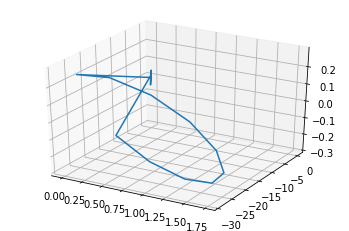

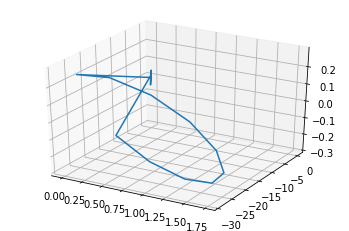

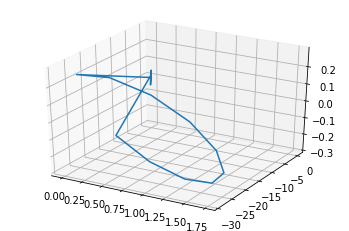

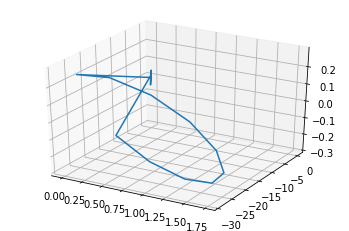

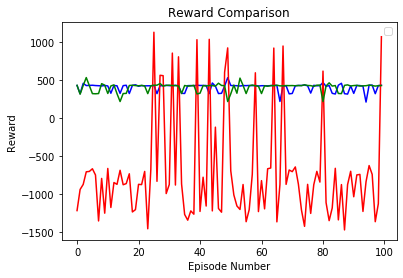

In [11]:
actor_lr = 0.0001
critic_lr = 0.001
gamma = 0.99
tau = 0.001
buffer_size = 100000
minibatch_size = 64
env = 'sat_inspection-v0'
random_seed = 1234
max_episodes = 3000
max_episode_len = 100
render_env = False
use_gym_monitor = False
test_episodes = 100
monitor_dir = './results/gym_ddpg'
summary_dir = './results/tf_ddpg'
args = {'actor_lr': actor_lr, 'critic_lr': critic_lr,'gamma': gamma,'tau': tau,'buffer_size': buffer_size,'minibatch_size': minibatch_size, 
       'env': env, 'random_seed': random_seed, 'max_episodes': max_episodes,'max_episode_len': max_episode_len,'render_env': render_env,
       'use_gym_monitor': use_gym_monitor, 'monitor_dir': monitor_dir, 'summary_dir': summary_dir, 'test_episodes': test_episodes}
main(args)